In [3]:
import os, sys
from pathlib import Path 
sys.path.append(str(Path().resolve().parent))
from src.dataset.clustering_dataset import ClusteringDataset
import torch

In [ ]:
# 例: Notebook / スクリプト側
import sys
from pathlib import Path 
sys.path.append(str(Path().resolve().parent))
from src.dataset.clustering_dataset import ClusteringDataset, UnicodeClassMapper
from torch.utils.data import DataLoader

root_dir = r"C:\Users\kotat\MyPrograms\MyKuzushiji\kuzushiji-recognition\char_sep_datas"
# root_dir = r"/scratch/users/grad/2025/25t0024/programs/MyKuzushiji/kuzushiji-recognition/char_sep_datas"

test_docs = [
    "200021637","100249371","100249537","200005598",
    "200014740","200020019","200021712","200021869",
]

# 1) まず train/test を作る（mapper を共有するとクラス次元Cが揃います）
mapper = UnicodeClassMapper()

train_ds = ClusteringDataset(
    root_dir=root_dir,
    canvas_width=2048,
    patch_size=256,
    test_mode=False,
    test_docs=test_docs,
    mapper=mapper,
)

test_ds = ClusteringDataset(
    root_dir=root_dir,
    canvas_width=2048,
    patch_size=256,
    test_mode=True,
    test_docs=test_docs,
    mapper=mapper,  # ★同じmapper
)

print("train:", len(train_ds), "test:", len(test_ds))
print("num_classes(C):", mapper.num_classes)

# 2) 1サンプル取り出し
sample = train_ds[6]
img = sample["image"]                 # (3,H,W) float32 0..1
final_mask = sample["final_text_mask"]# (H,W) 0/1
aff_mask = sample["affinity_mask"]    # (H,W) 0/1
label_map = sample["label_map"]       # (H,W,C) one-hot
meta = sample["meta"]

print(img.shape, final_mask.shape, aff_mask.shape, label_map.shape, meta)

# 3) DataLoader で回す
loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
batch = next(iter(loader))
print(batch["image"].shape)          # (B,3,H,W)
print(batch["label_map"].shape)      # (B,H ,W,C)

train: 5204 test: 947
num_classes(C): 159
torch.Size([3, 3328, 2048]) torch.Size([3328, 2048]) torch.Size([3328, 2048]) torch.Size([3328, 2048, 159]) {'doc_id': '100241706', 'image_id': '100241706_00004_2', 'image_path': 'C:\\Users\\kotat\\MyPrograms\\MyKuzushiji\\kuzushiji-recognition\\char_sep_datas\\100241706\\images\\100241706_00004_2.jpg', 'num_classes': 159}
torch.Size([1, 3, 3328, 2048])
torch.Size([1, 3328, 2048, 159])


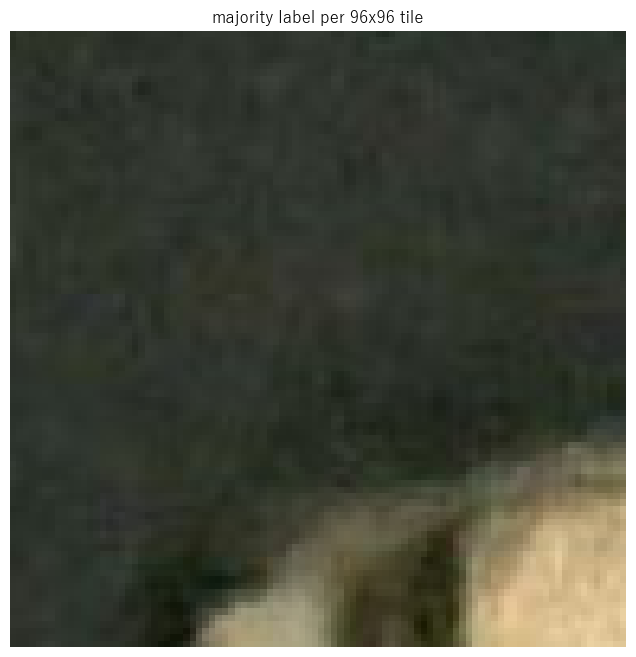

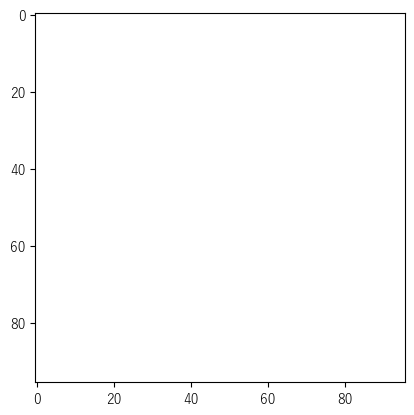

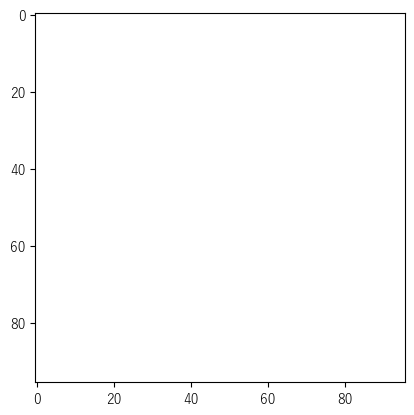

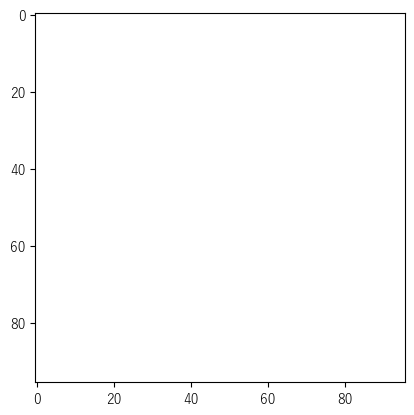

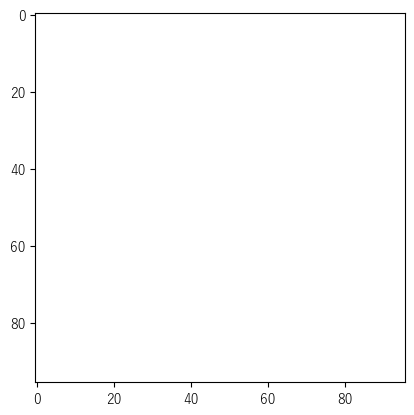

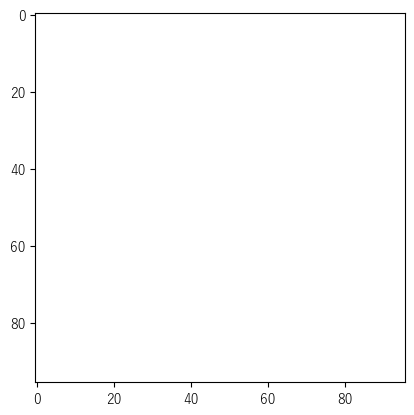

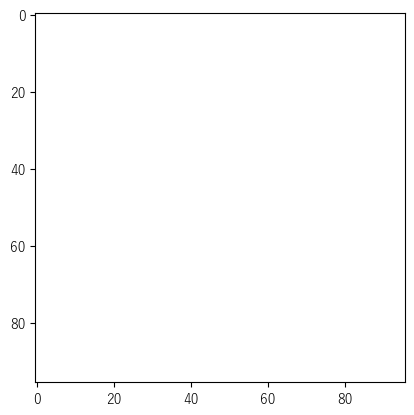

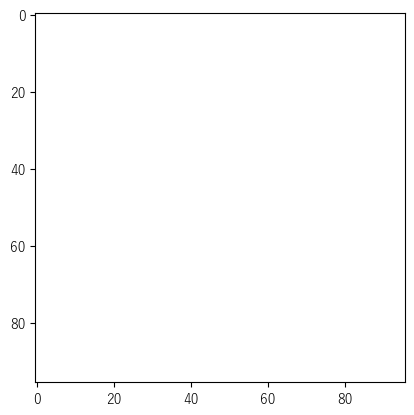

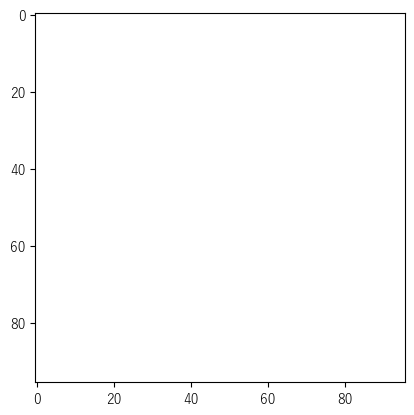

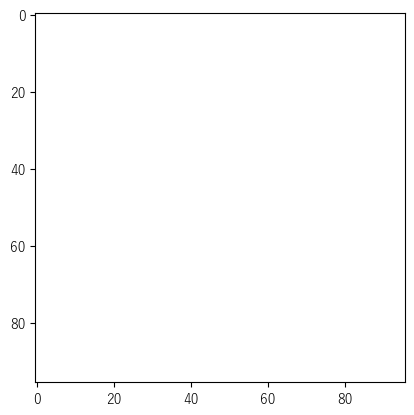

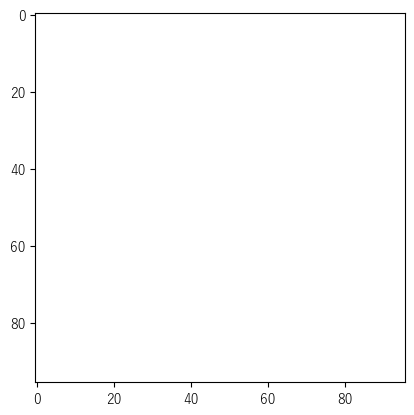

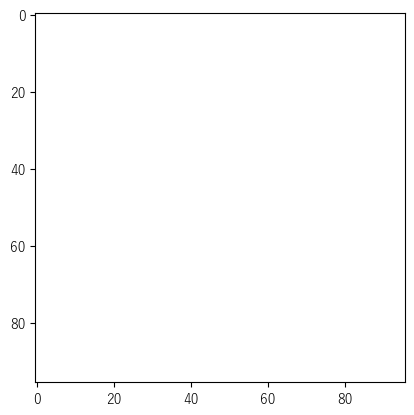

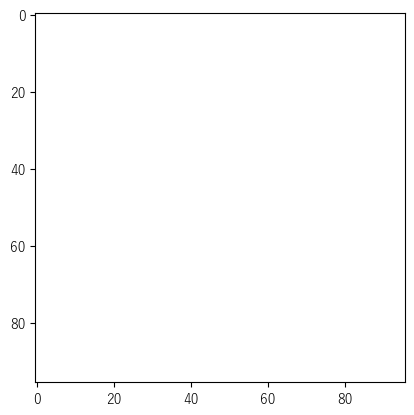

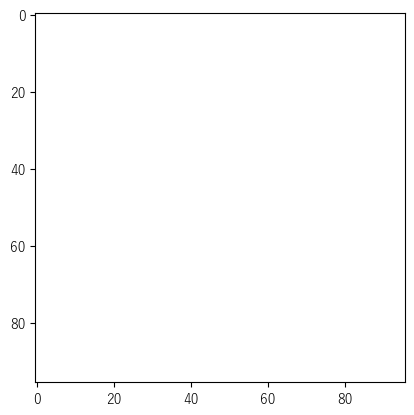

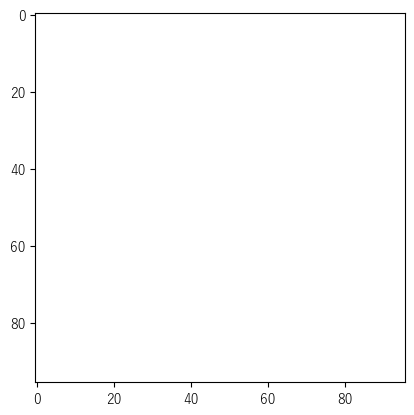

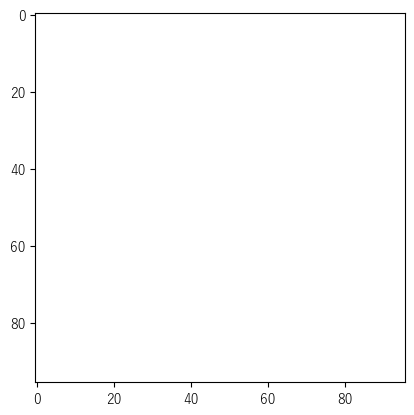

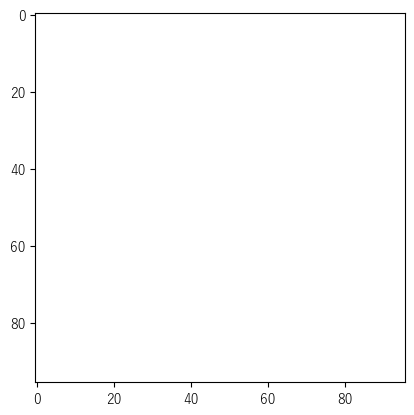

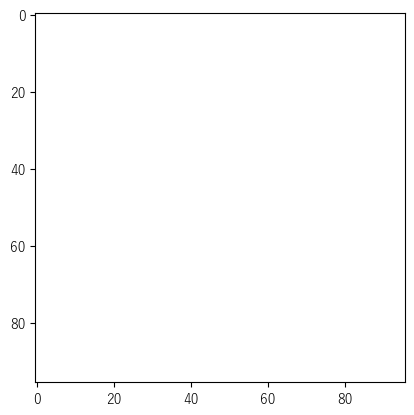

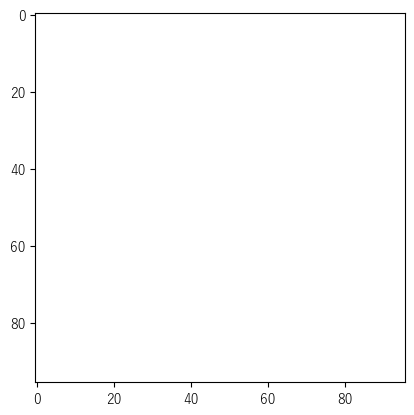

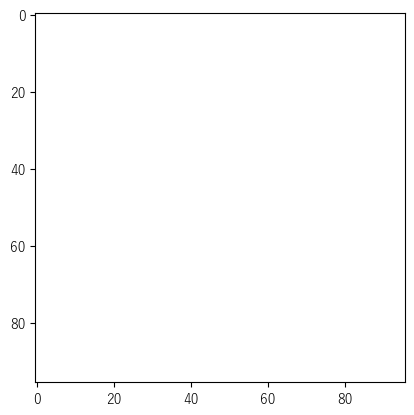

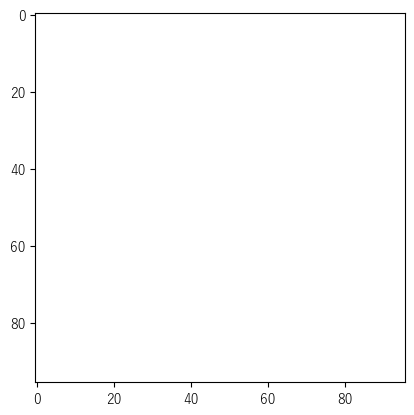

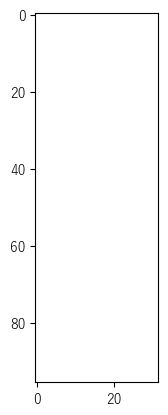

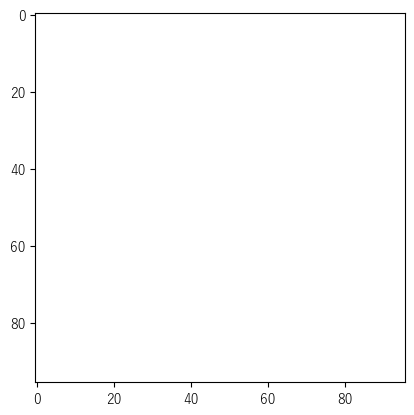

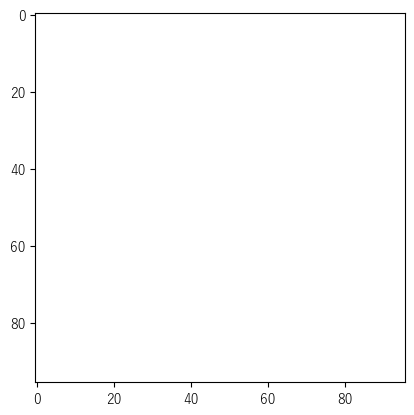

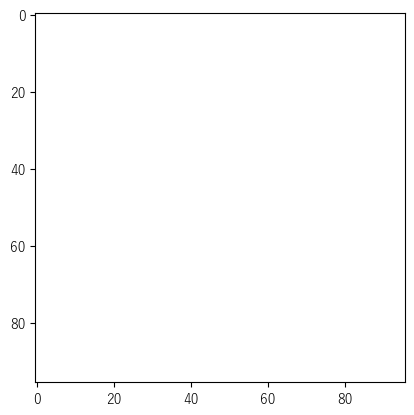

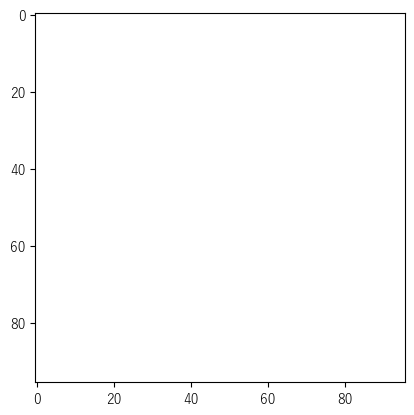

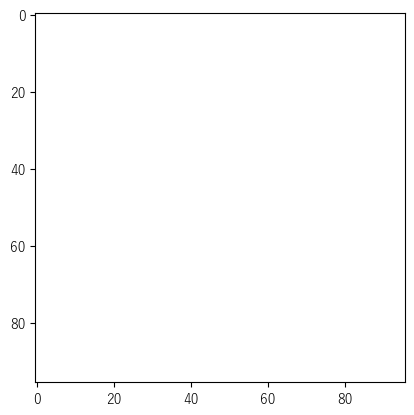

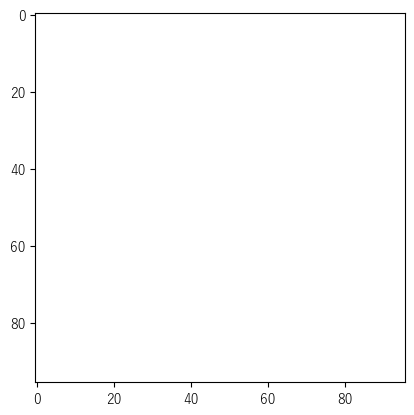

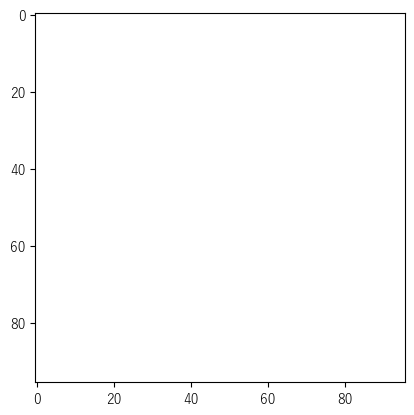

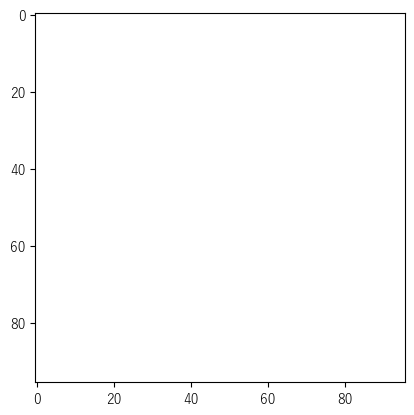

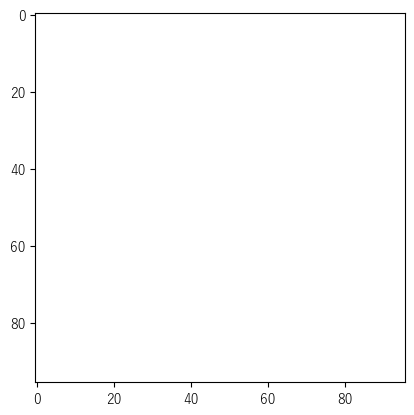

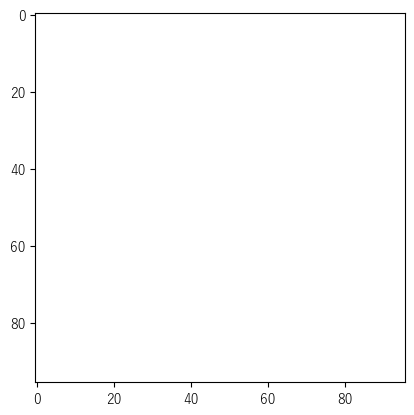

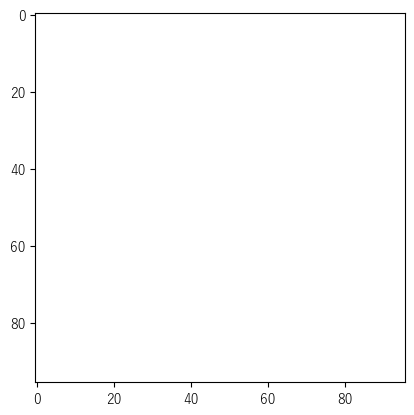

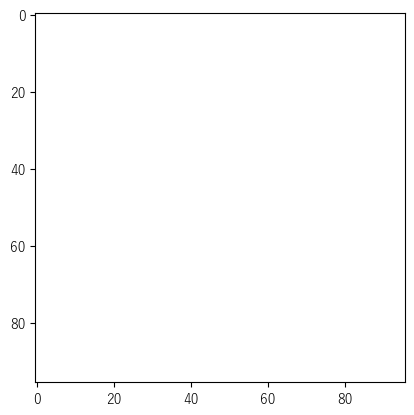

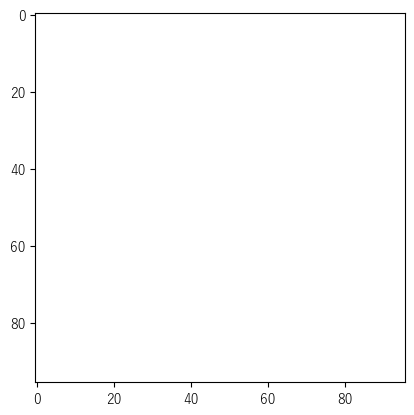

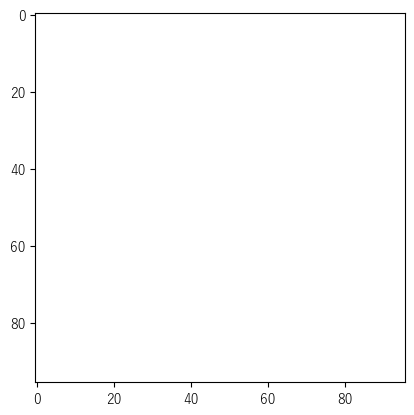

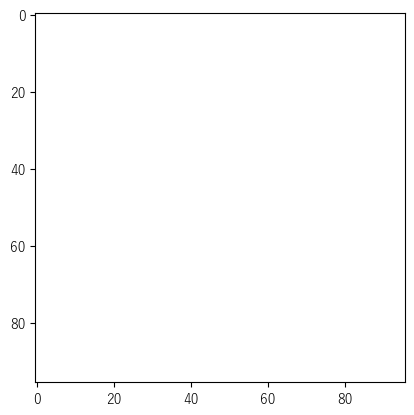

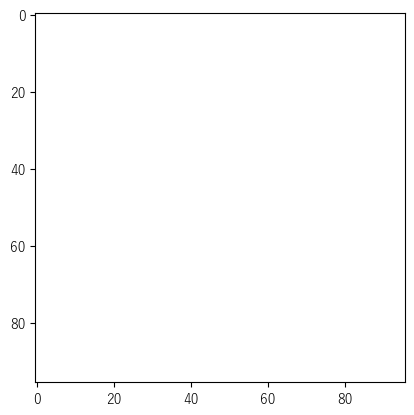

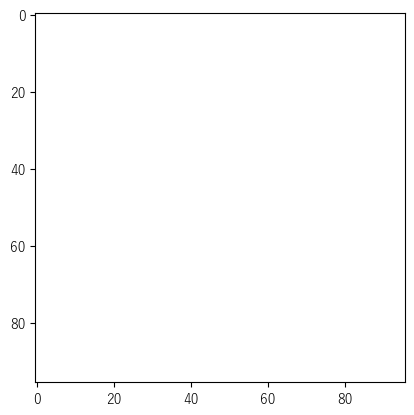

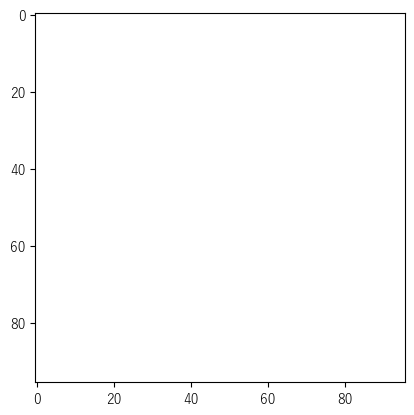

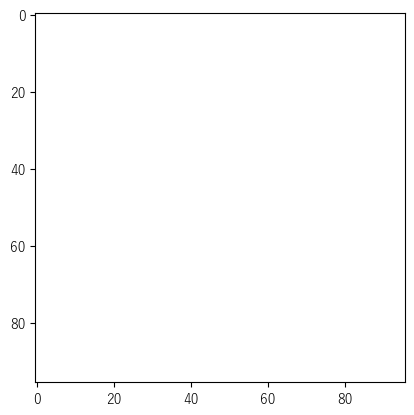

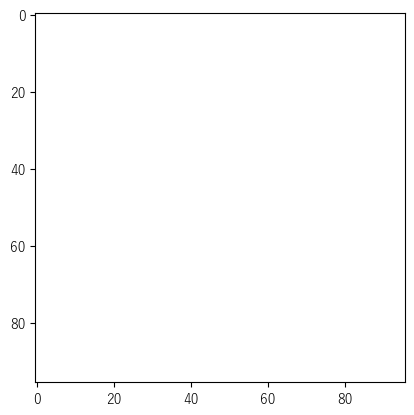

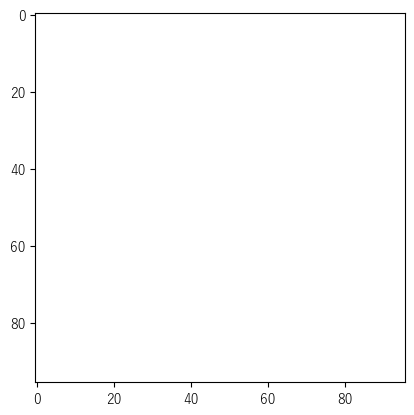

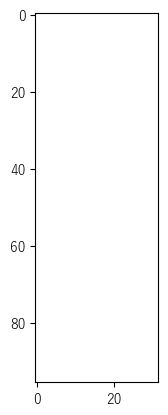

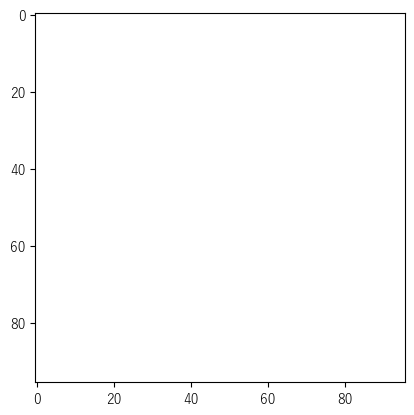

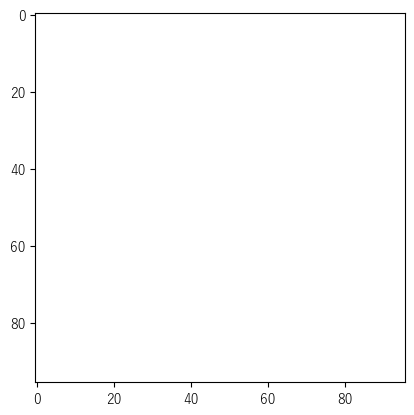

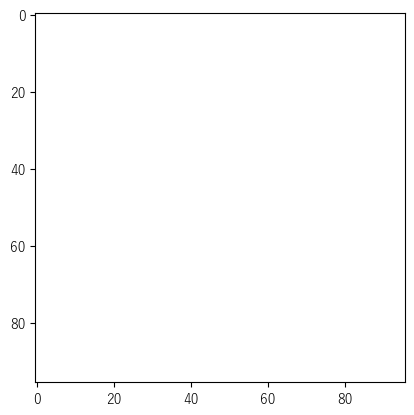

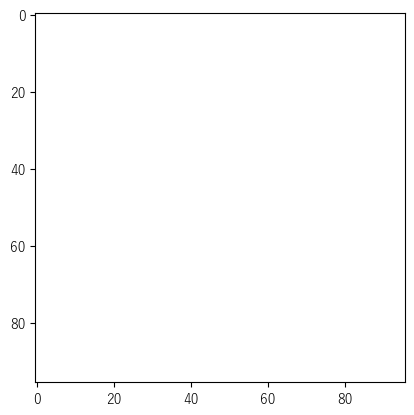

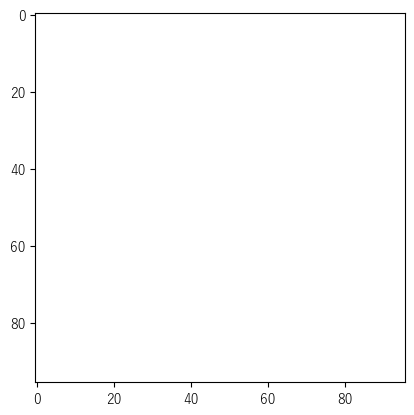

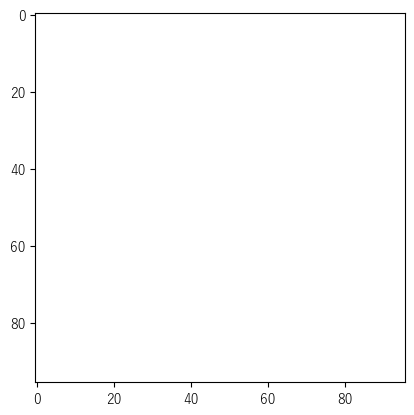

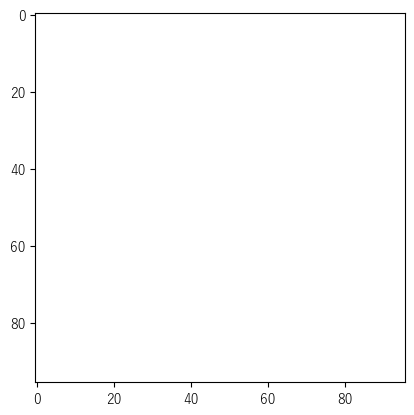

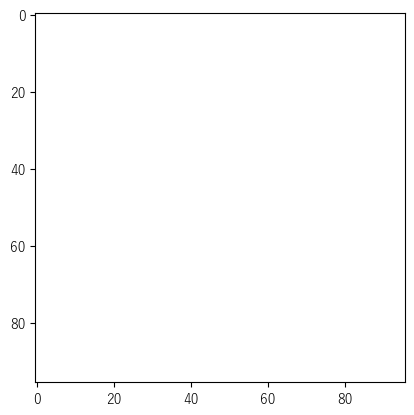

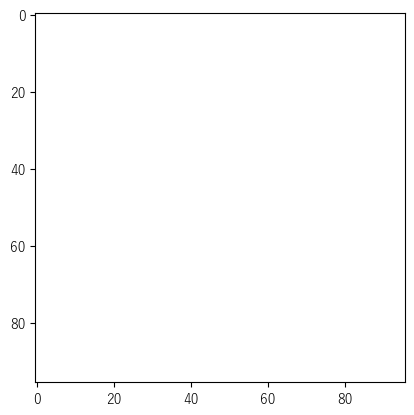

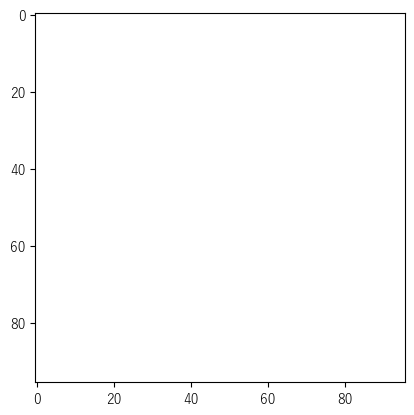

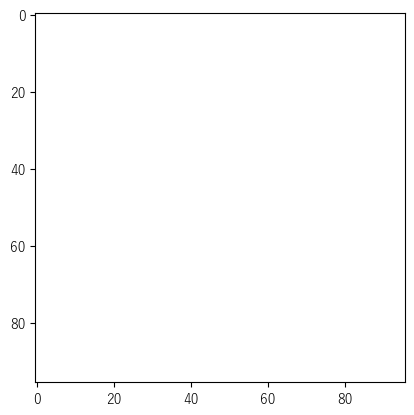

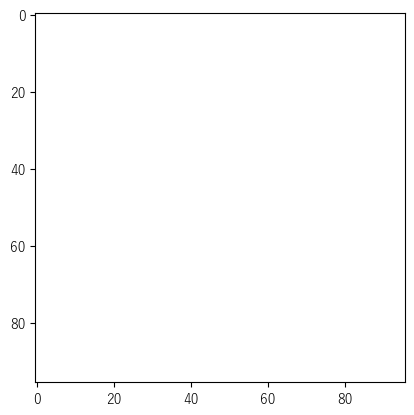

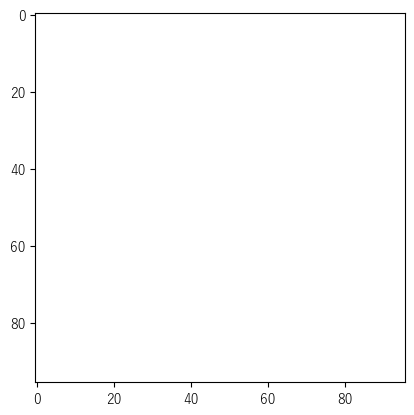

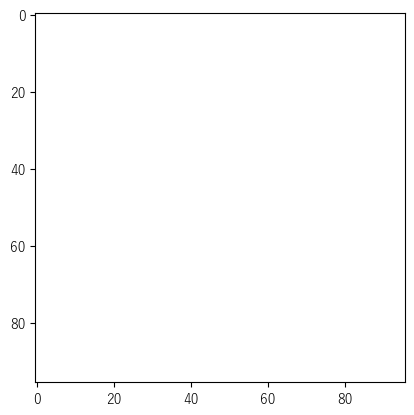

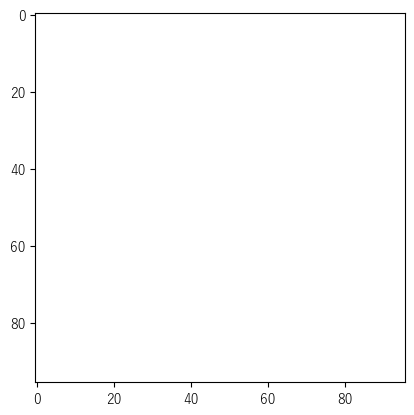

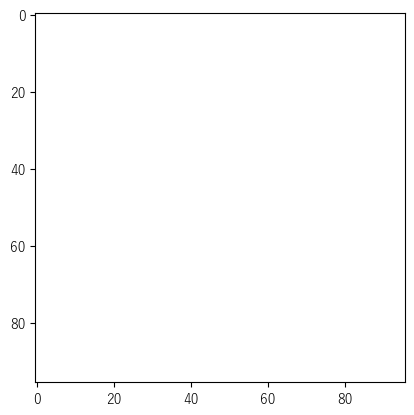

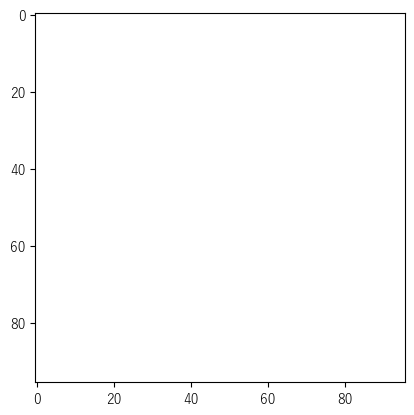

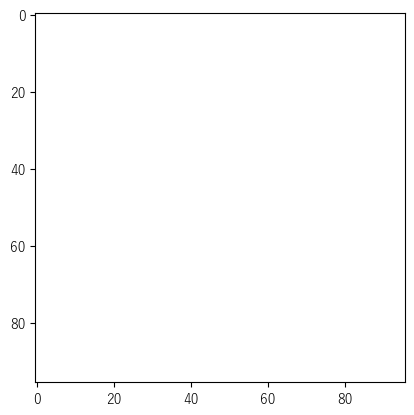

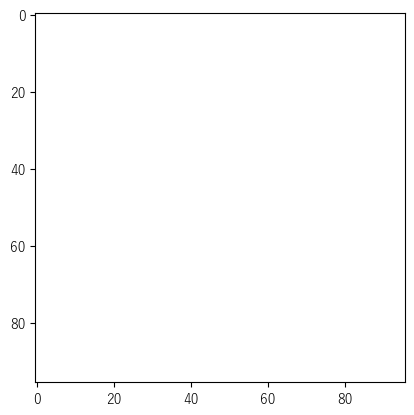

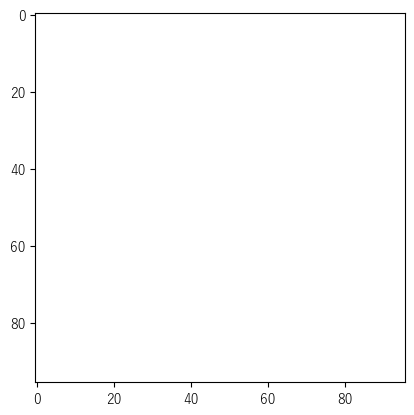

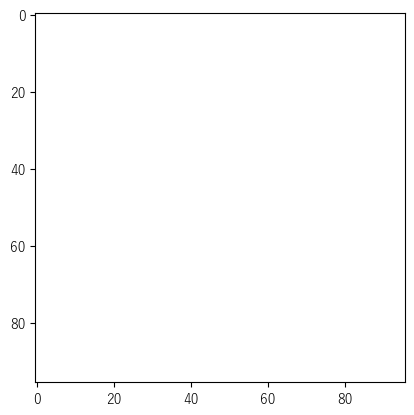

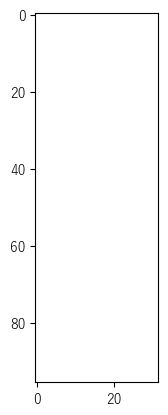

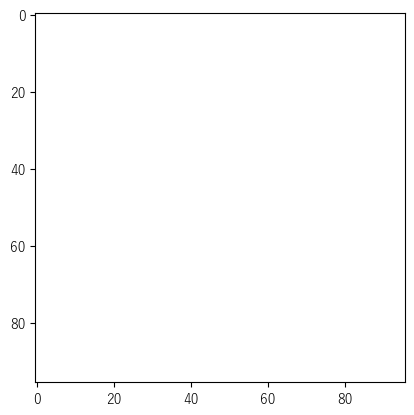

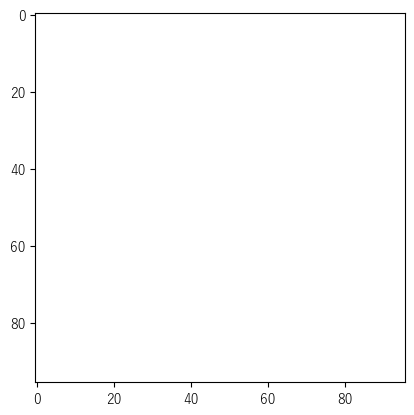

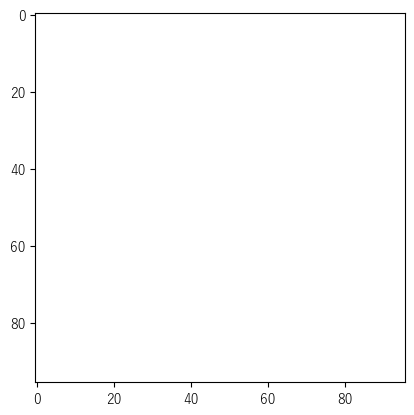

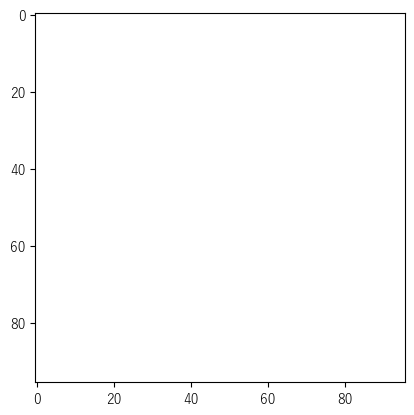

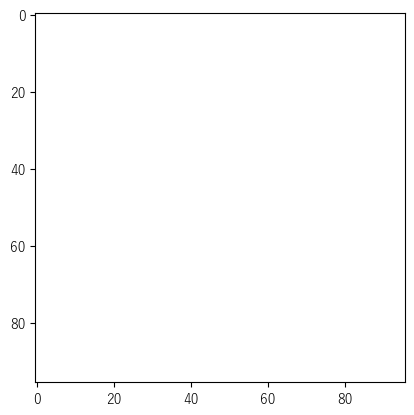

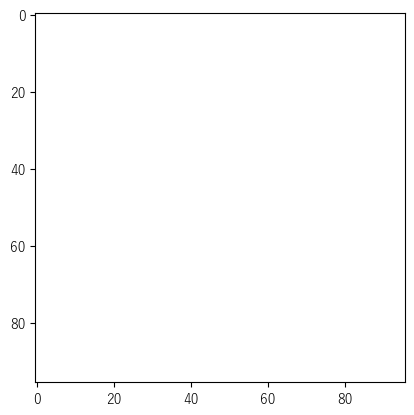

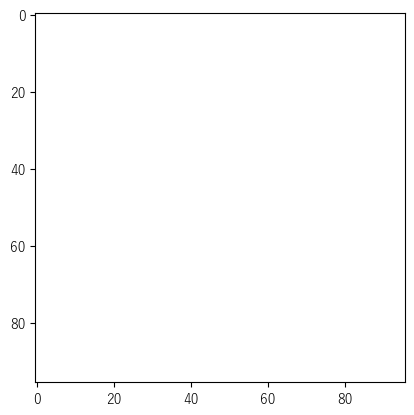

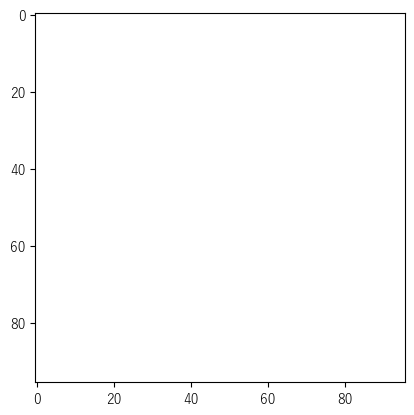

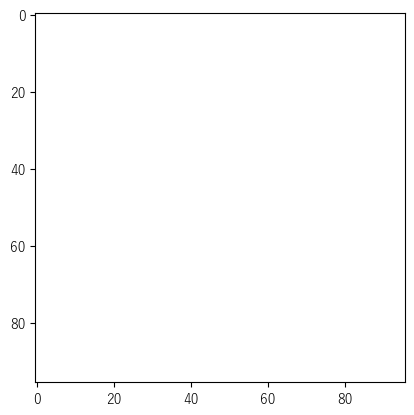

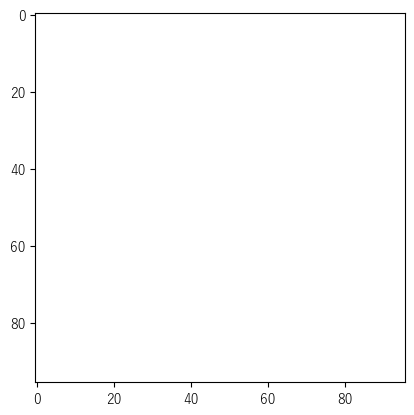

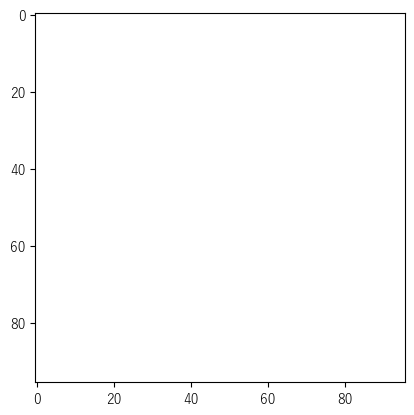

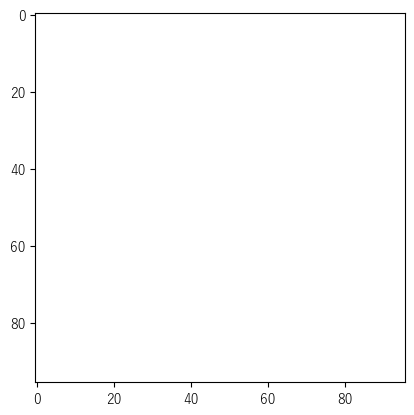

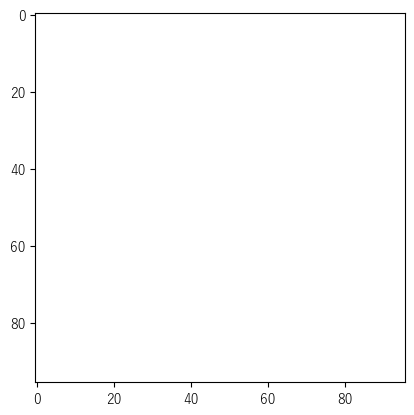

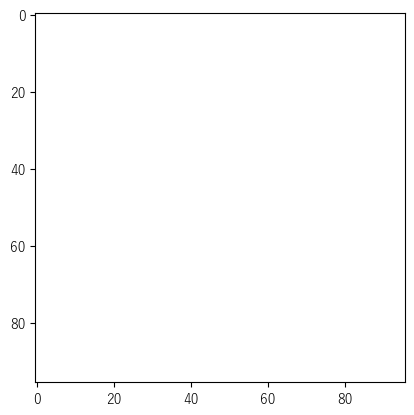

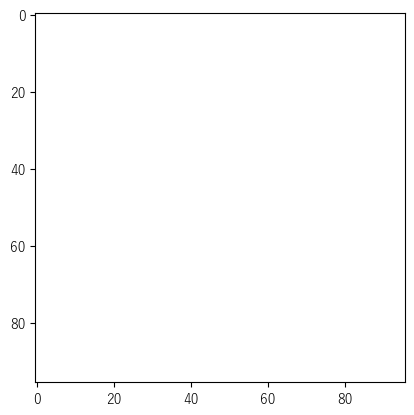

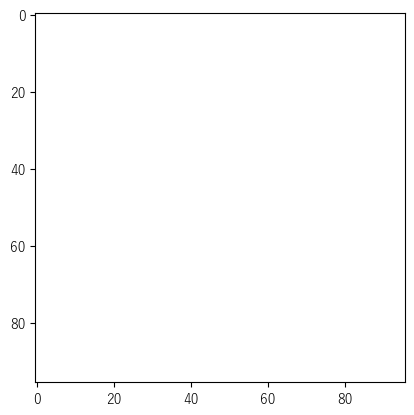

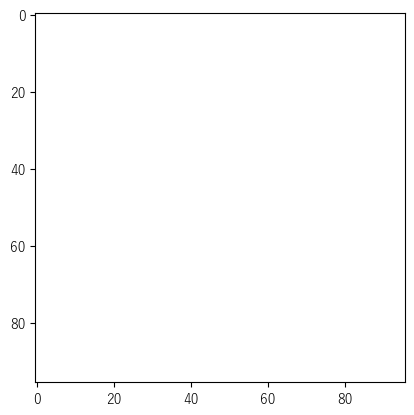

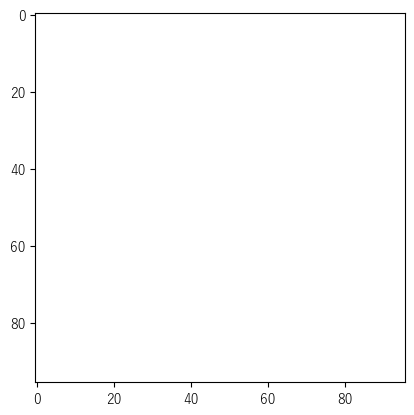

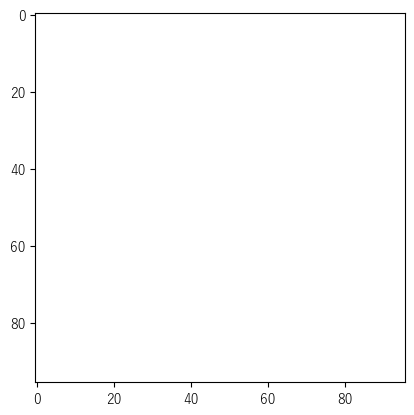

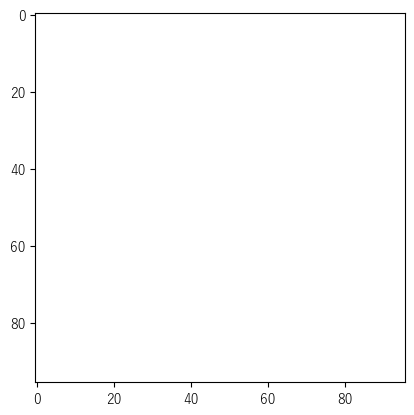

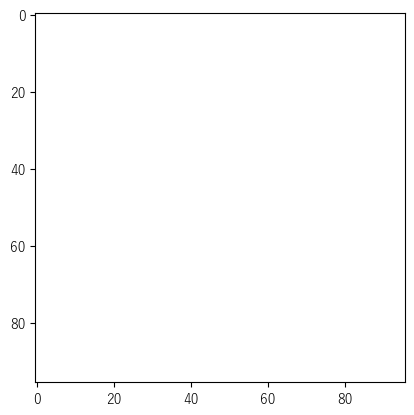

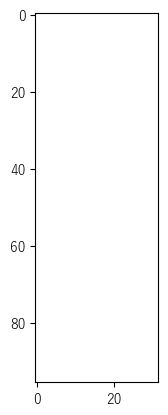

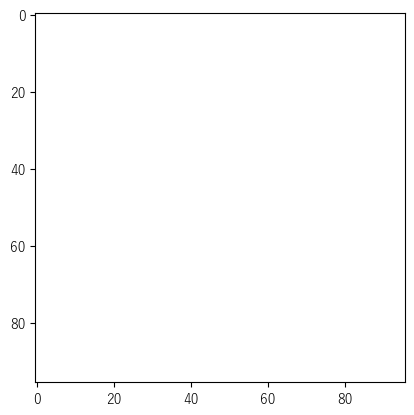

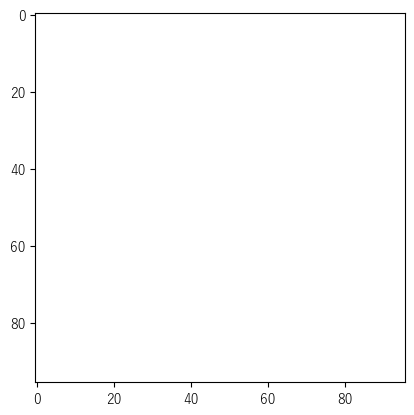

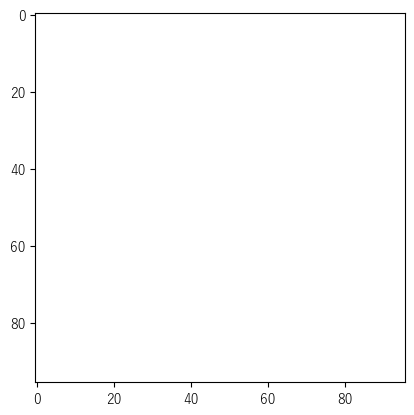

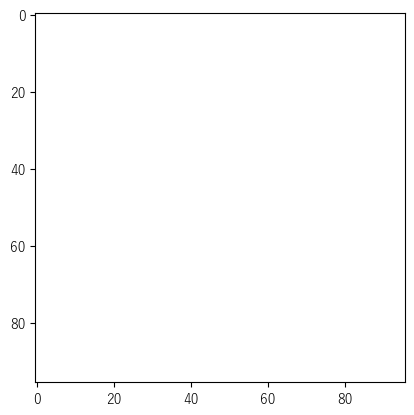

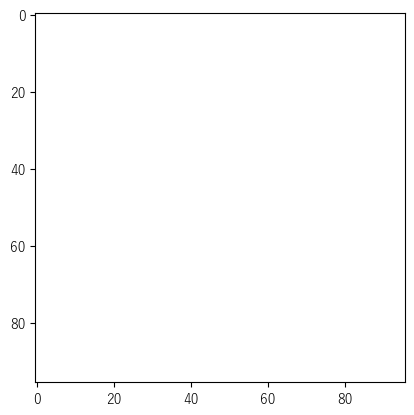

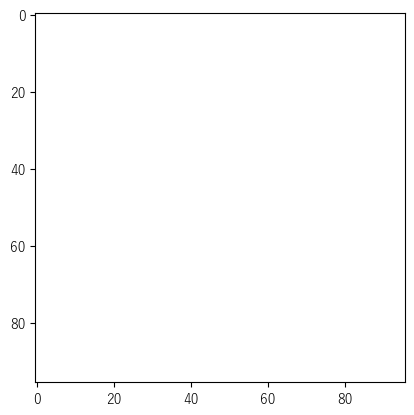

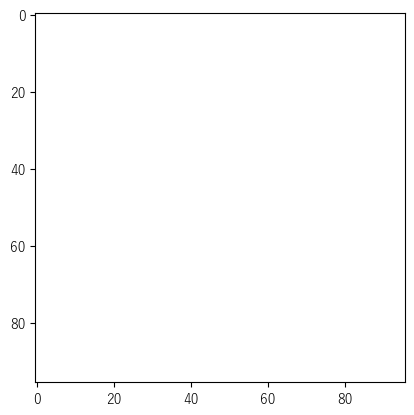

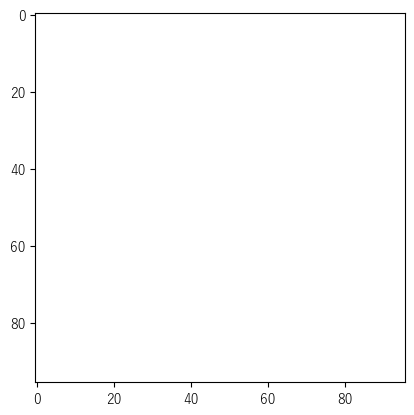

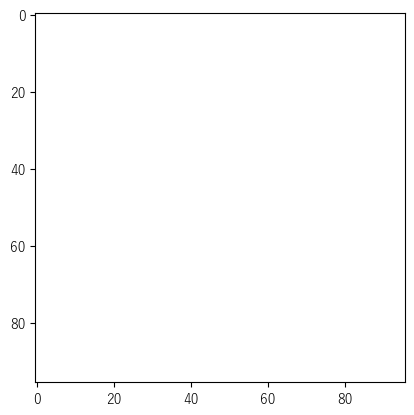

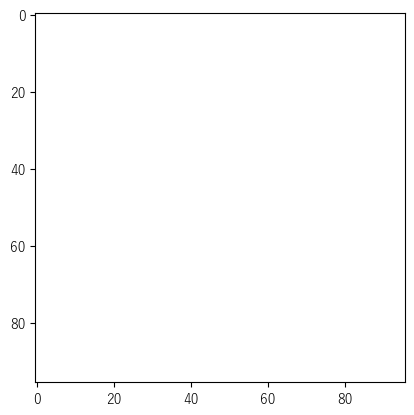

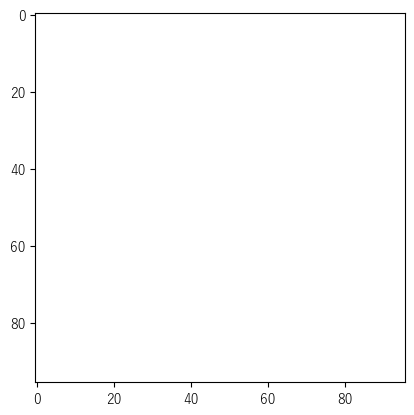

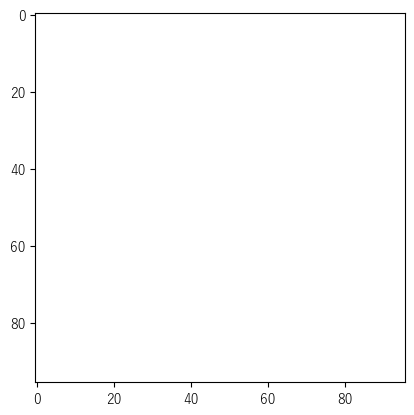

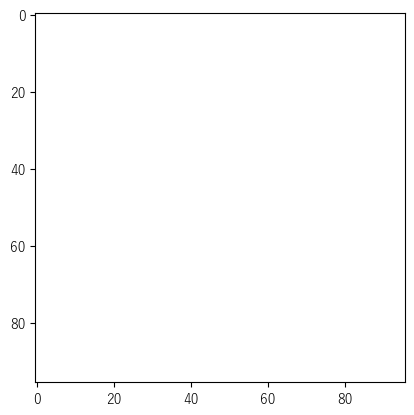

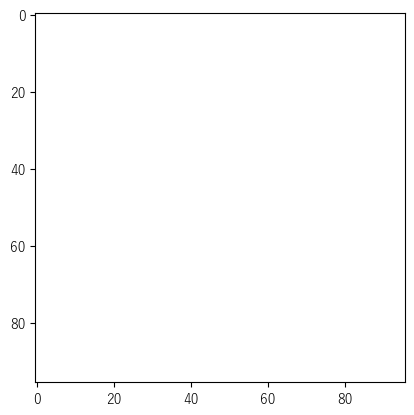

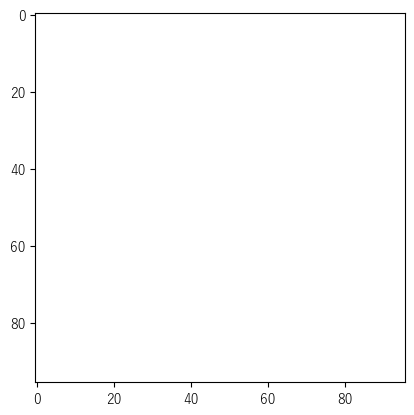

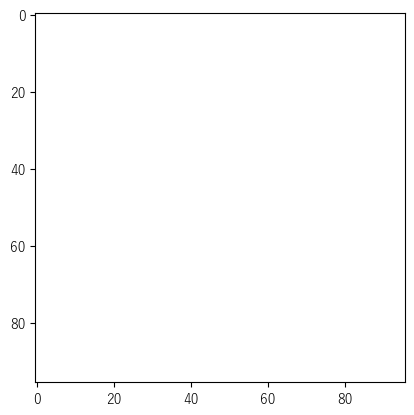

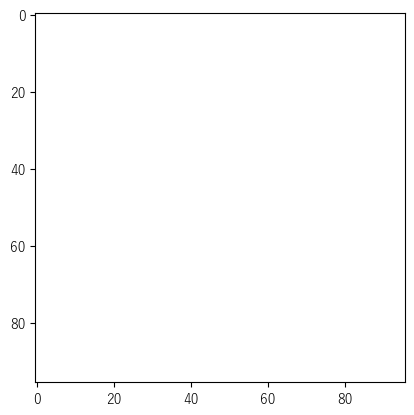

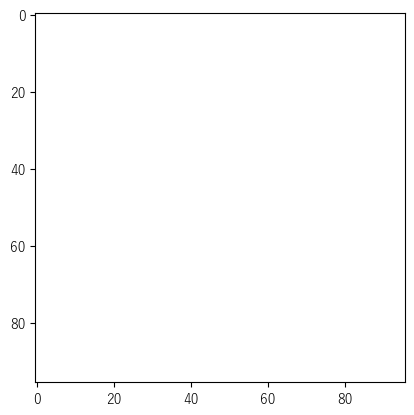

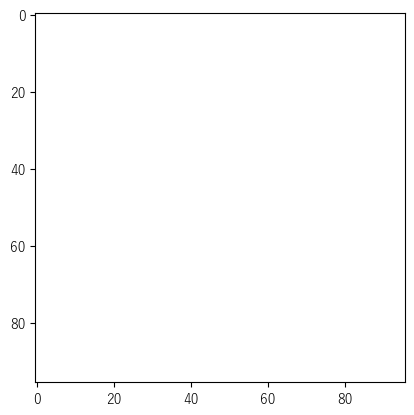

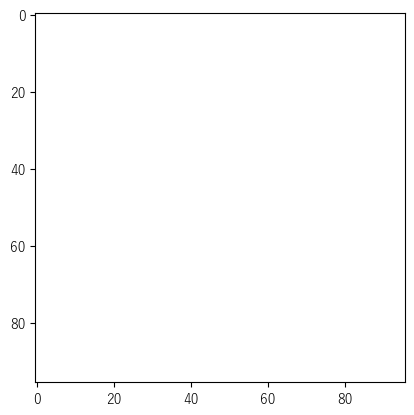

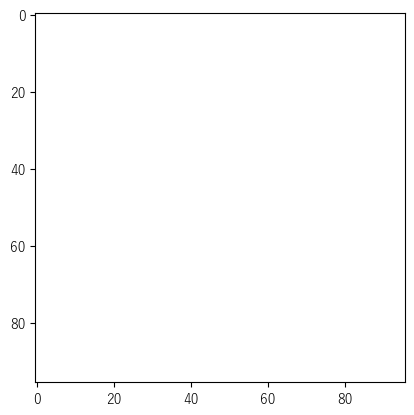

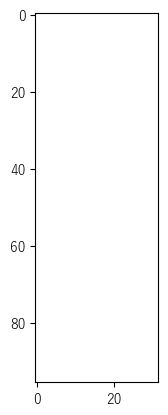

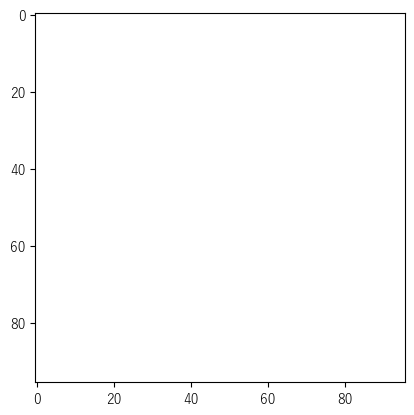

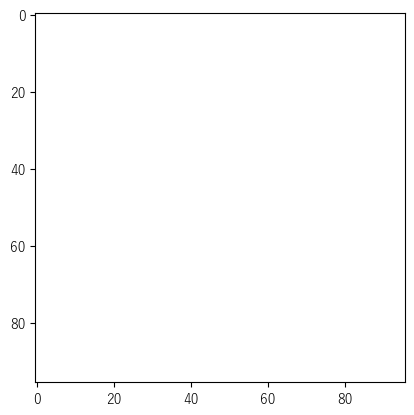

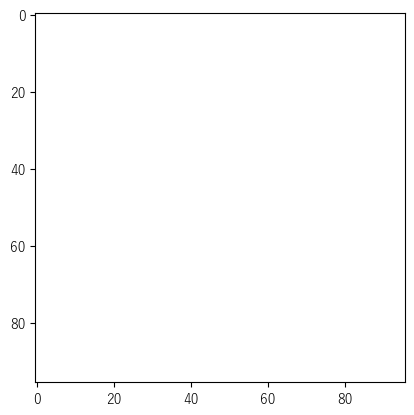

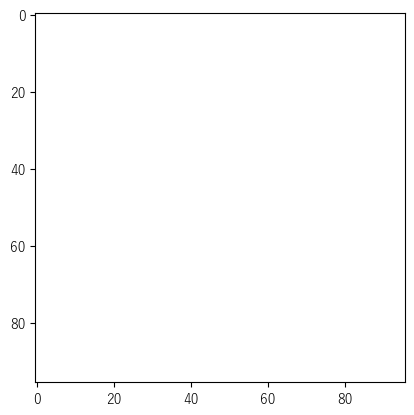

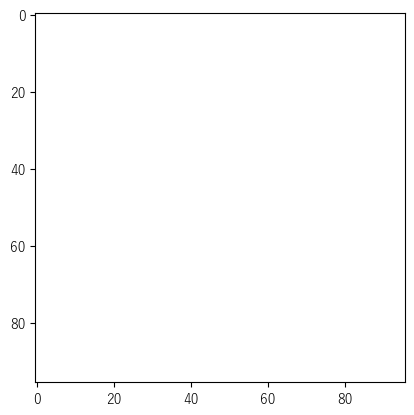

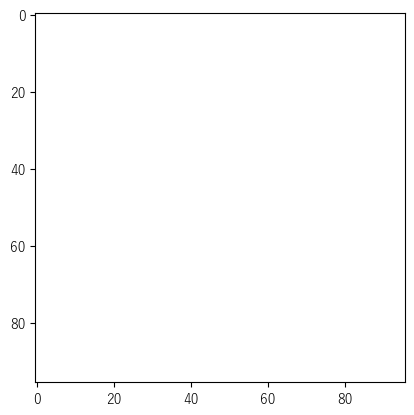

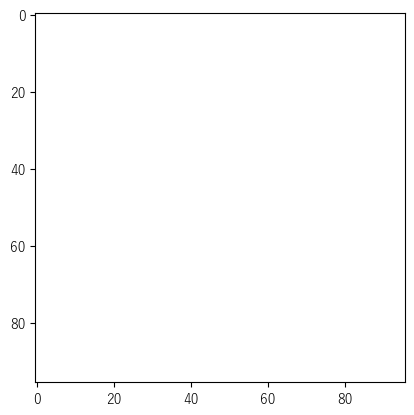

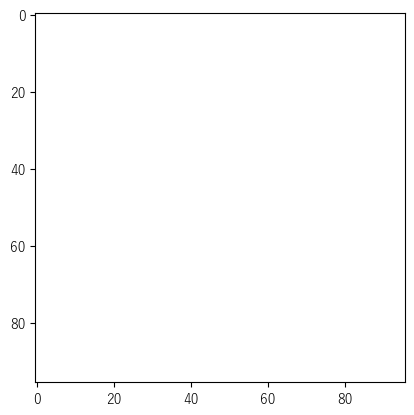

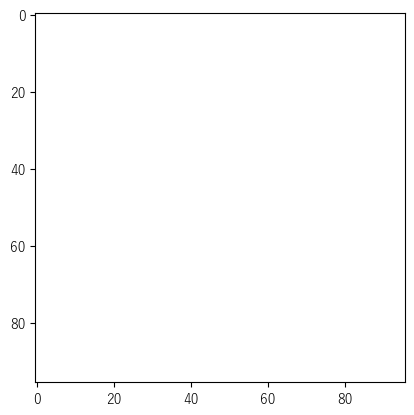

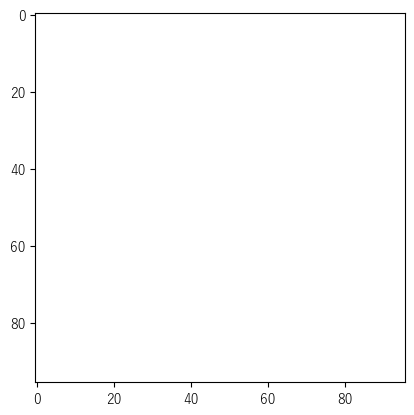

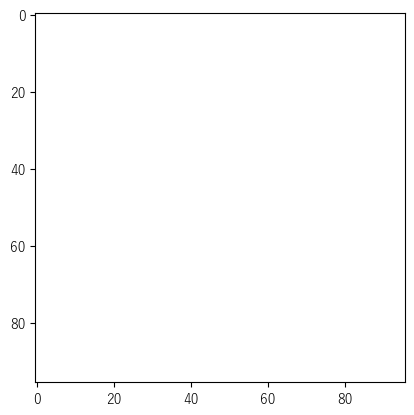

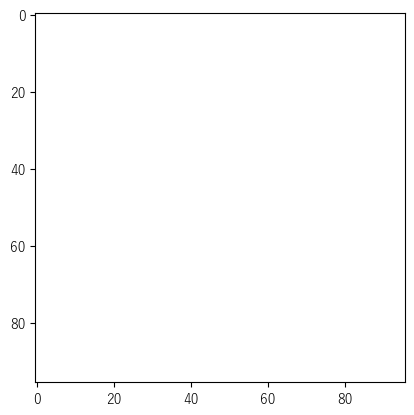

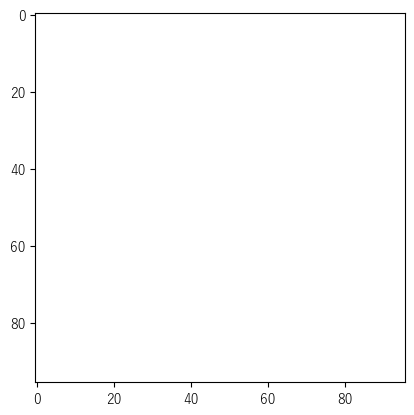

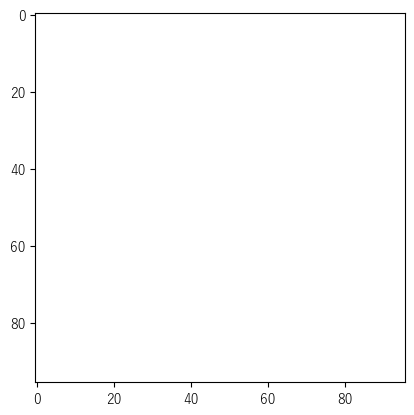

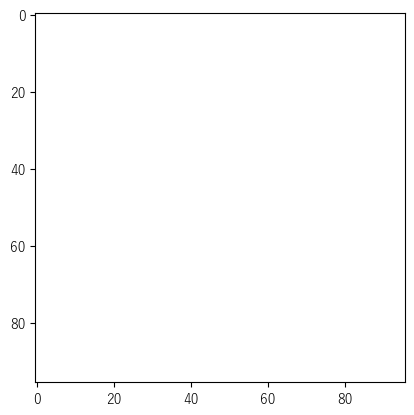

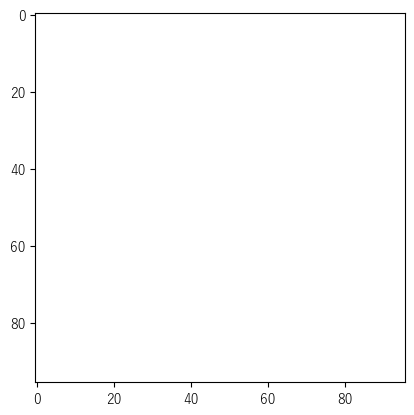

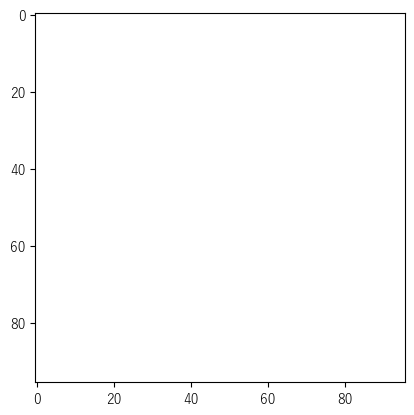

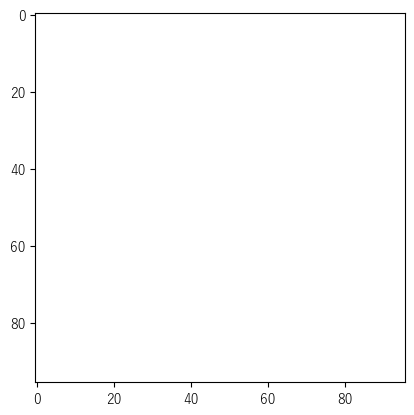

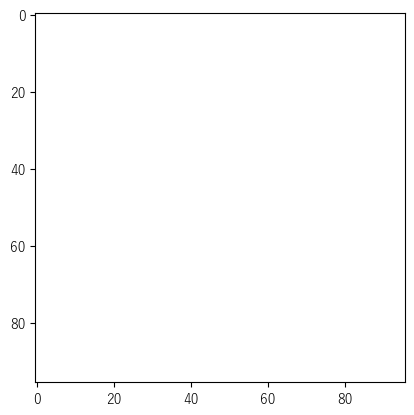

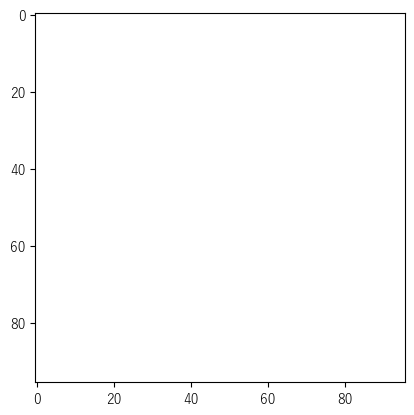

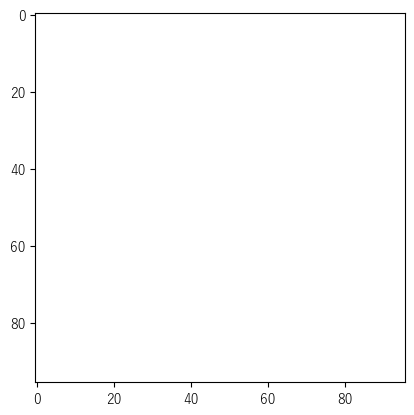

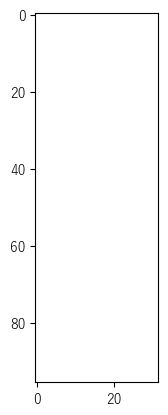

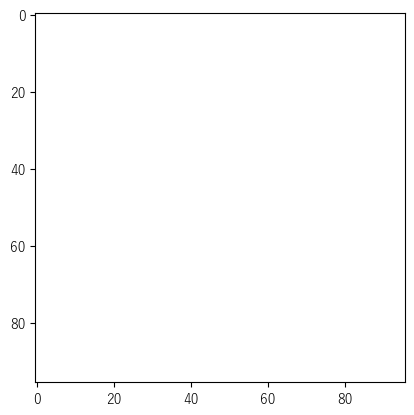

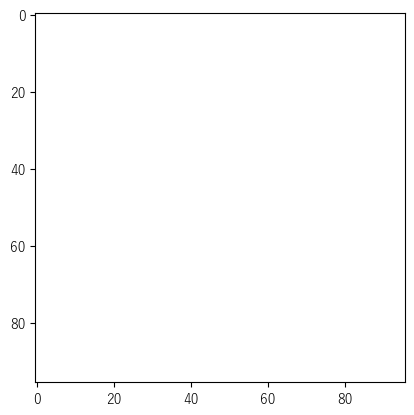

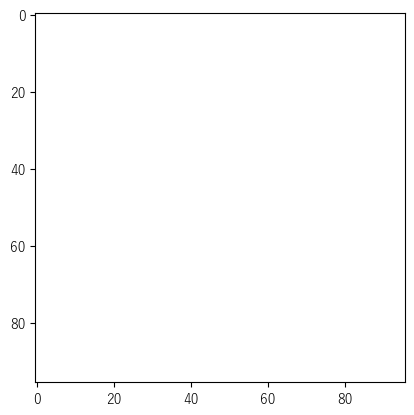

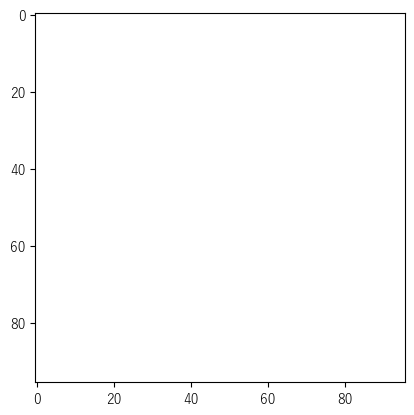

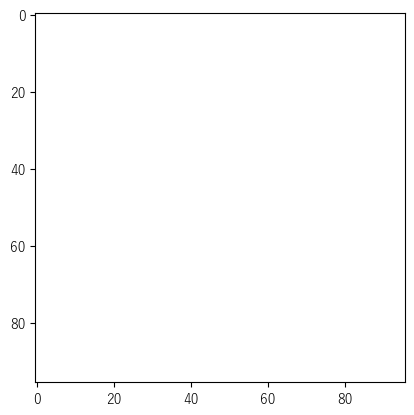

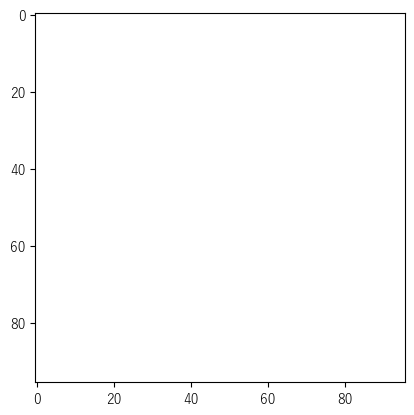

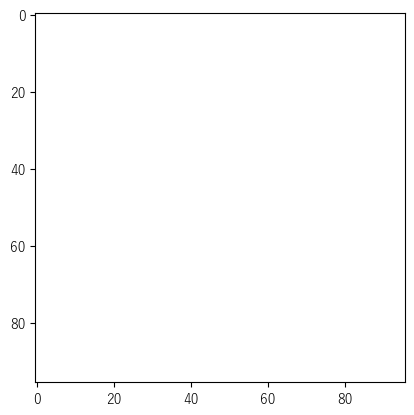

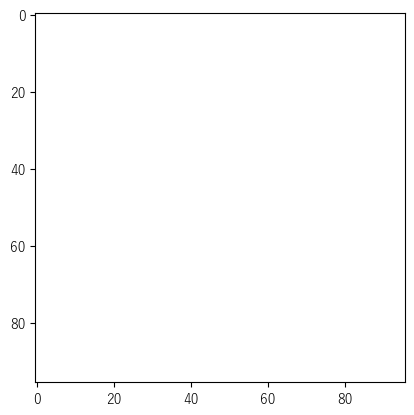

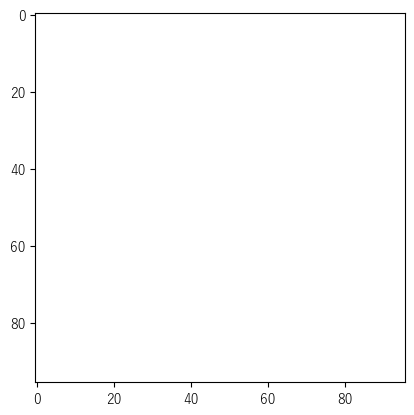

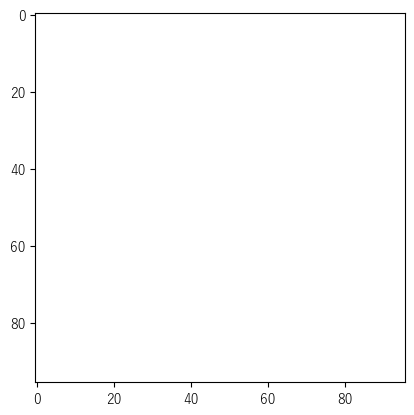

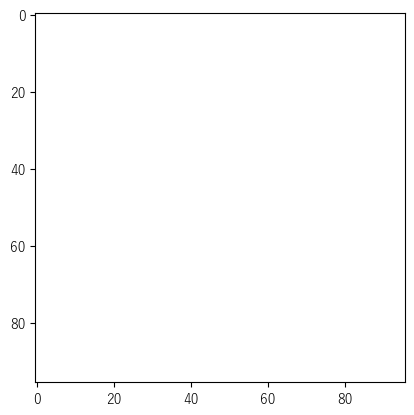

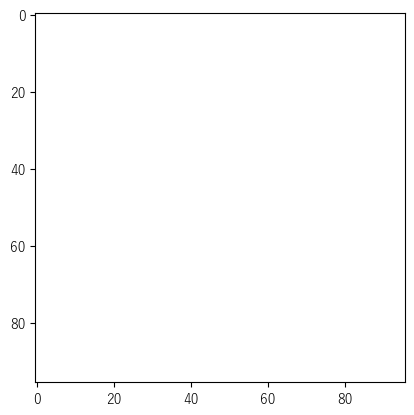

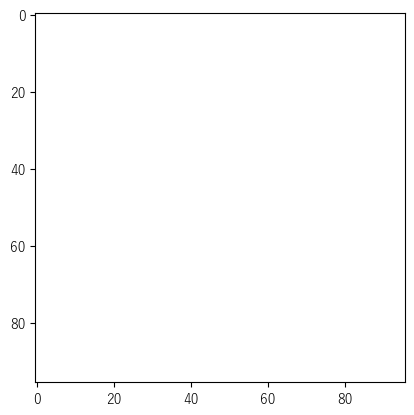

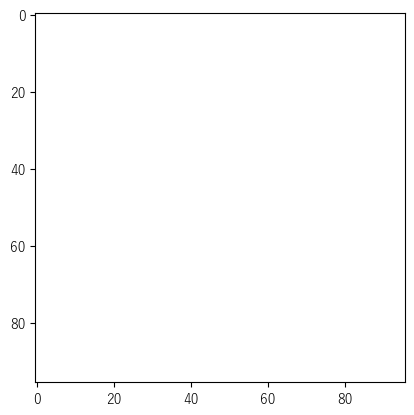

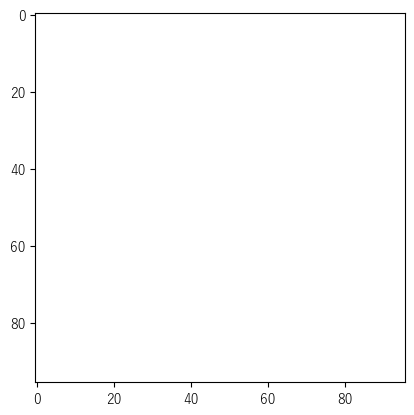

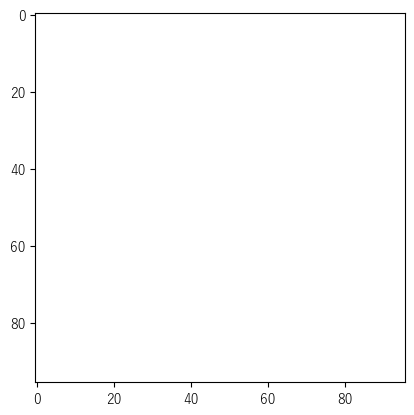

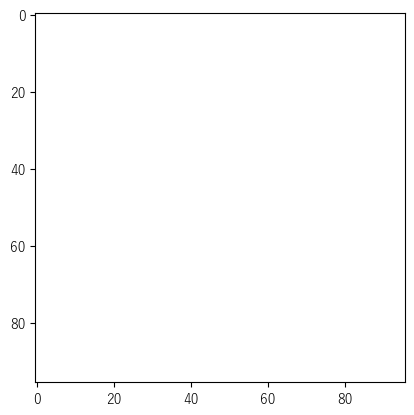

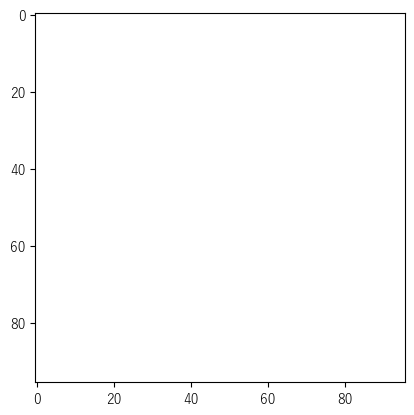

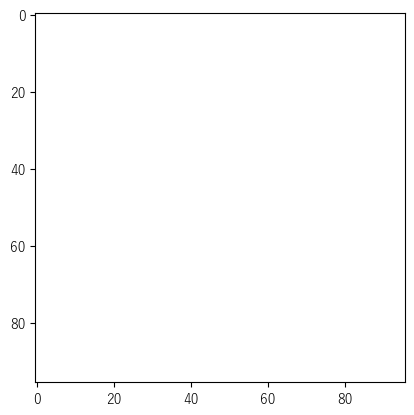

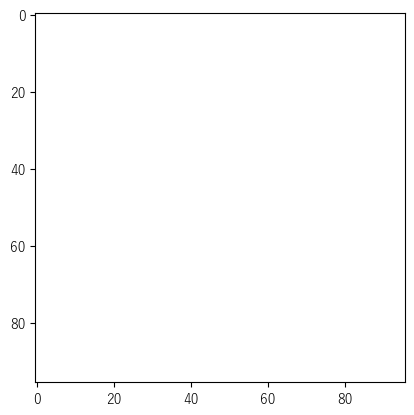

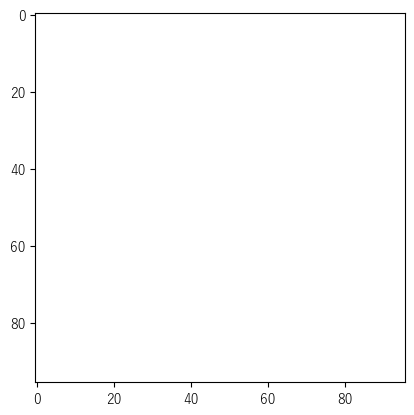

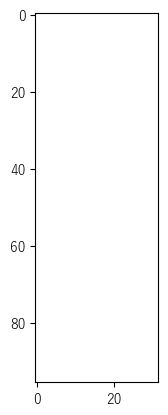

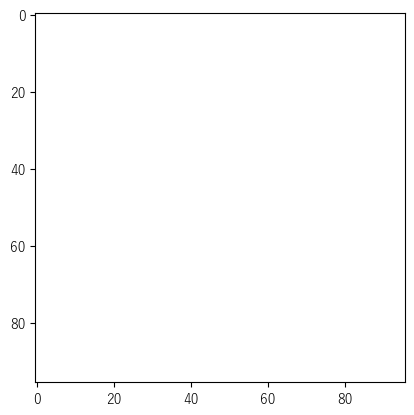

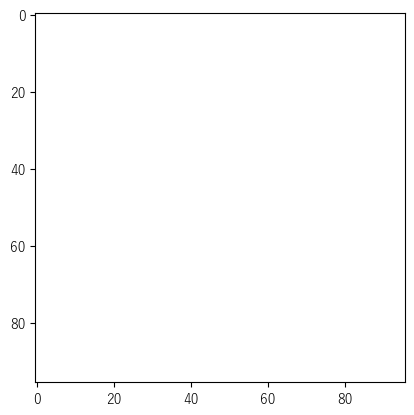

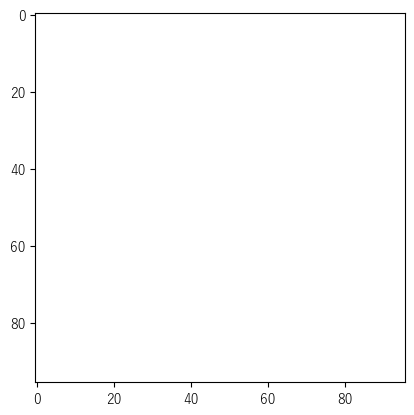

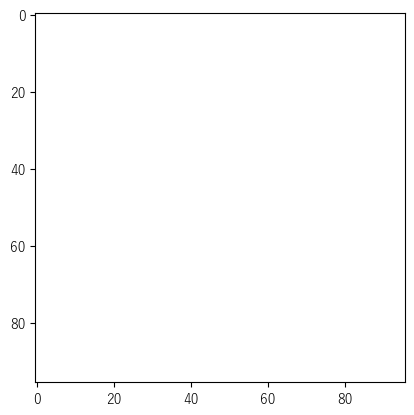

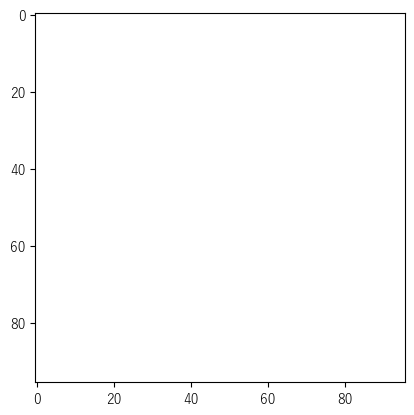

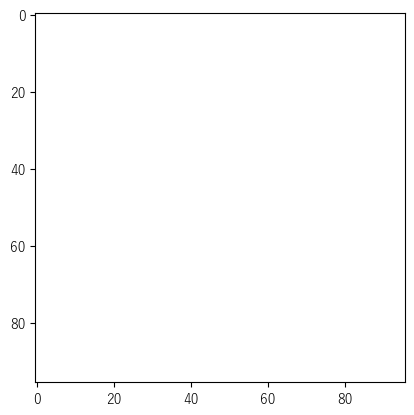

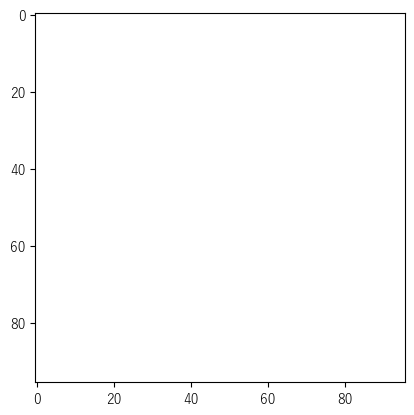

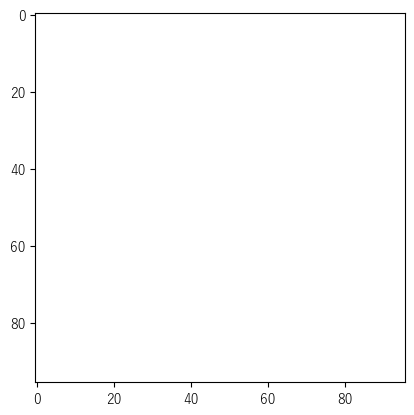

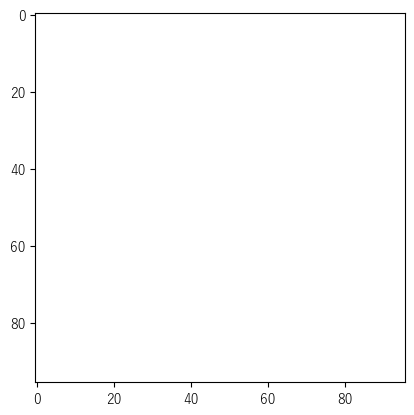

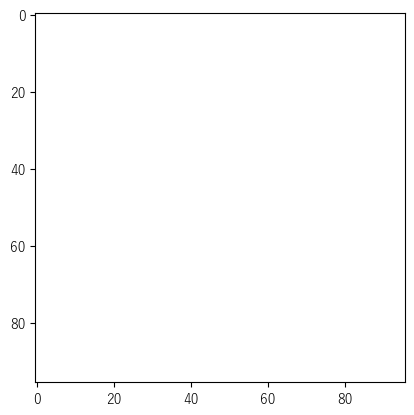

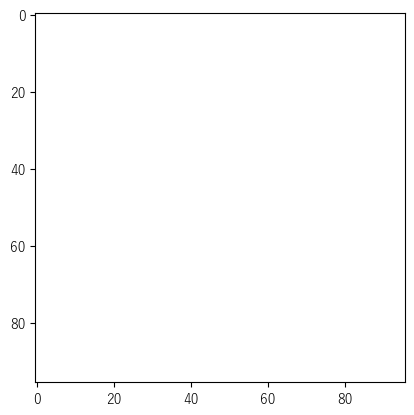

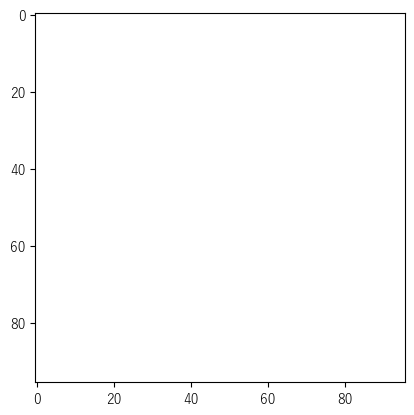

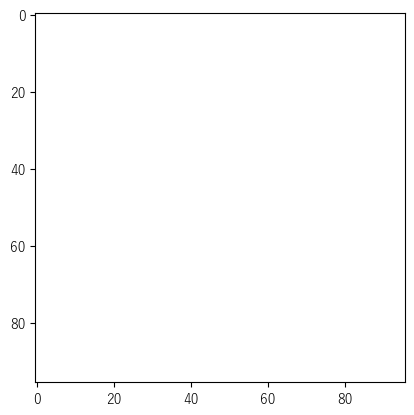

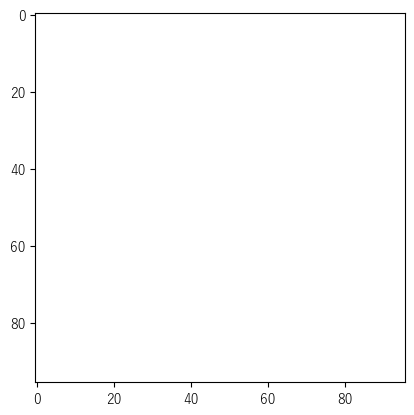

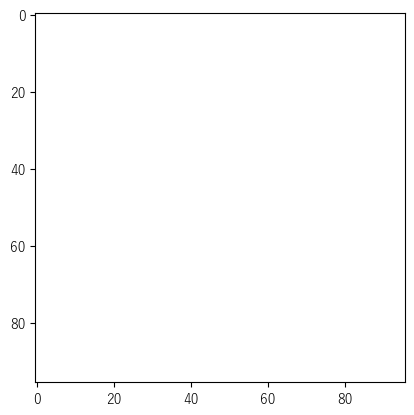

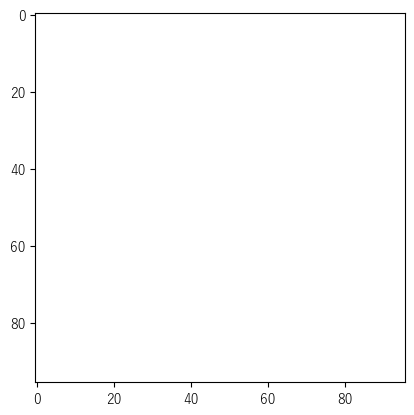

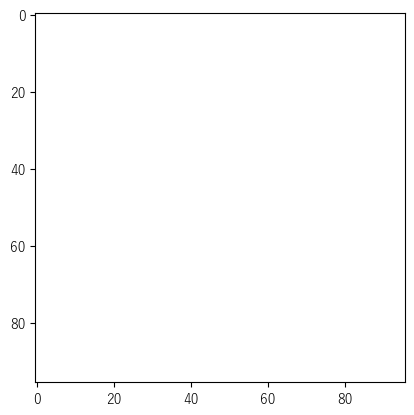

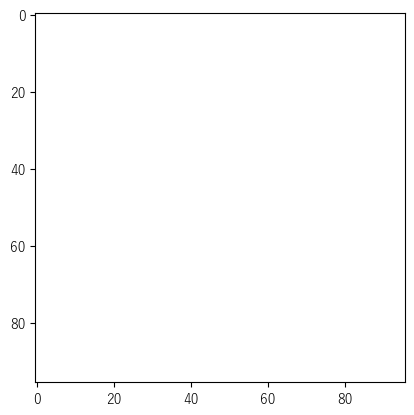

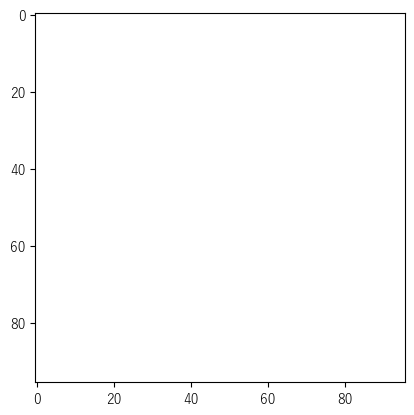

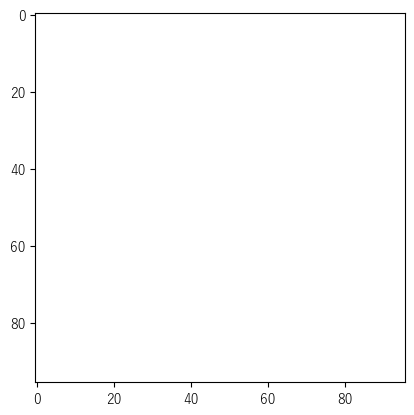

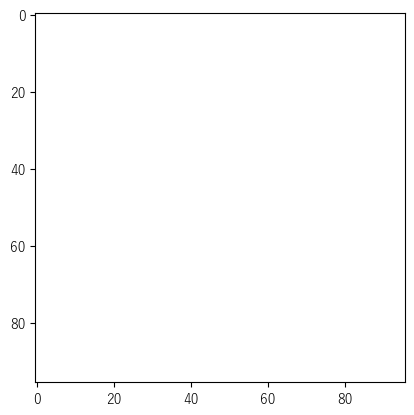

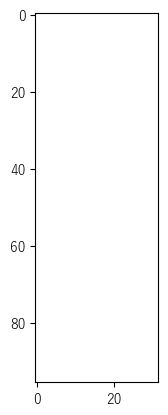

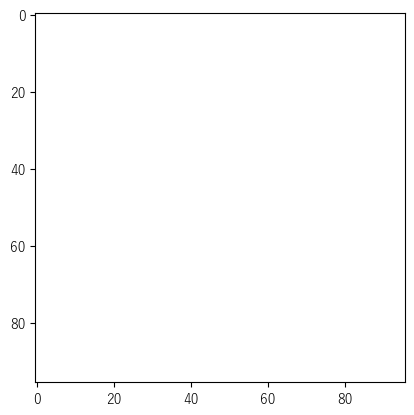

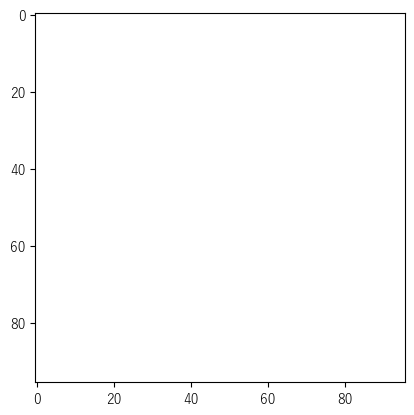

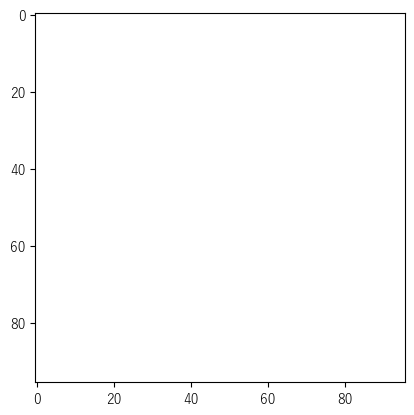

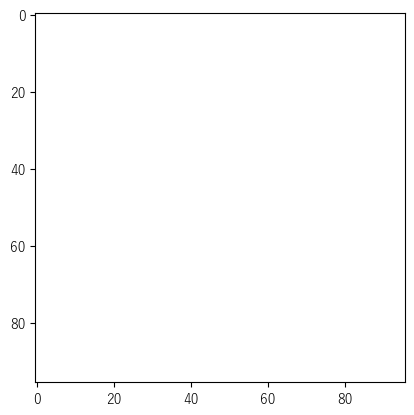

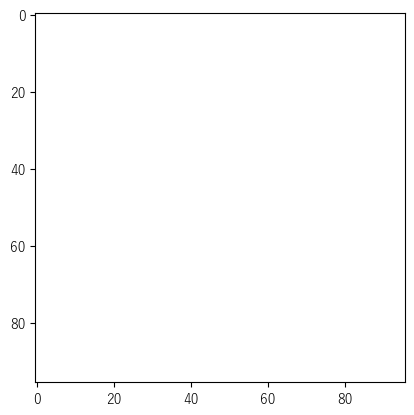

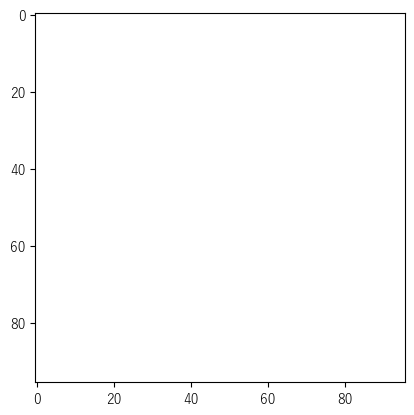

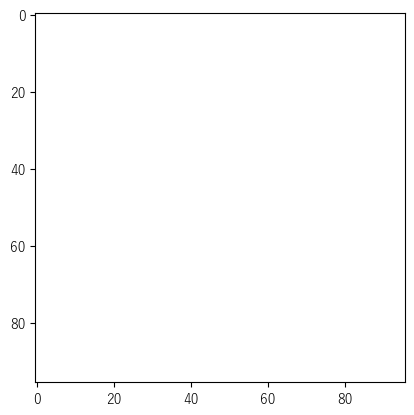

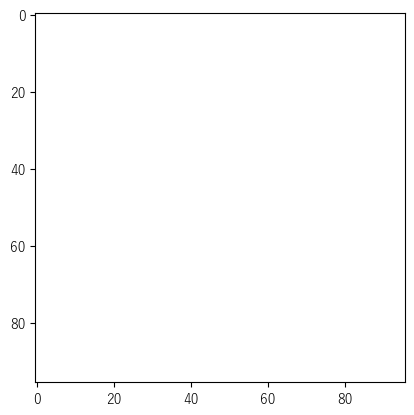

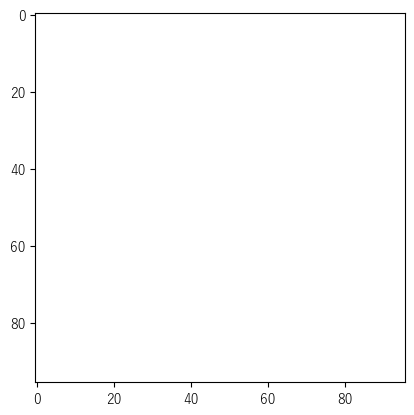

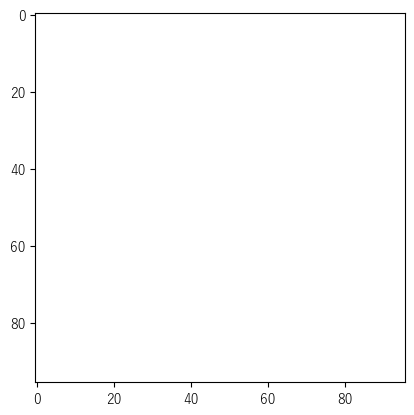

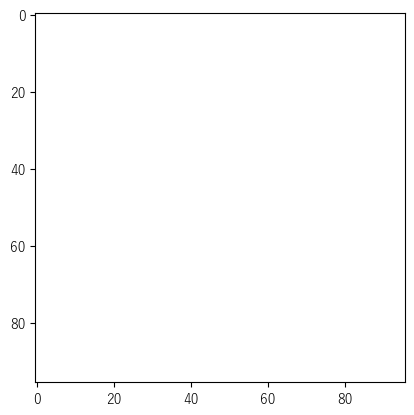

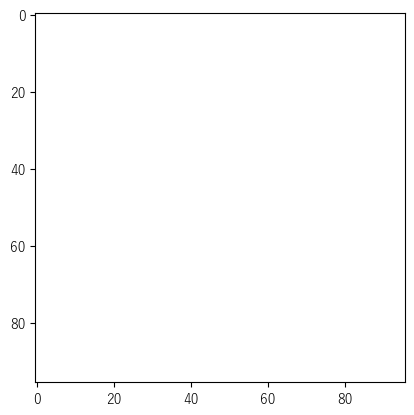

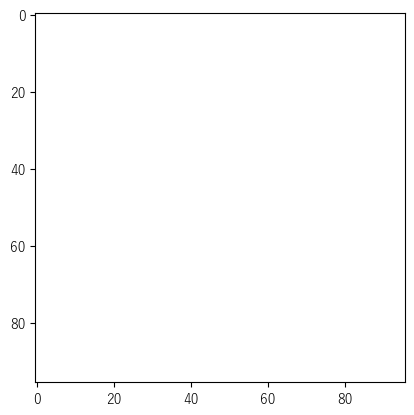

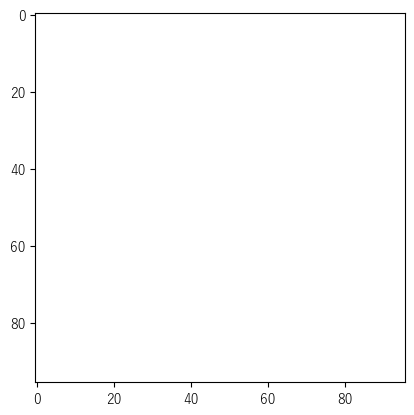

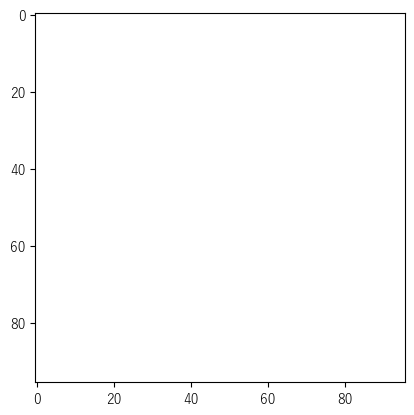

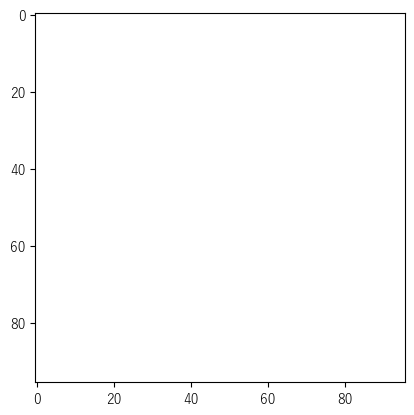

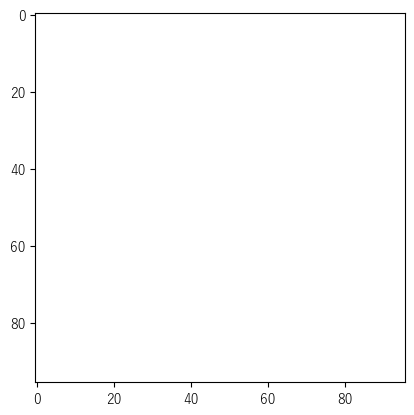

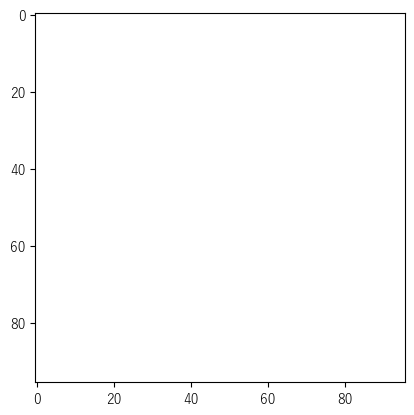

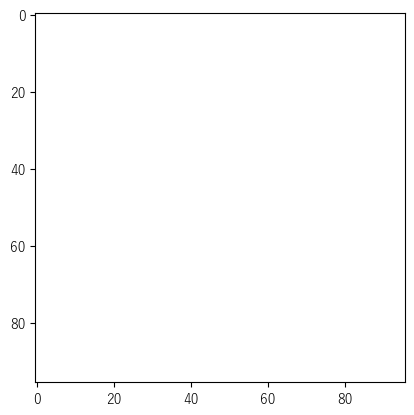

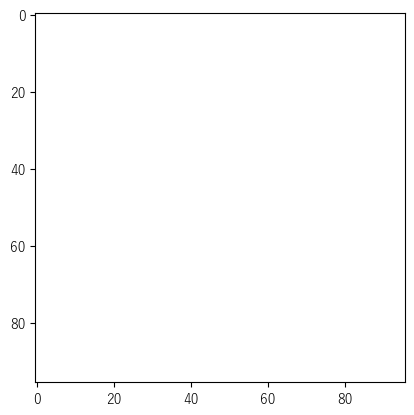

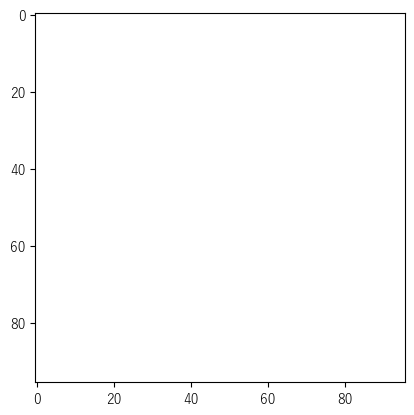

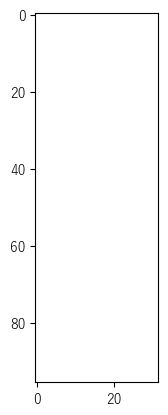

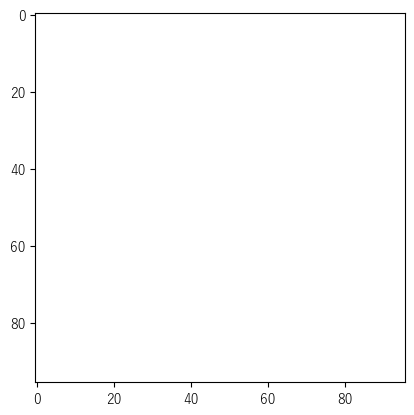

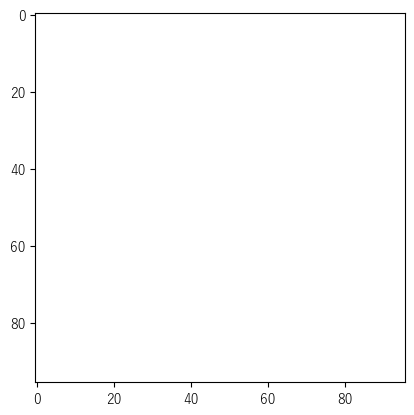

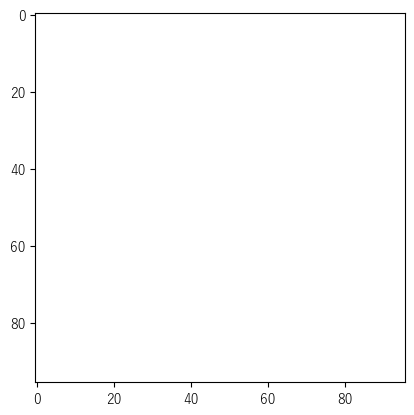

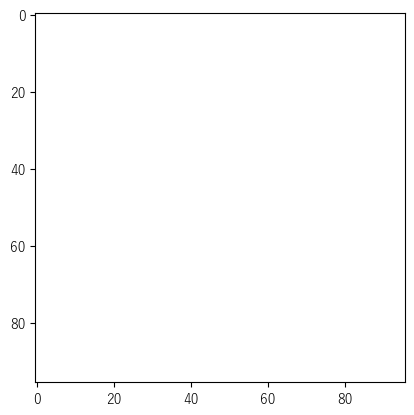

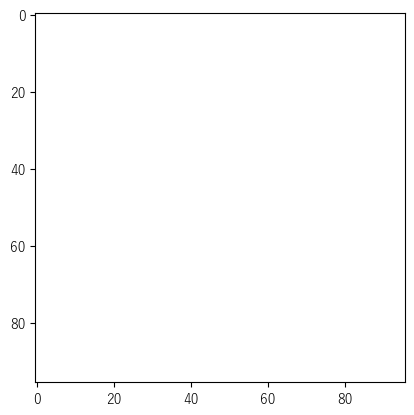

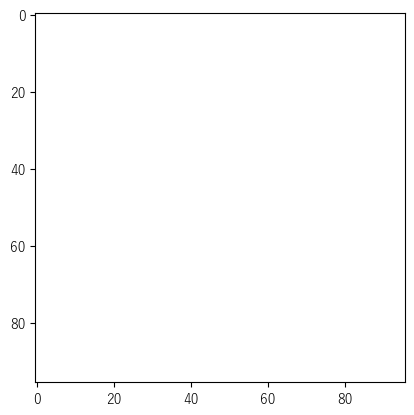

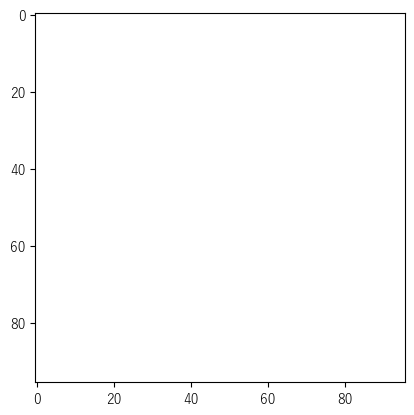

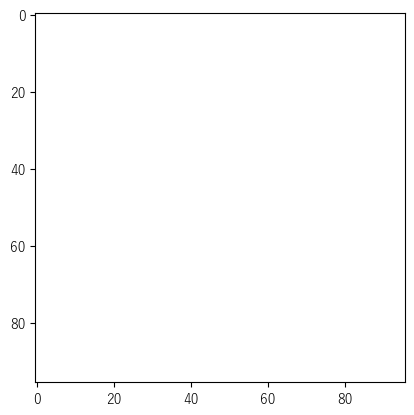

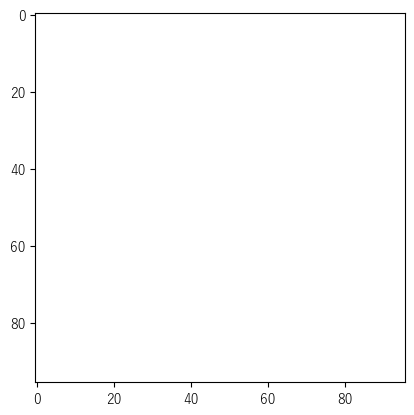

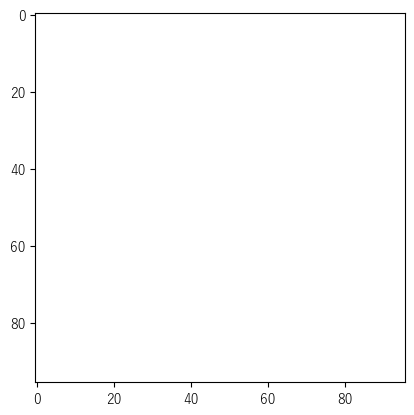

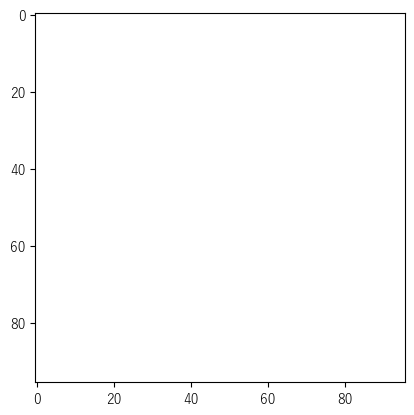

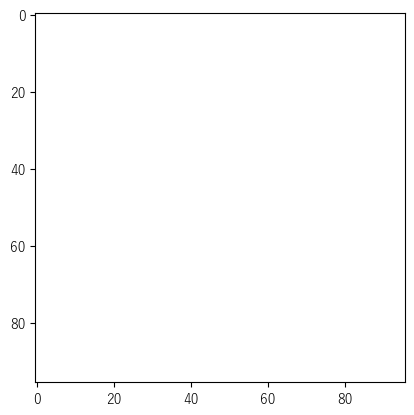

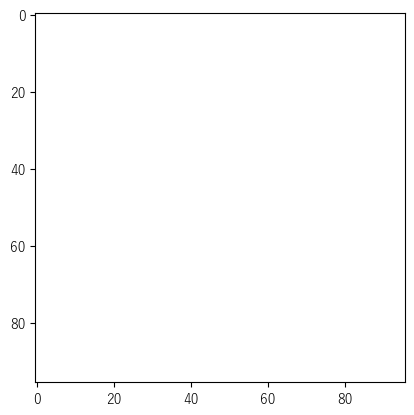

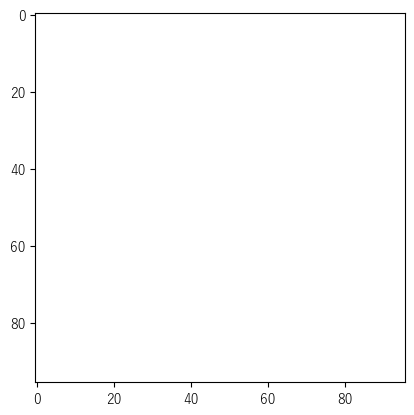

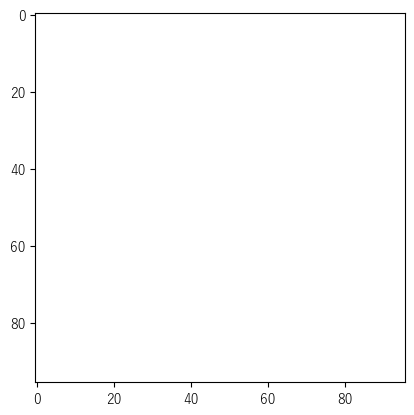

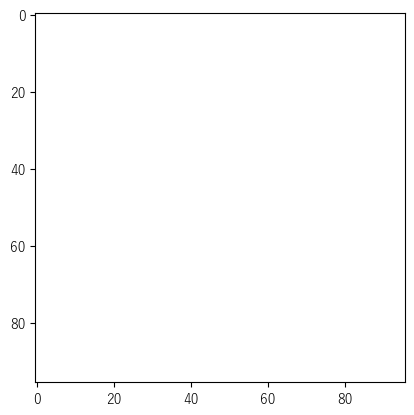

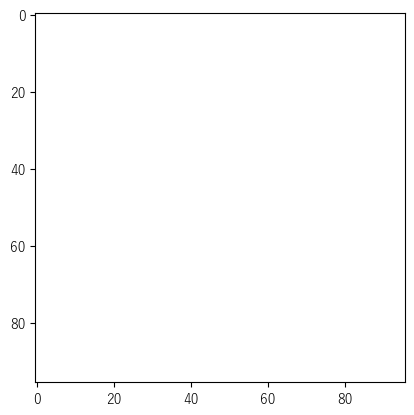

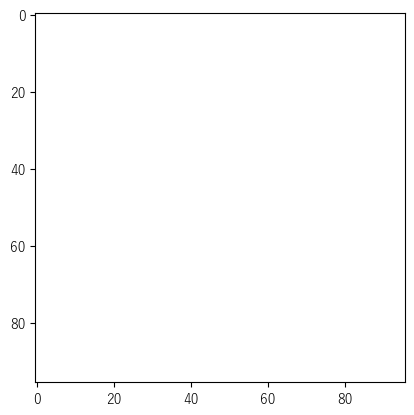

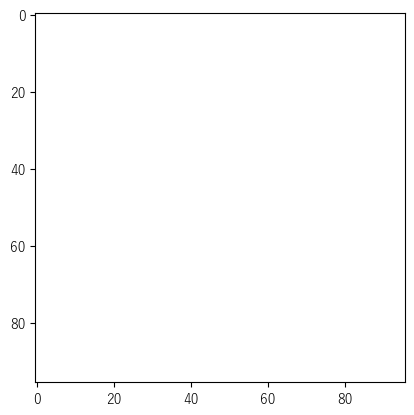

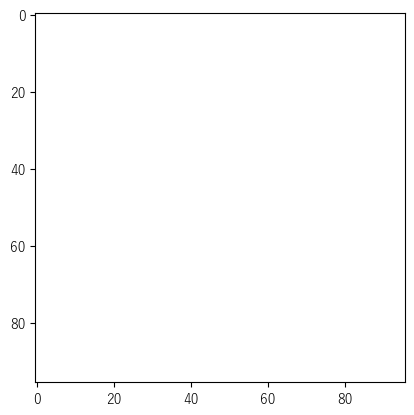

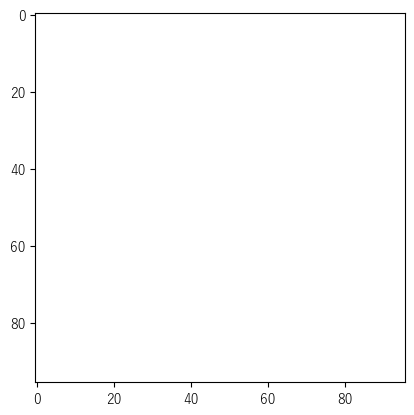

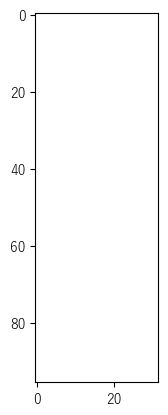

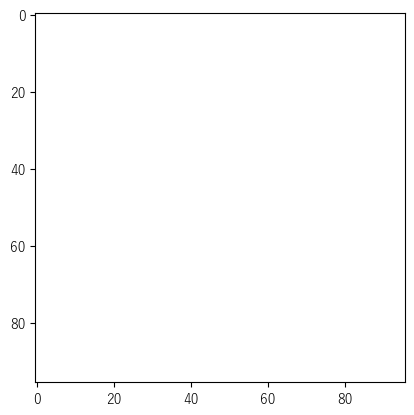

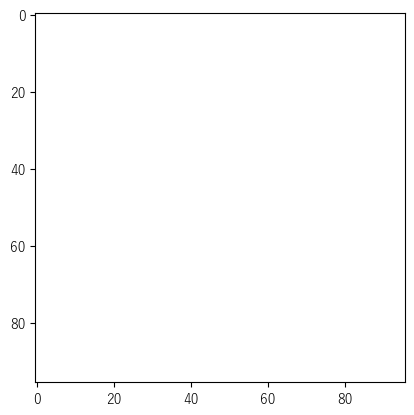

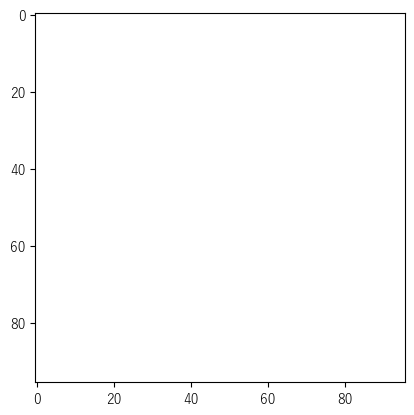

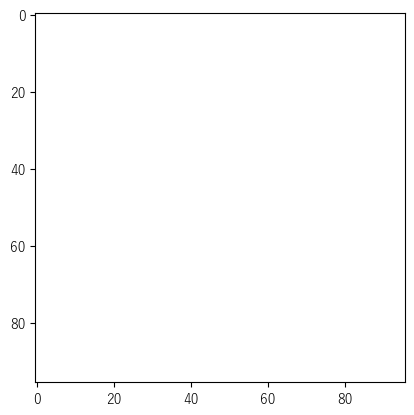

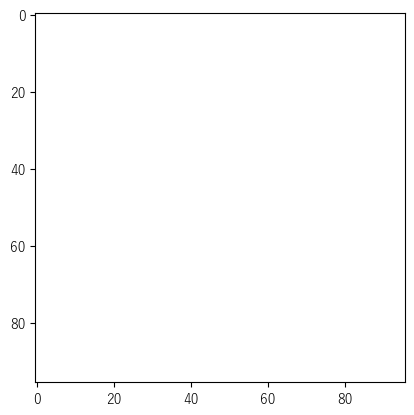

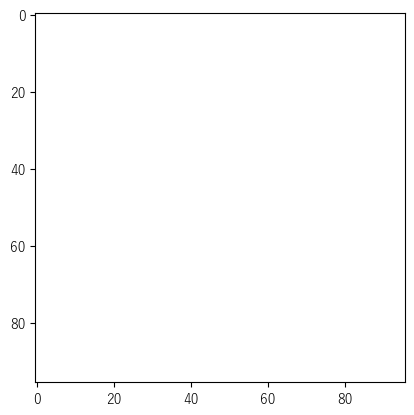

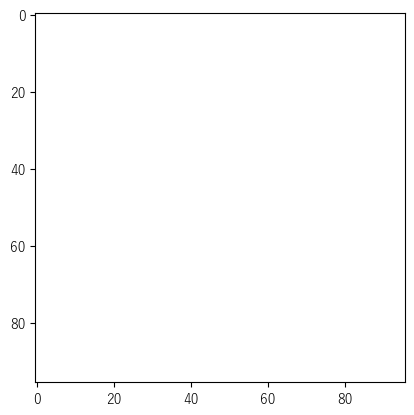

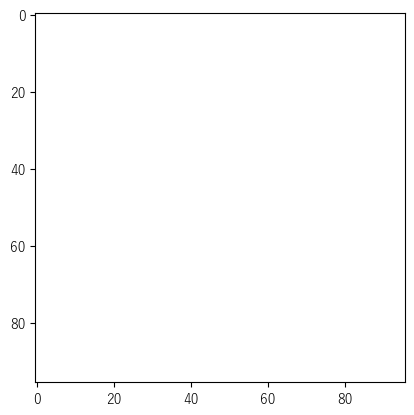

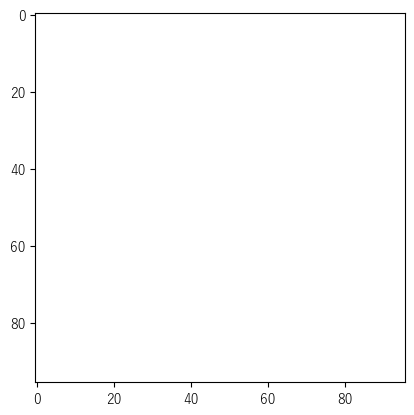

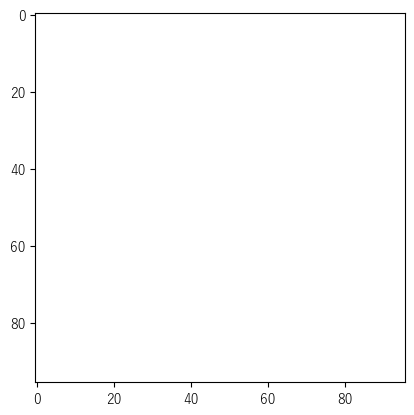

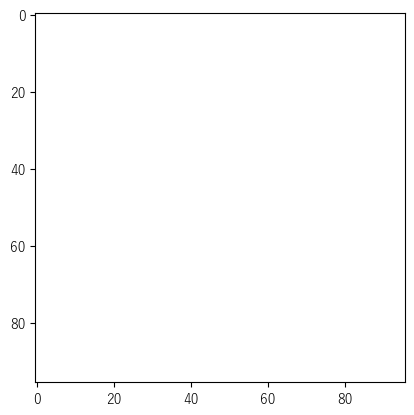

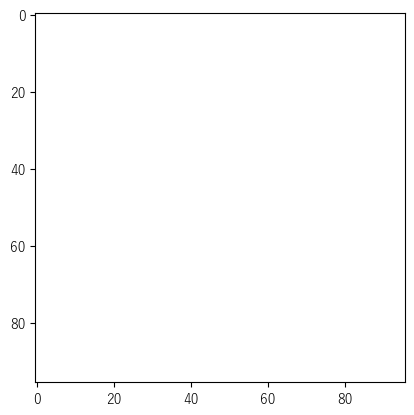

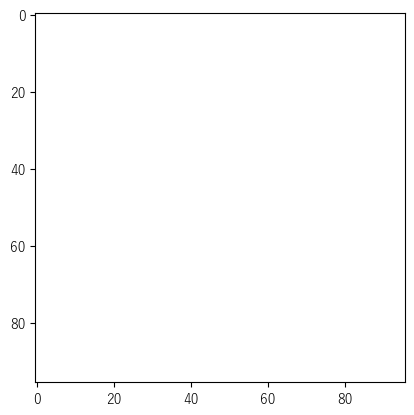

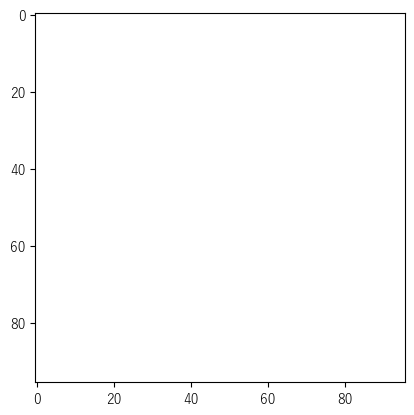

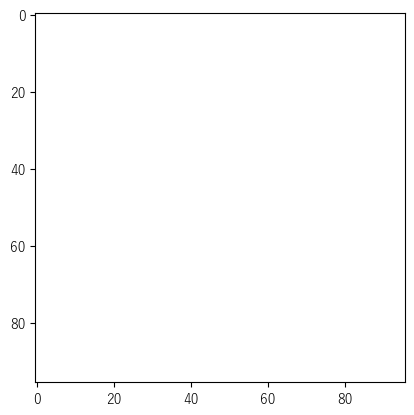

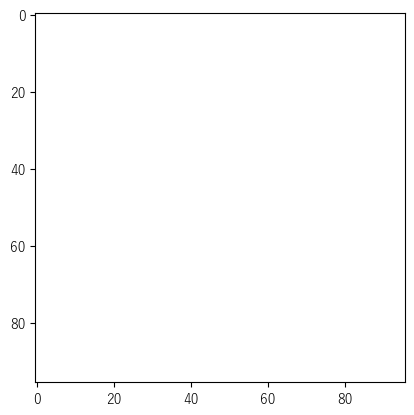

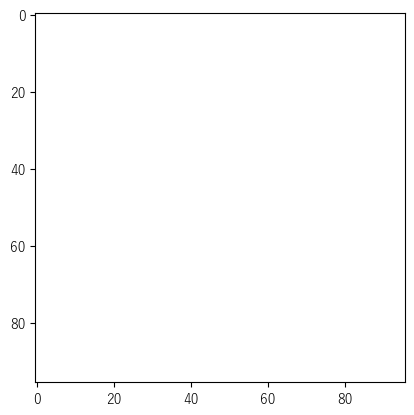

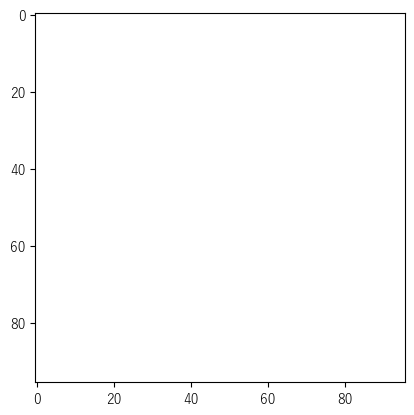

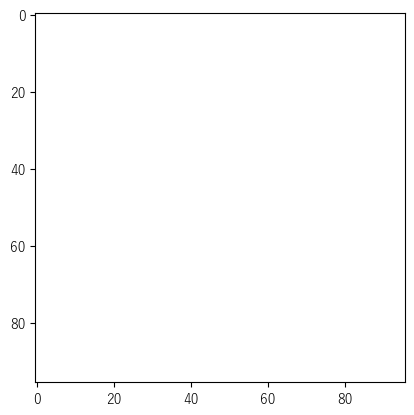

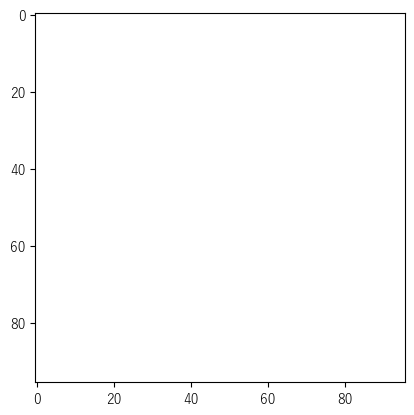

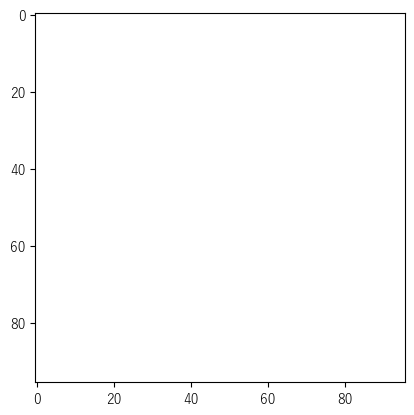

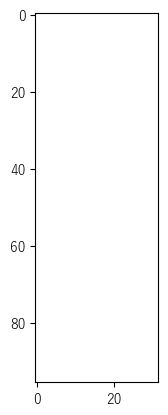

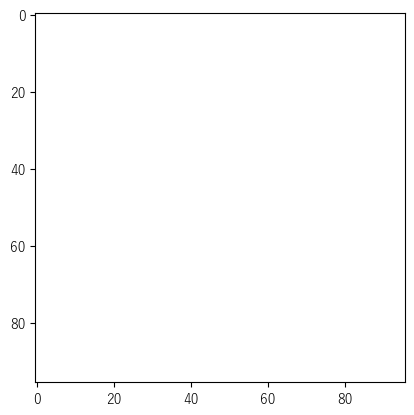

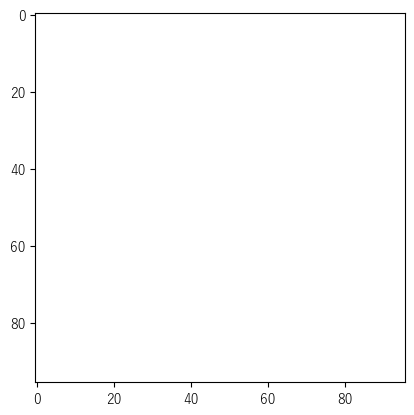

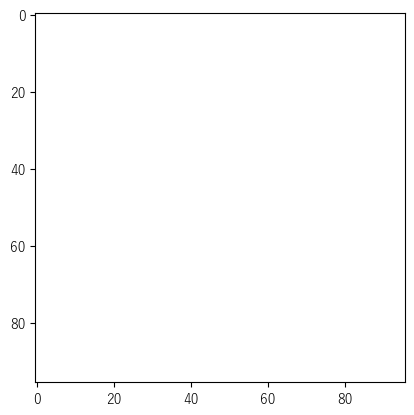

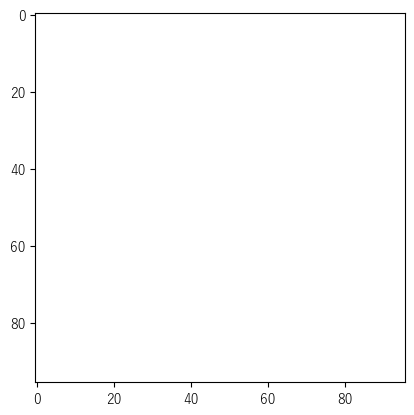

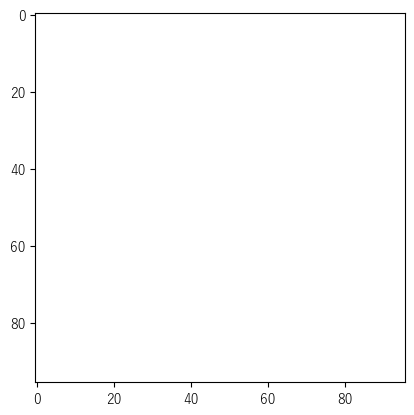

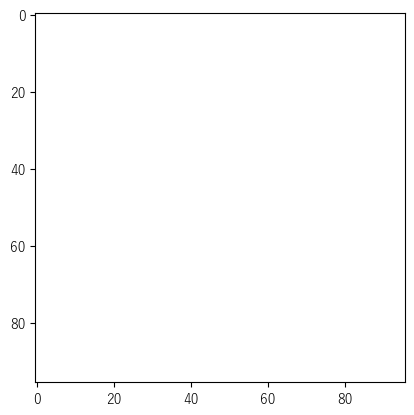

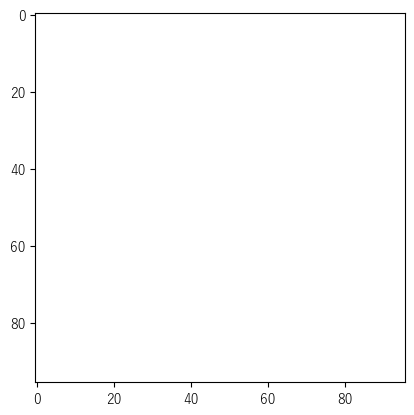

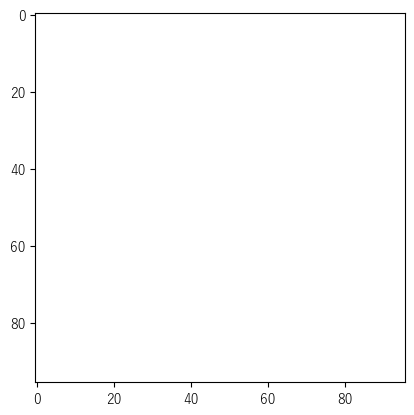

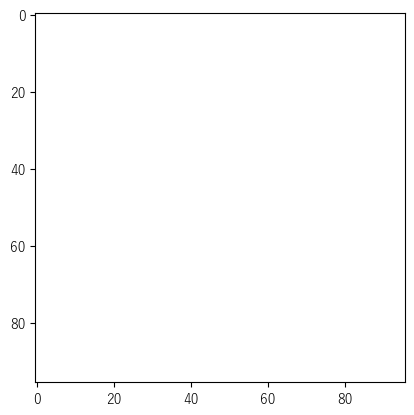

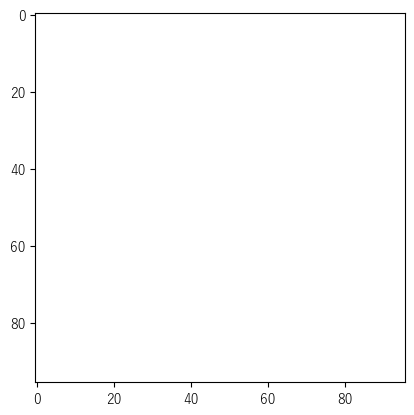

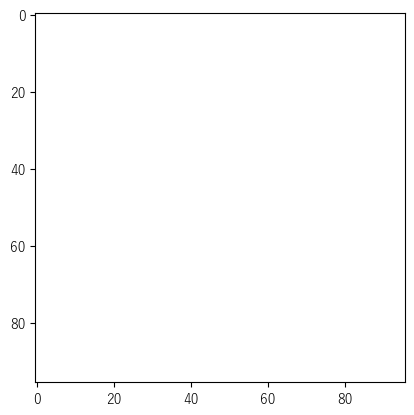

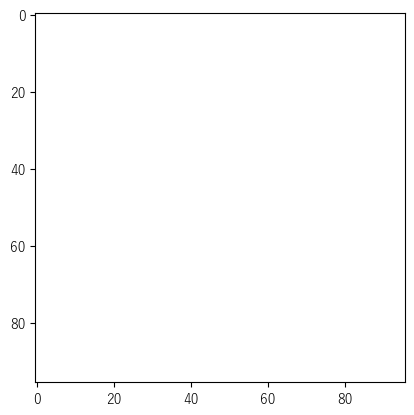

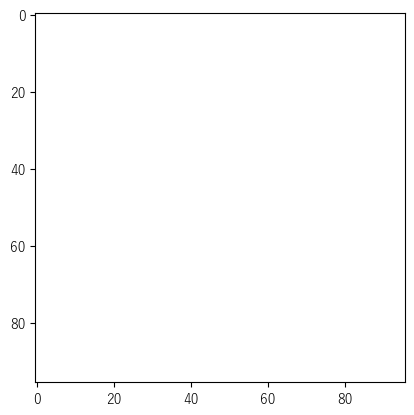

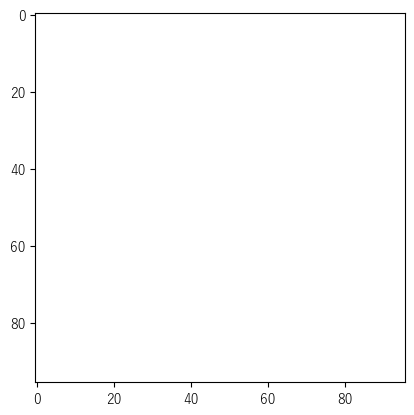

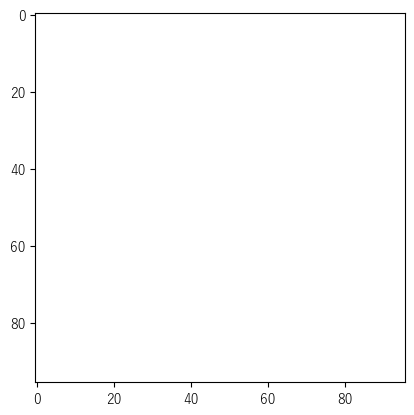

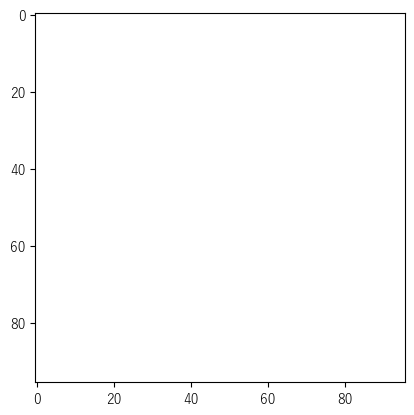

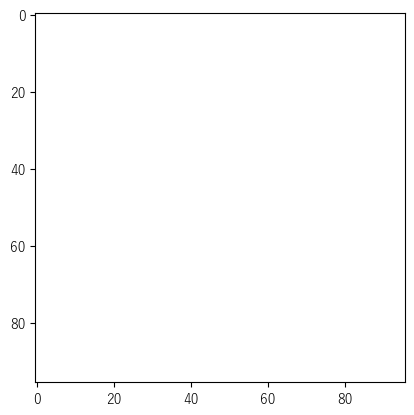

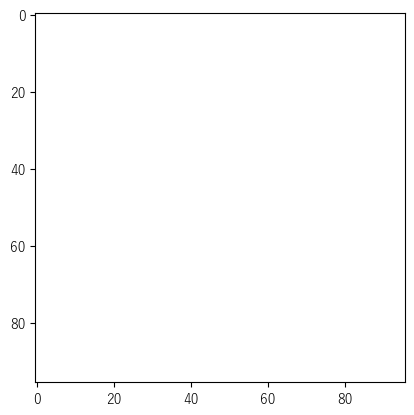

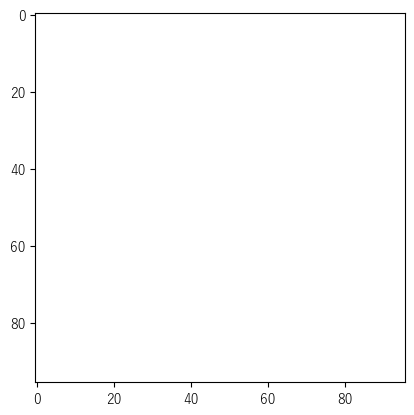

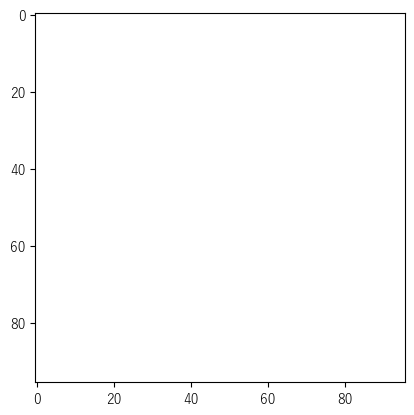

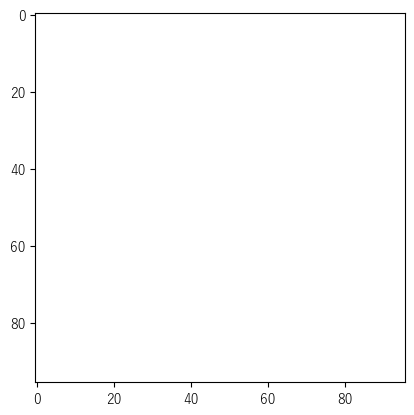

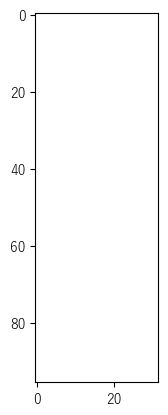

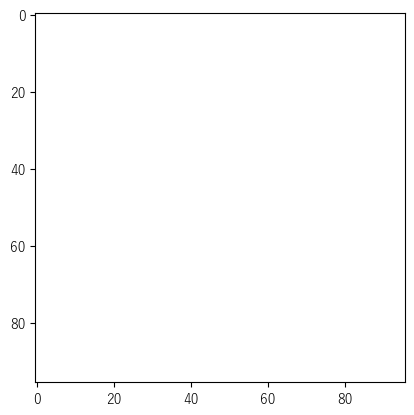

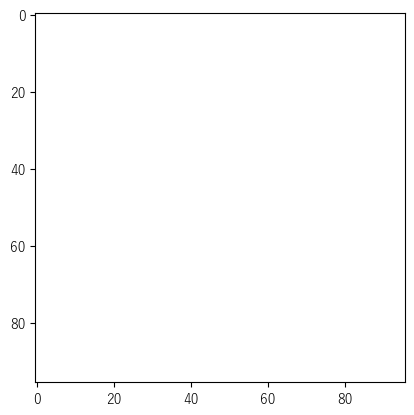

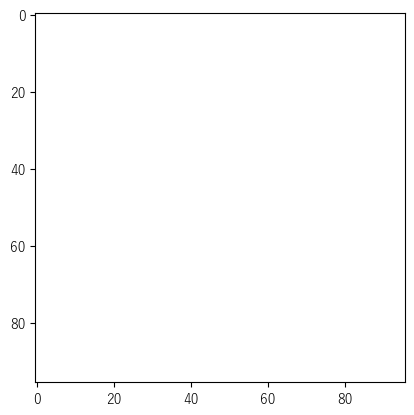

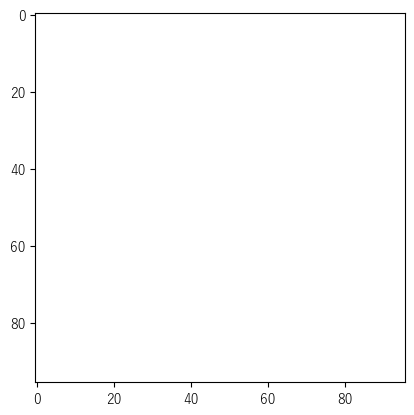

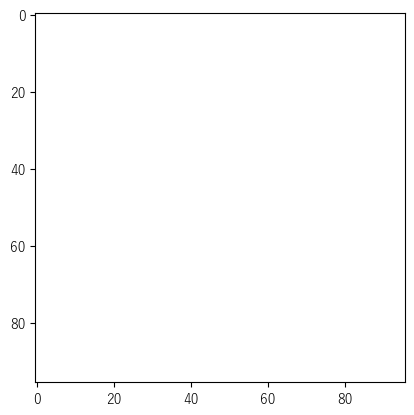

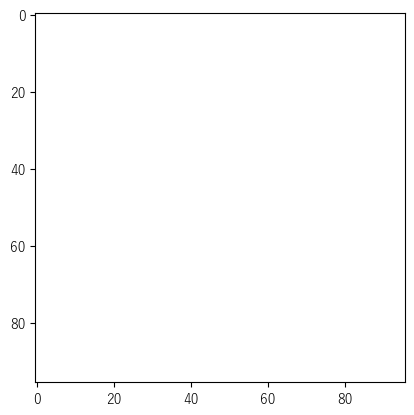

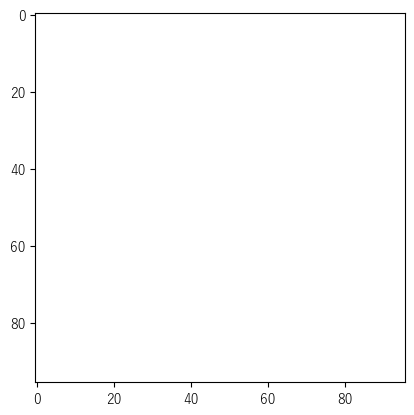

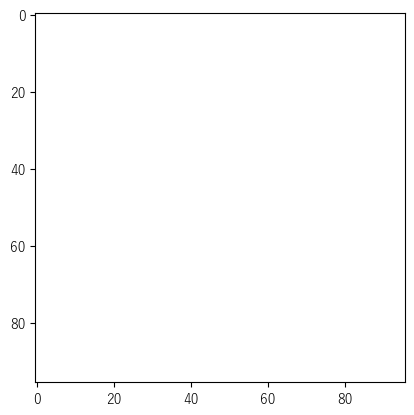

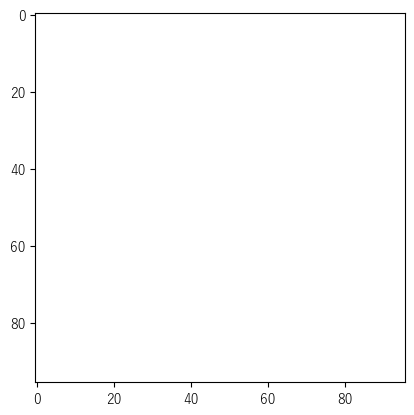

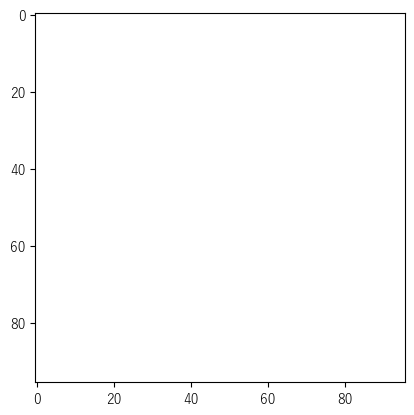

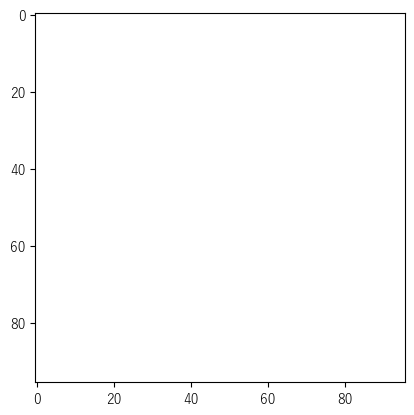

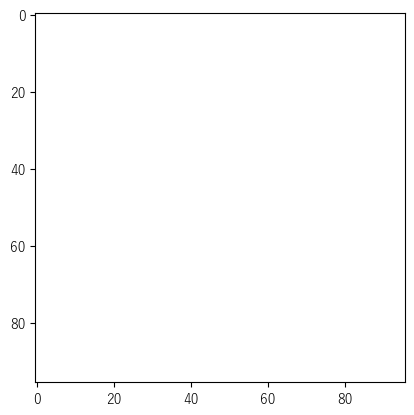

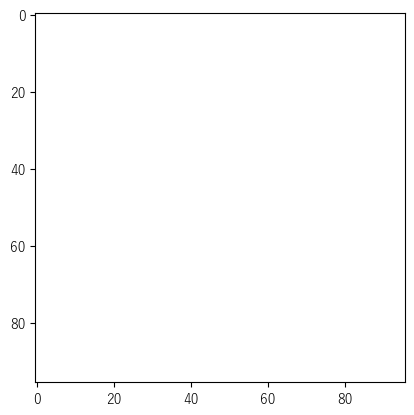

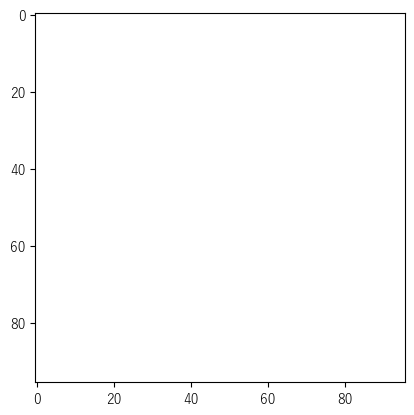

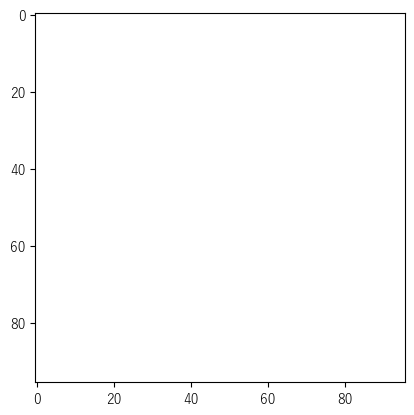

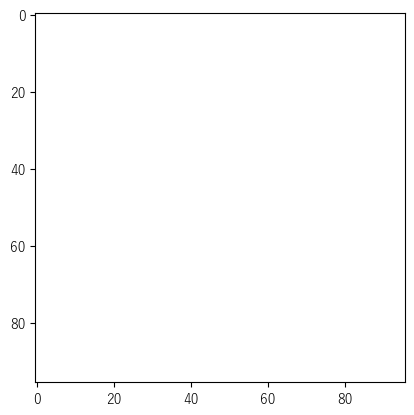

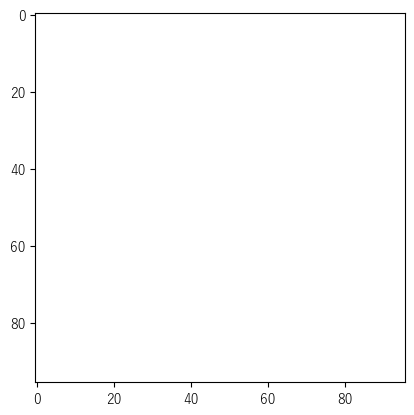

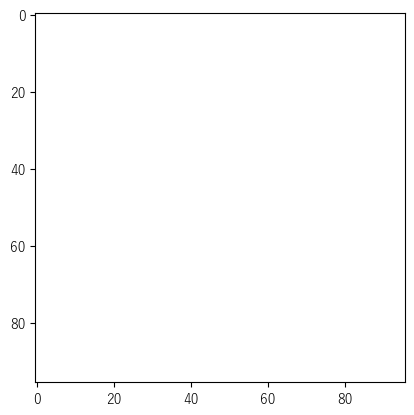

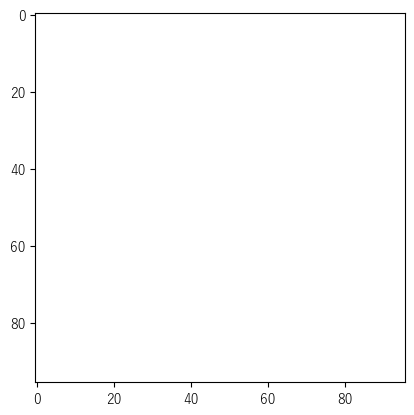

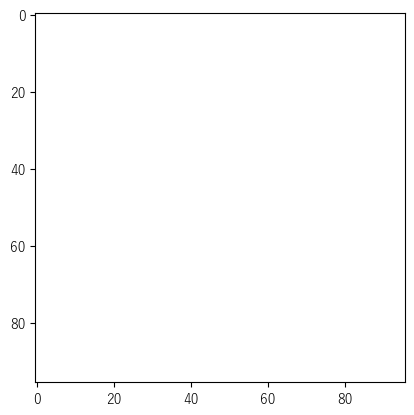

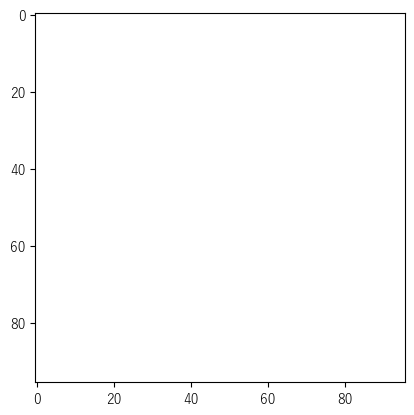

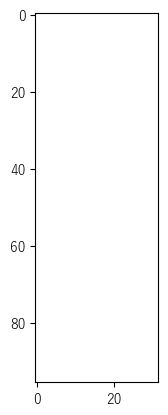

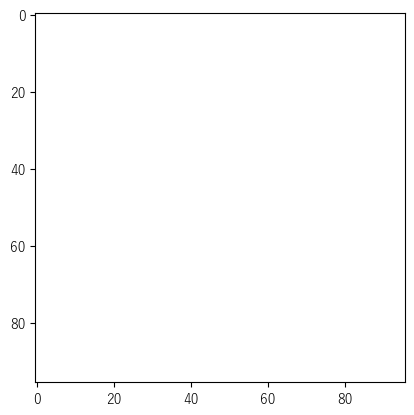

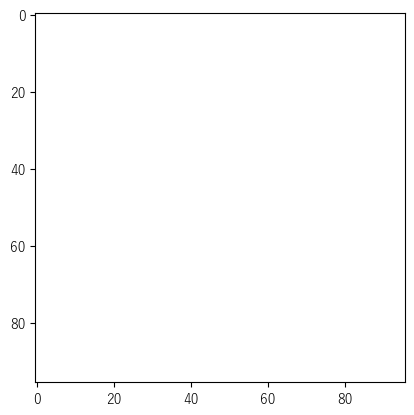

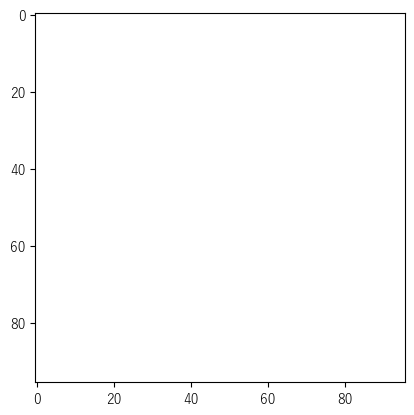

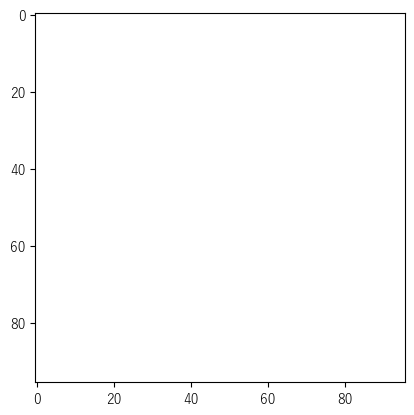

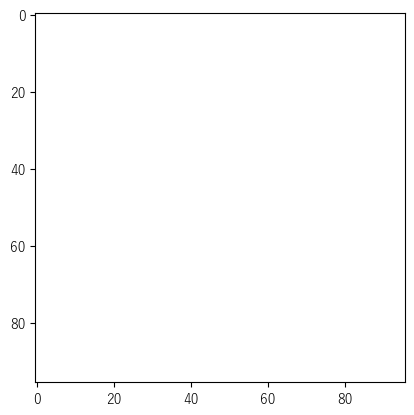

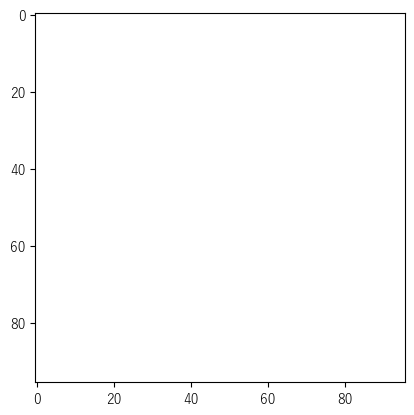

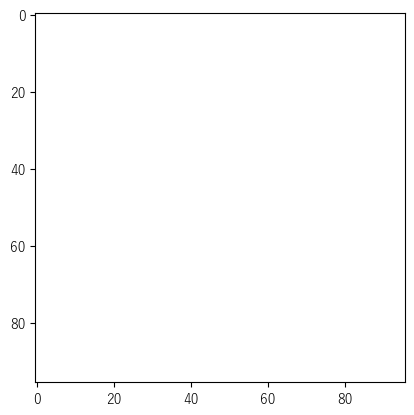

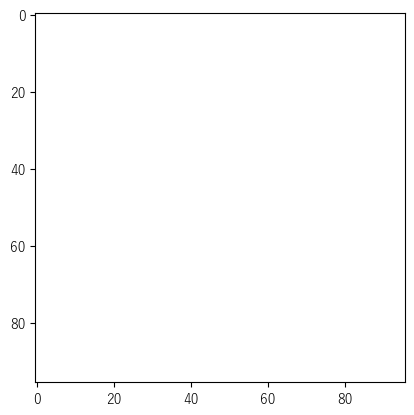

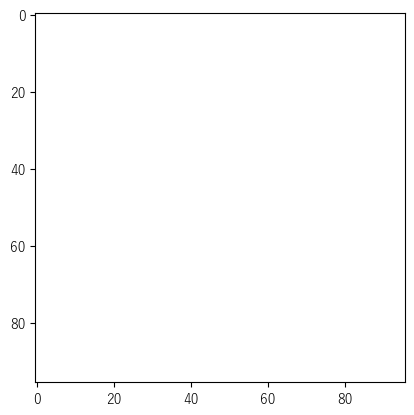

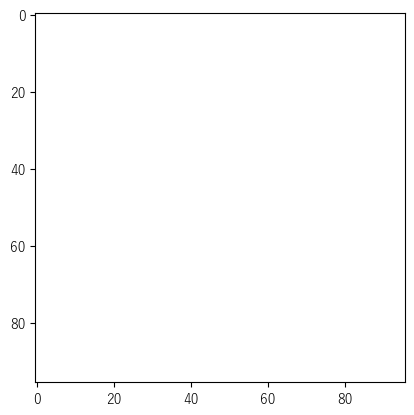

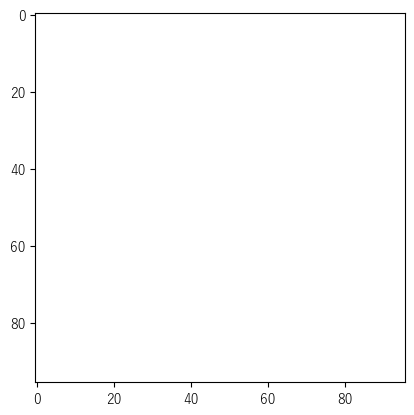

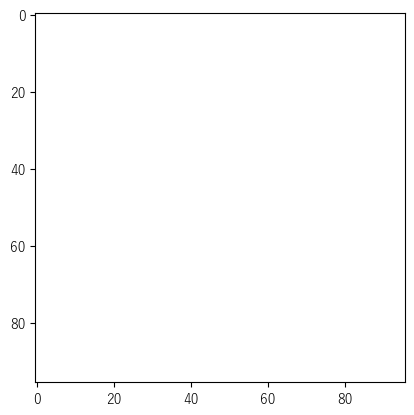

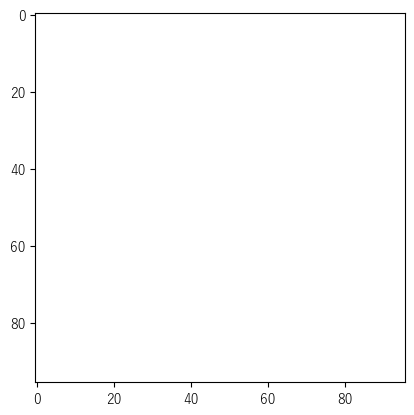

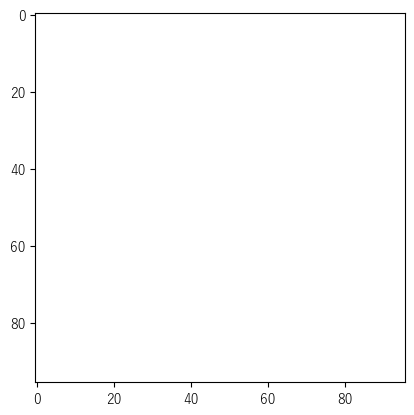

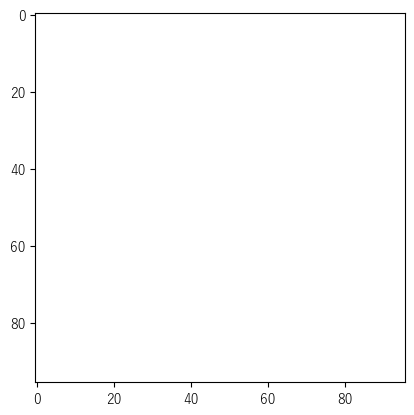

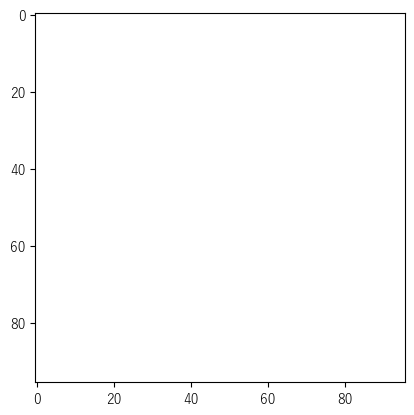

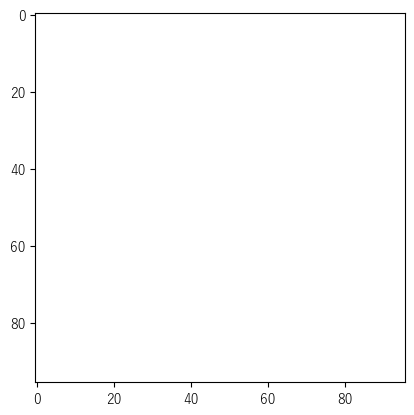

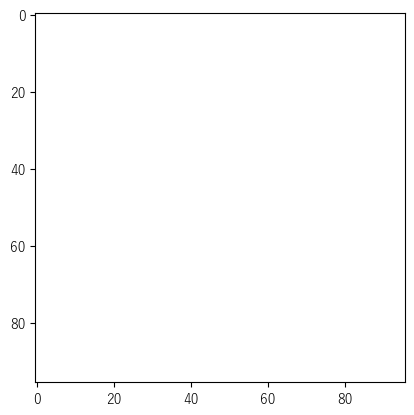

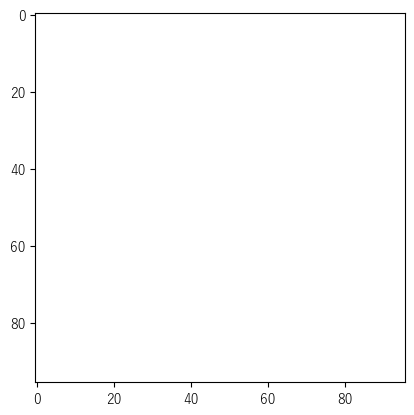

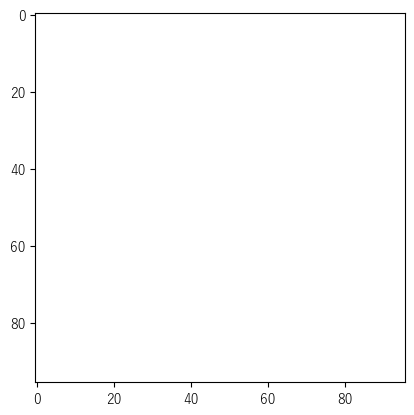

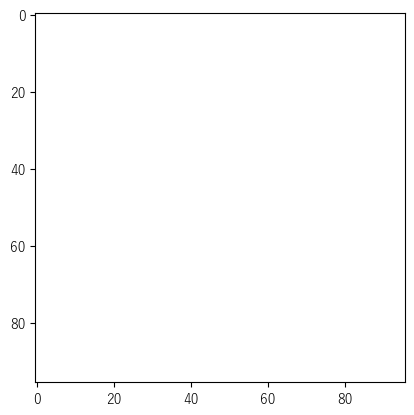

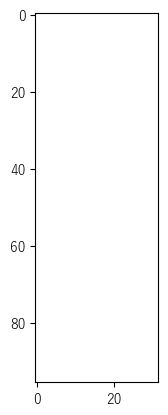

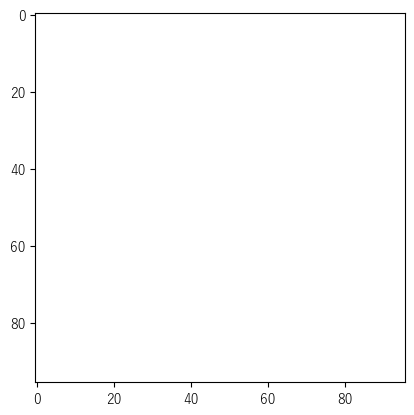

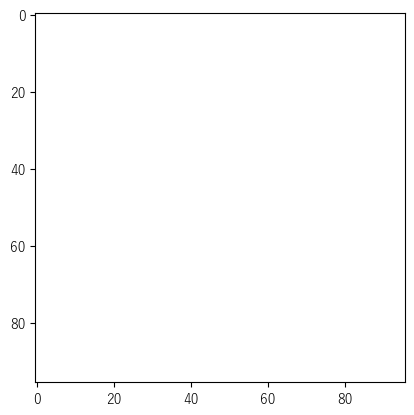

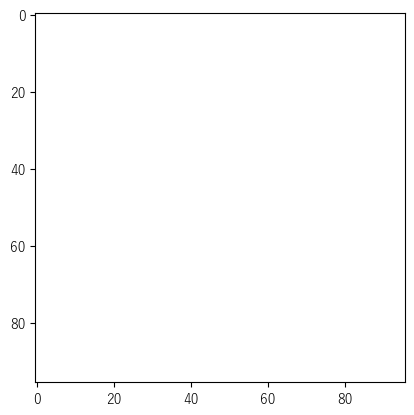

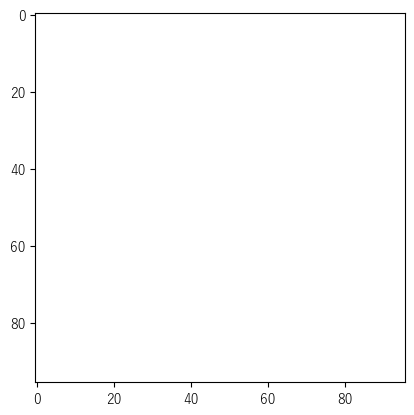

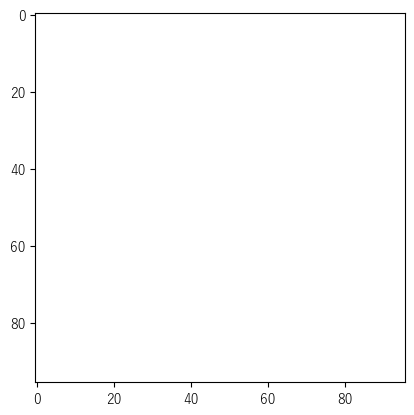

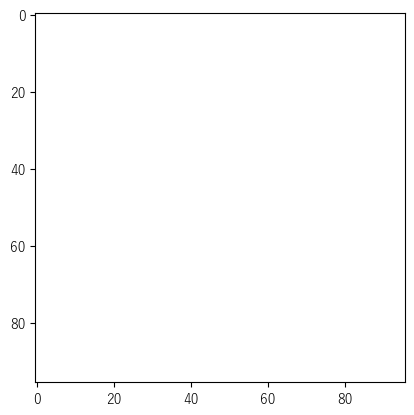

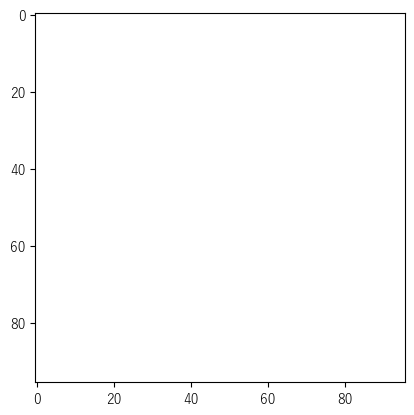

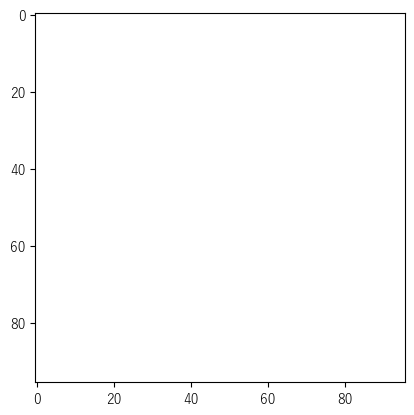

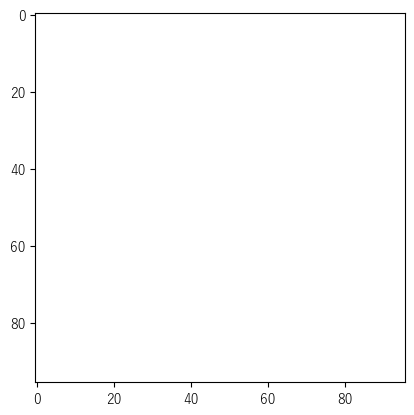

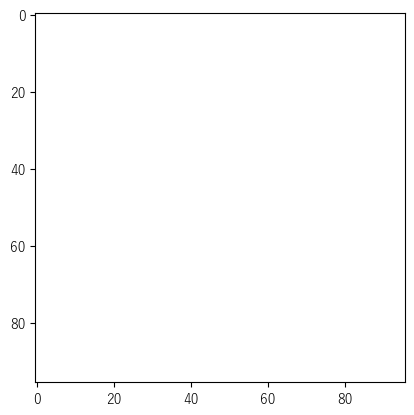

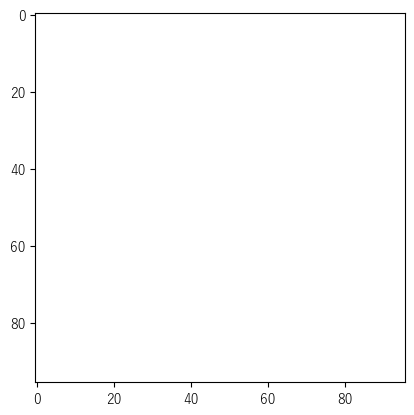

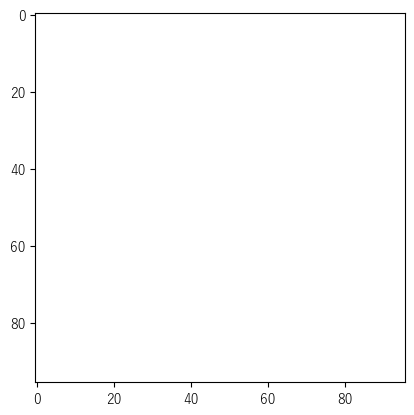

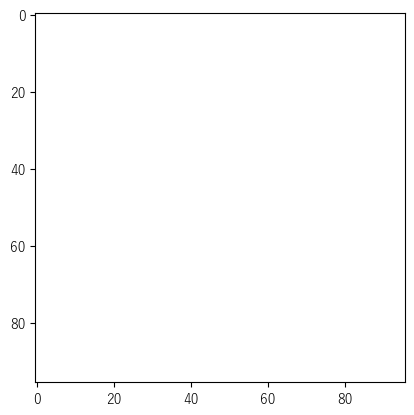

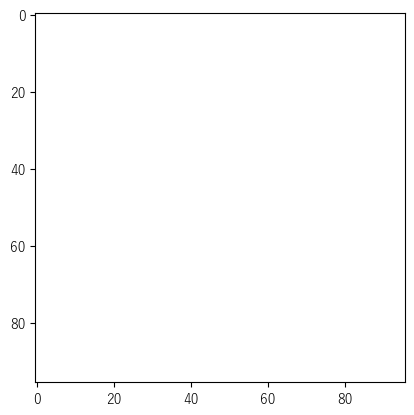

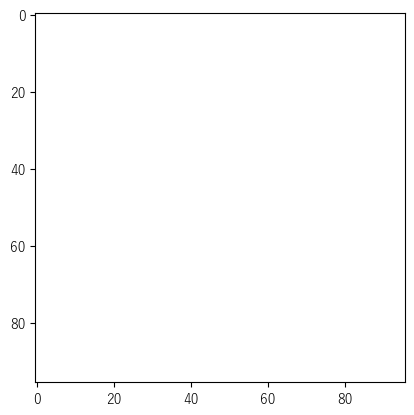

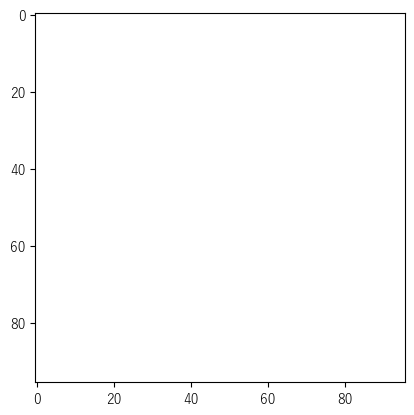

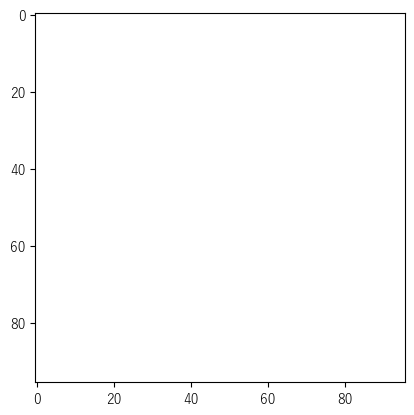

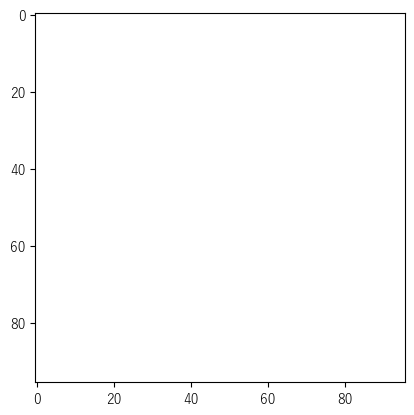

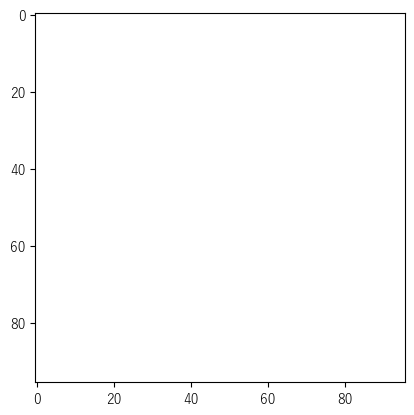

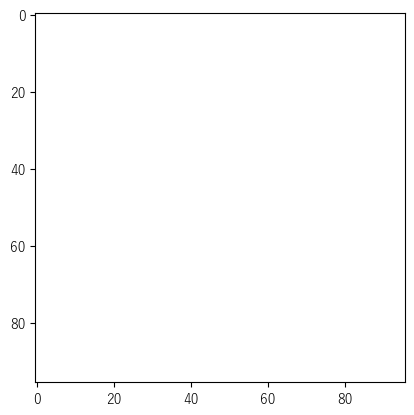

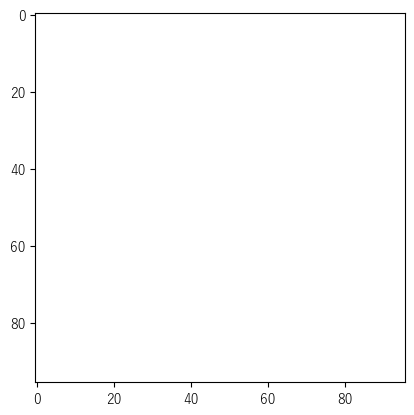

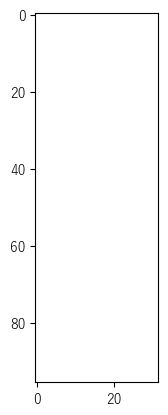

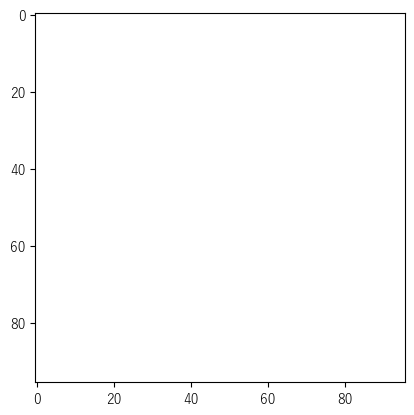

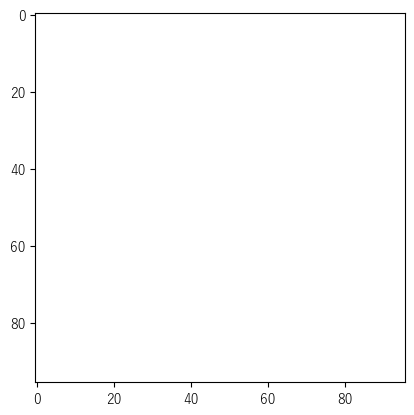

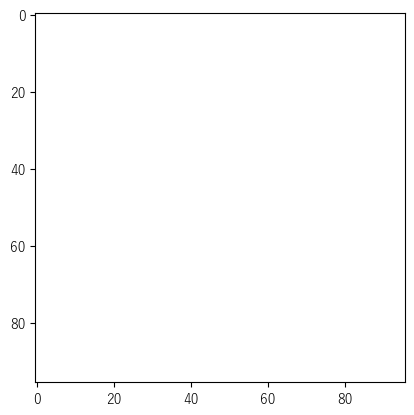

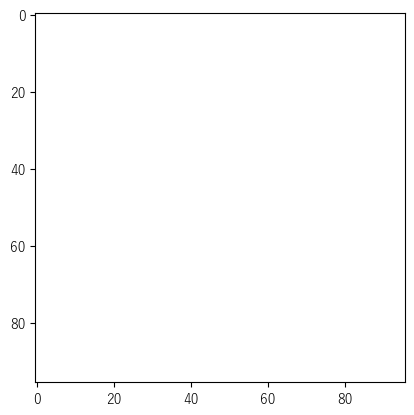

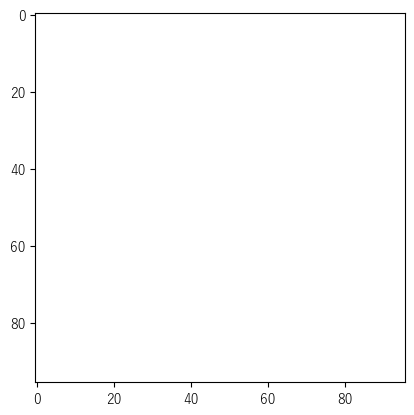

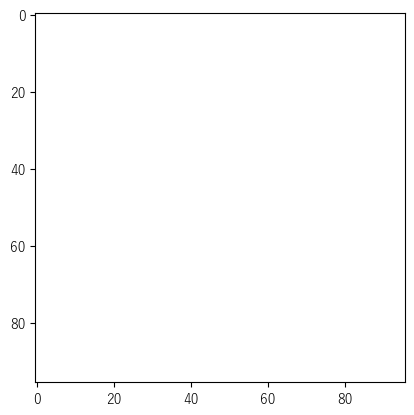

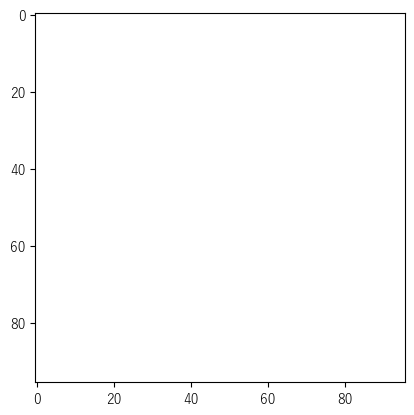

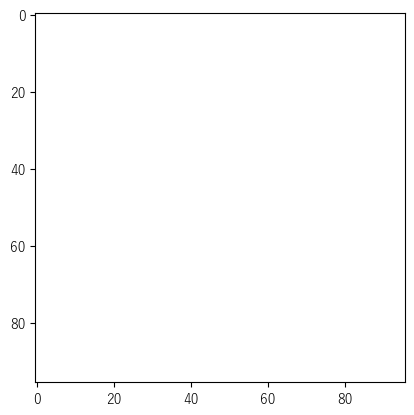

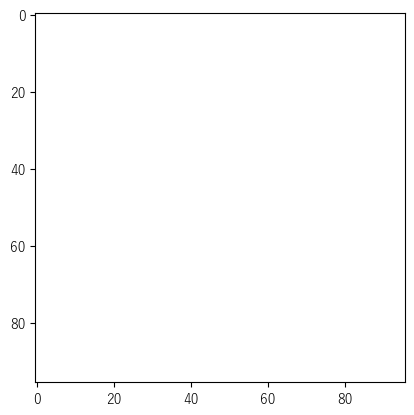

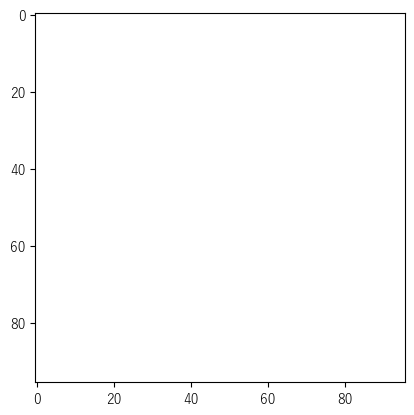

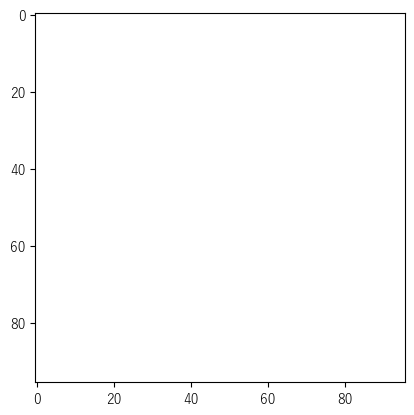

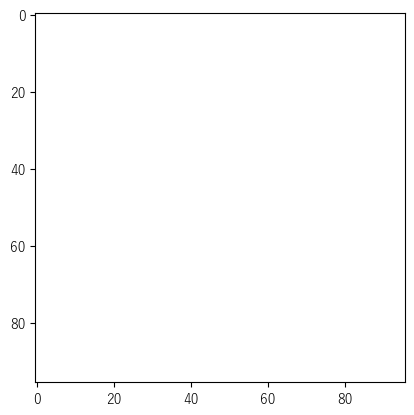

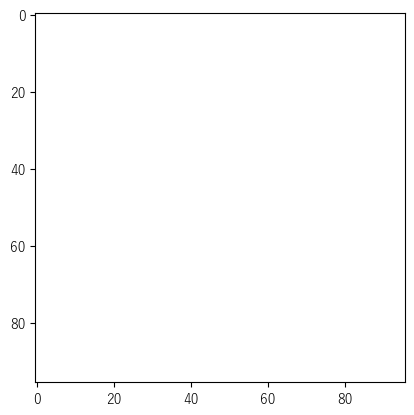

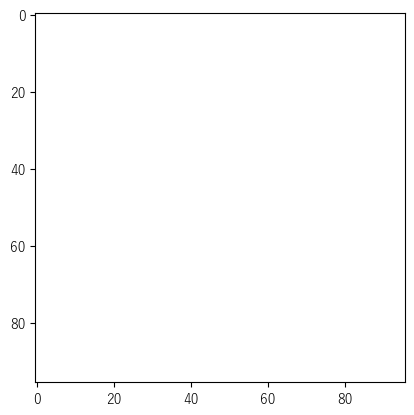

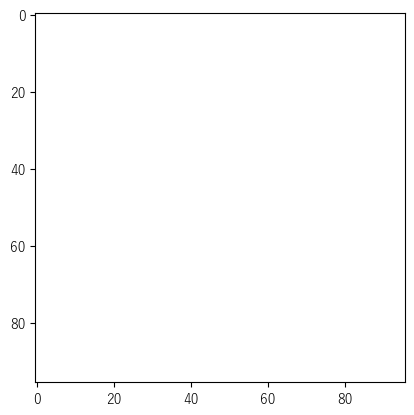

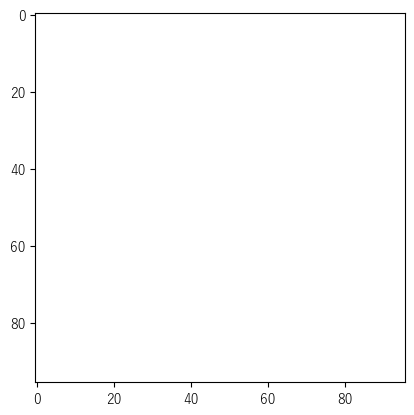

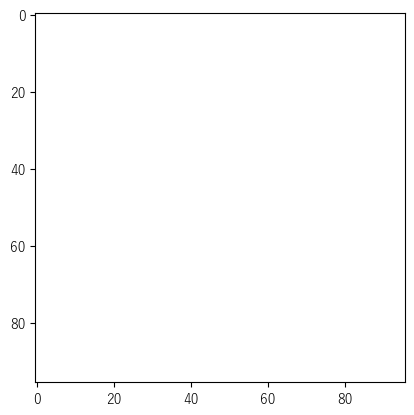

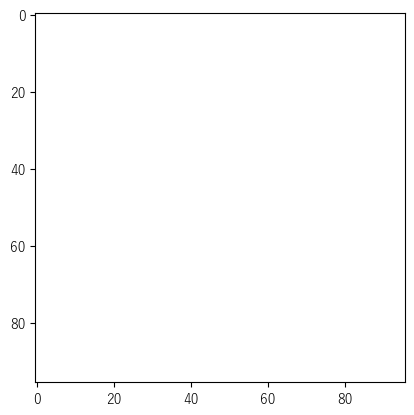

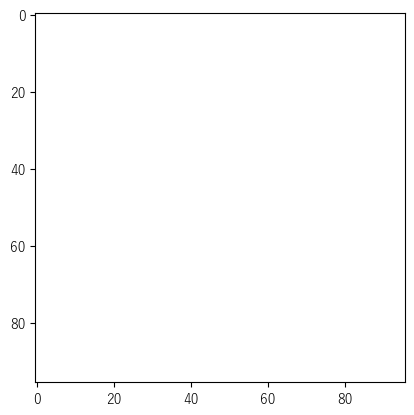

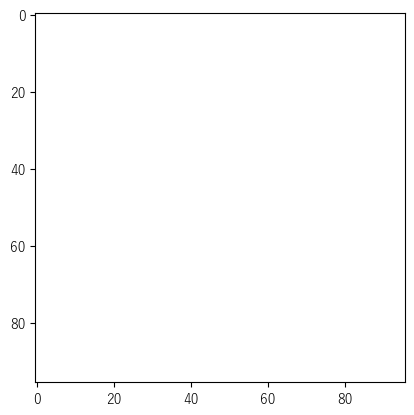

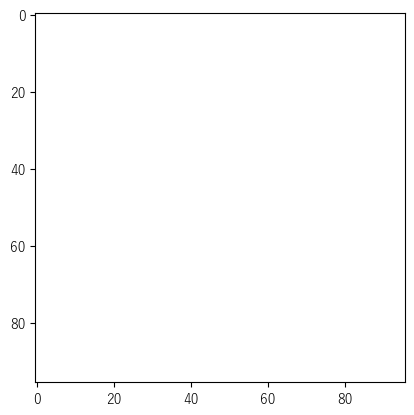

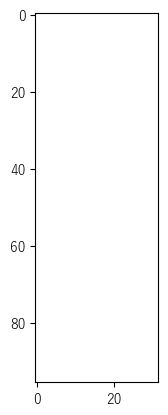

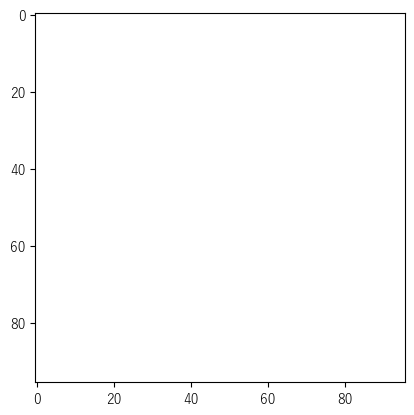

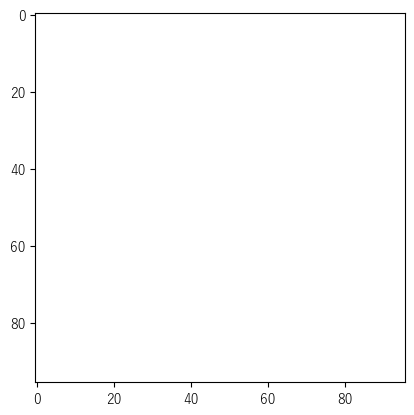

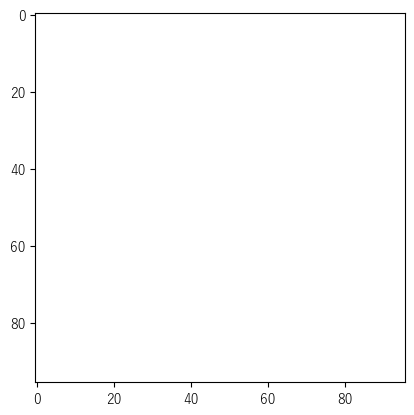

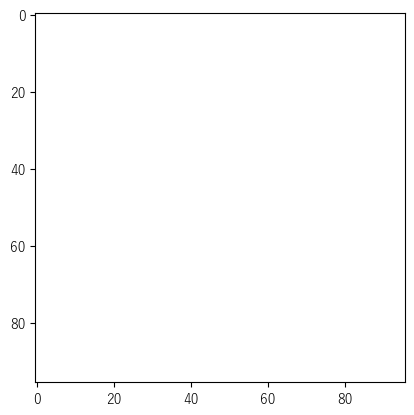

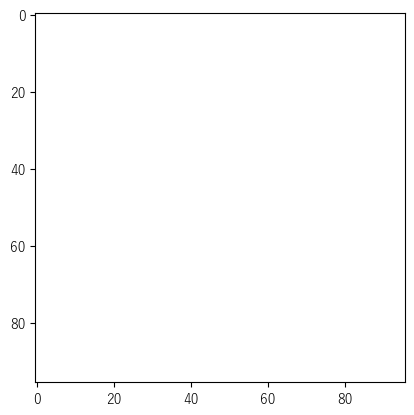

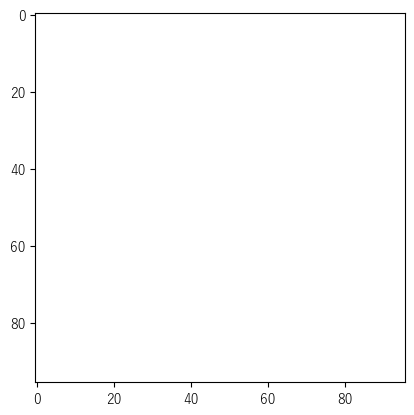

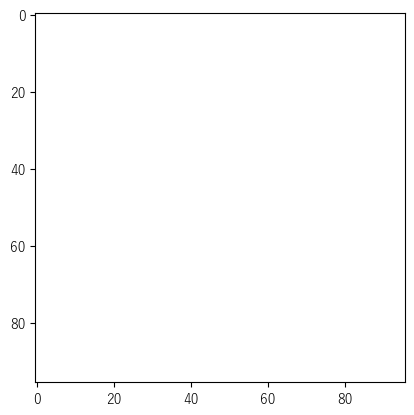

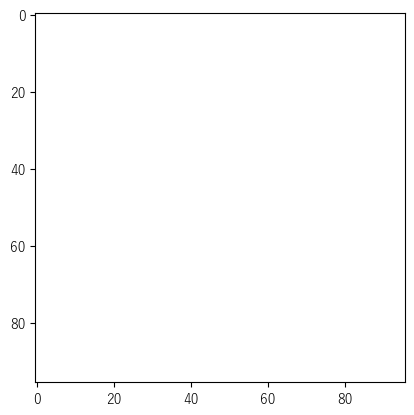

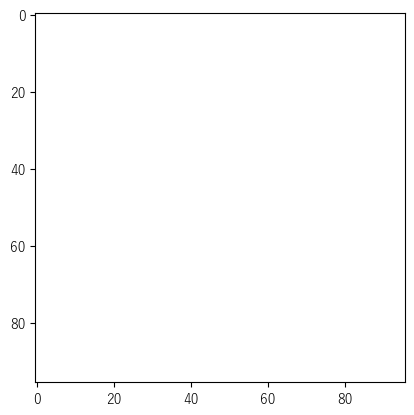

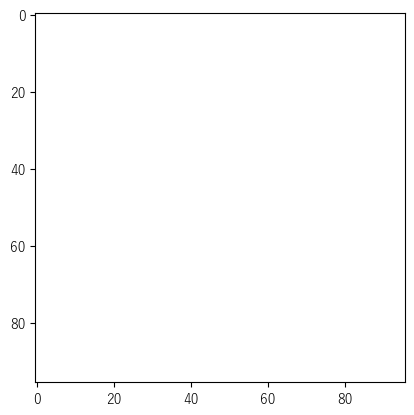

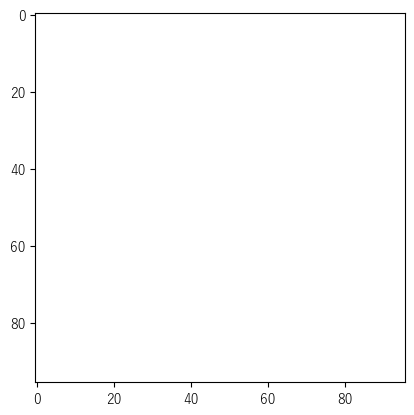

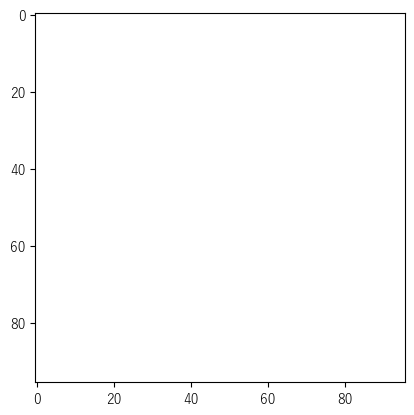

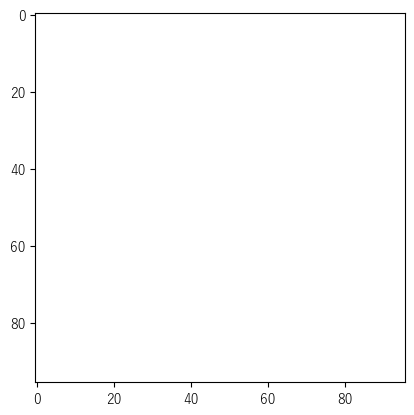

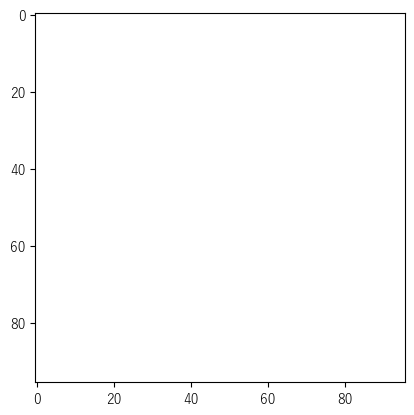

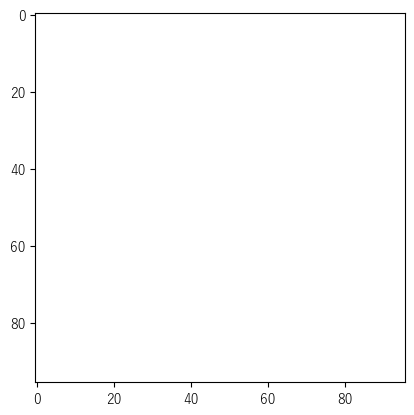

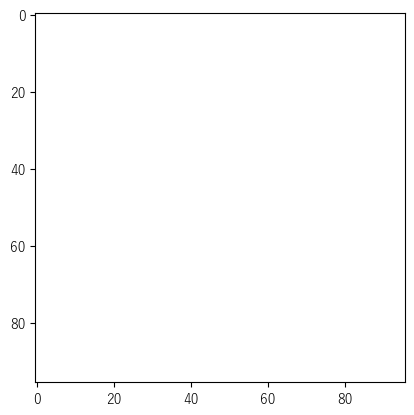

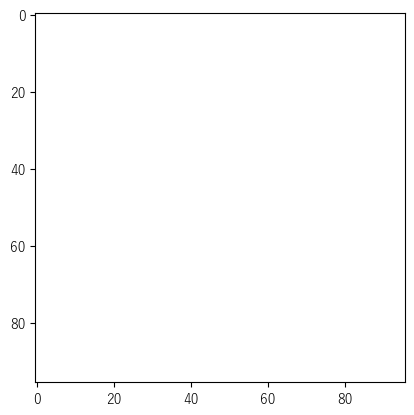

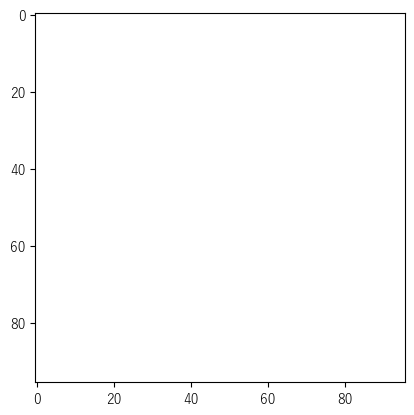

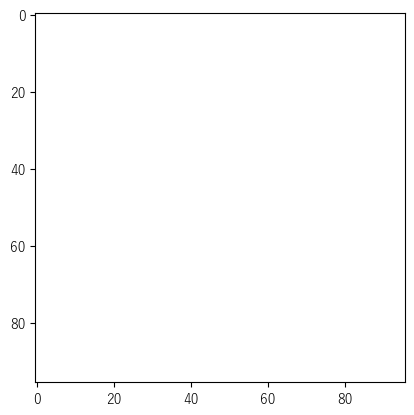

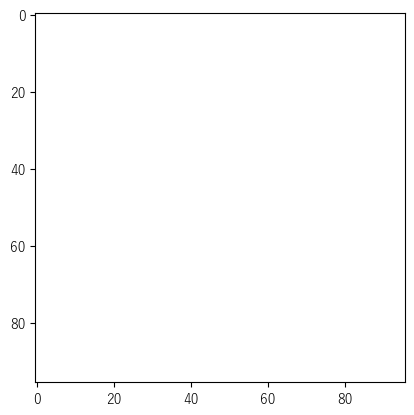

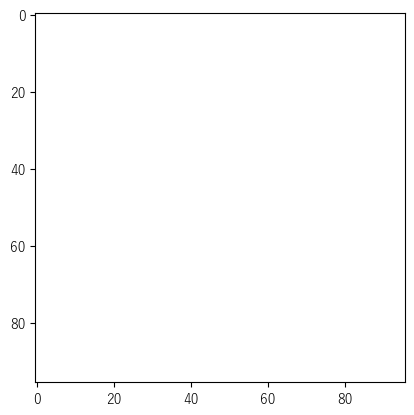

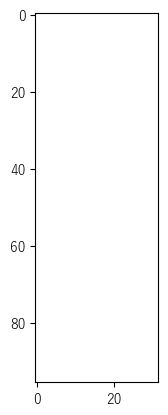

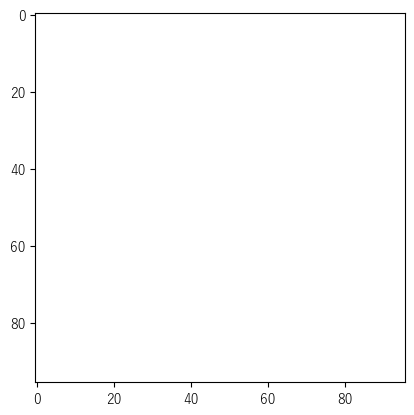

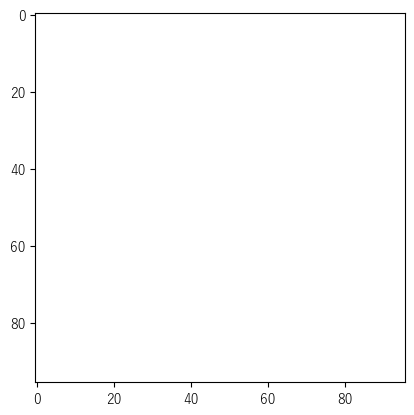

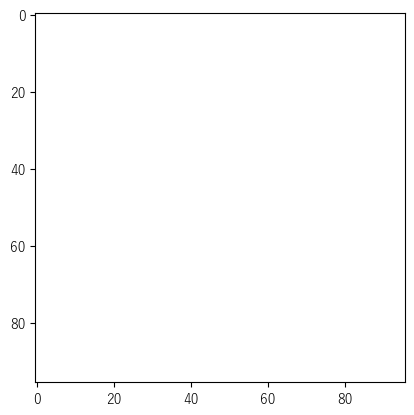

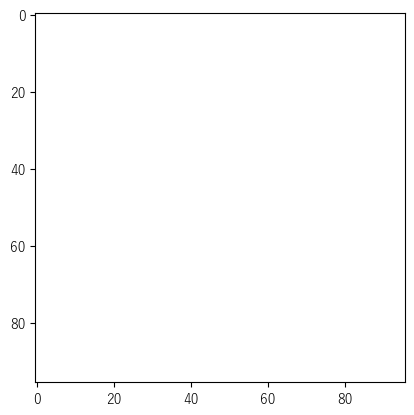

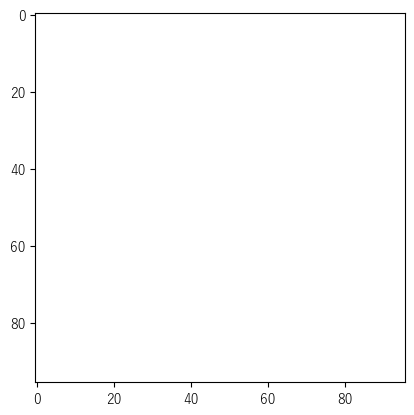

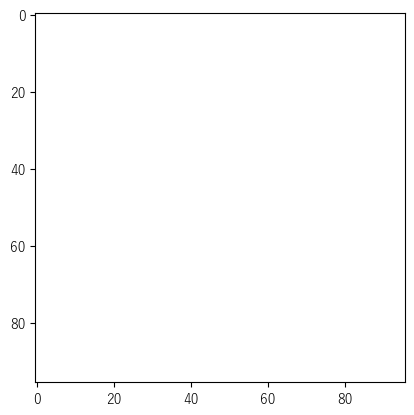

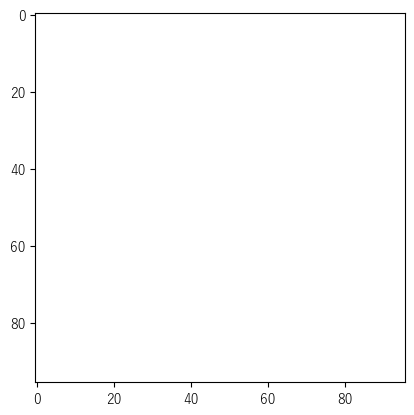

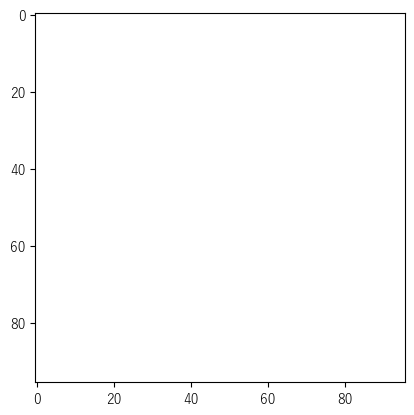

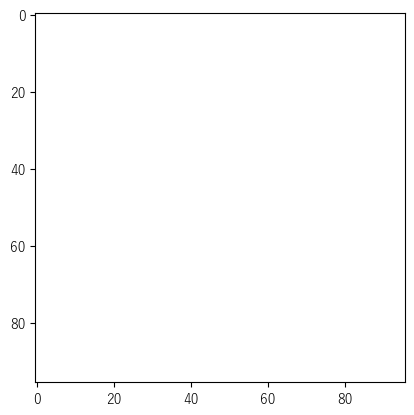

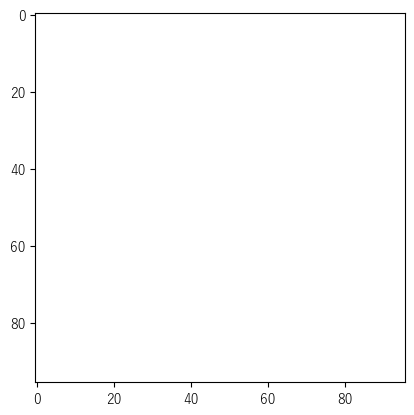

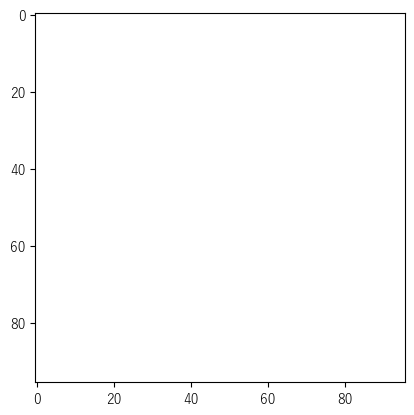

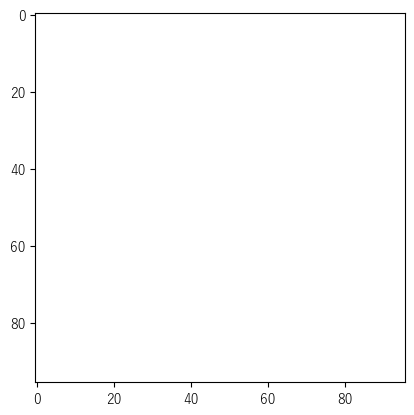

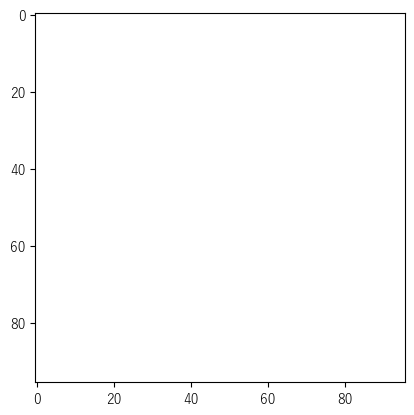

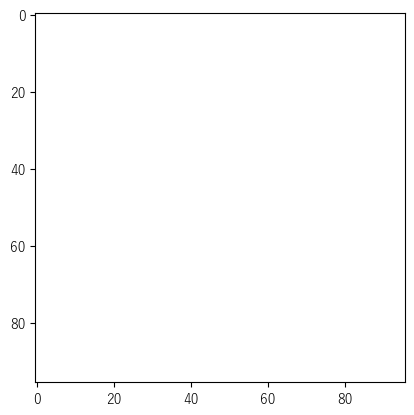

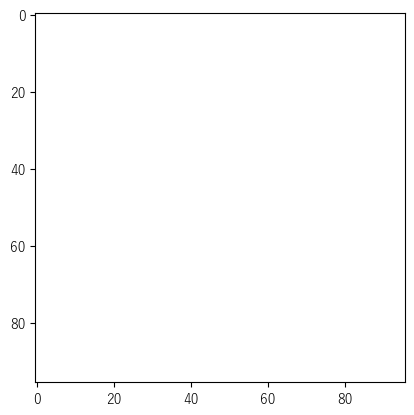

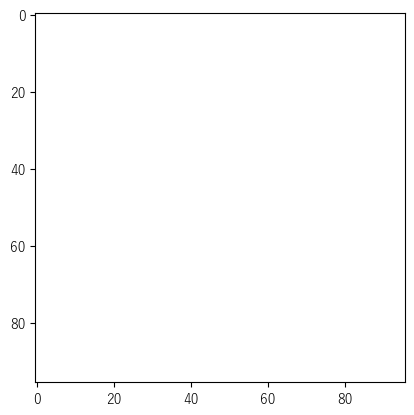

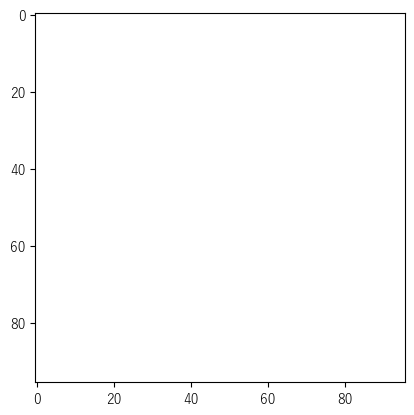

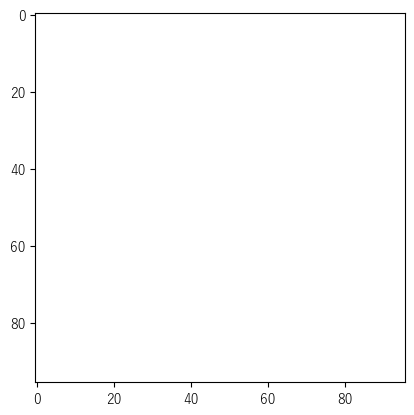

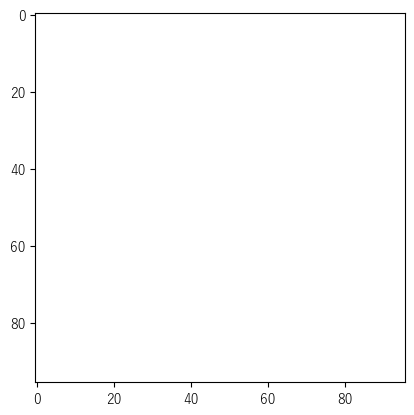

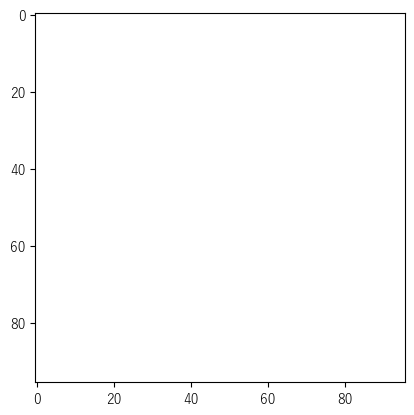

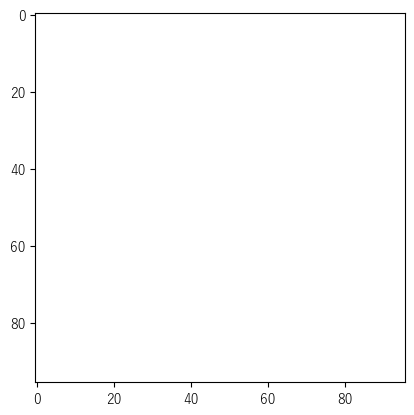

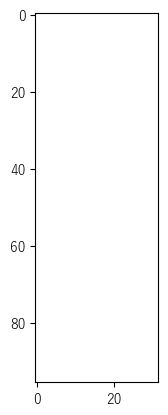

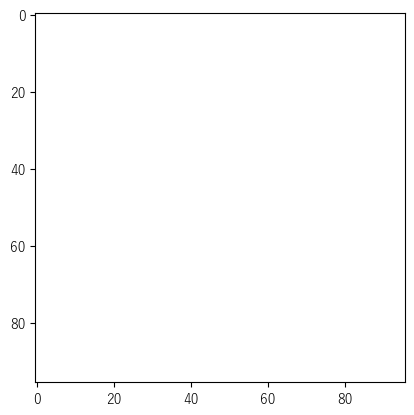

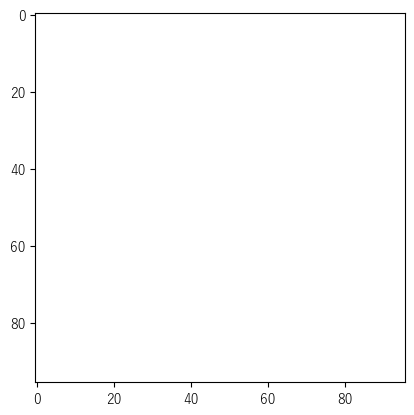

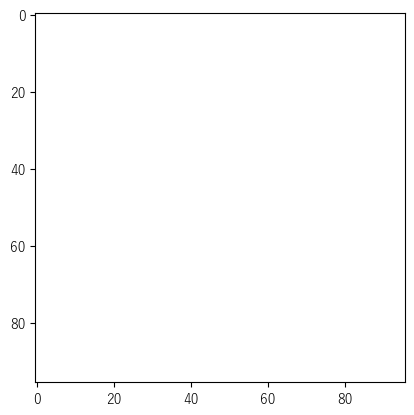

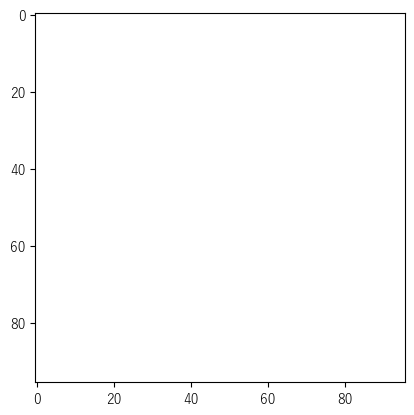

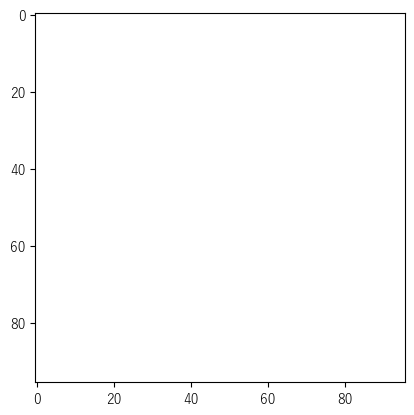

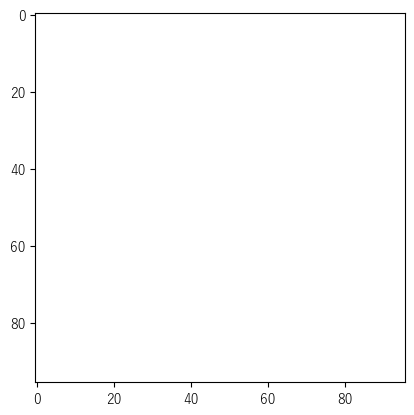

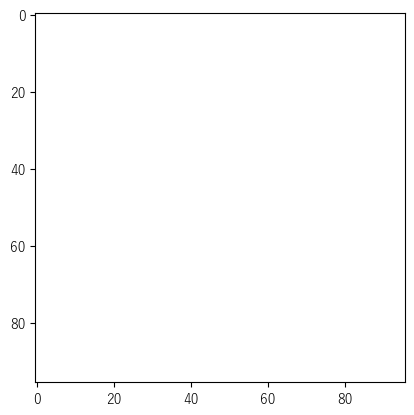

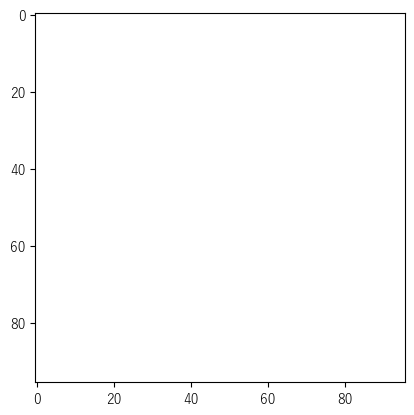

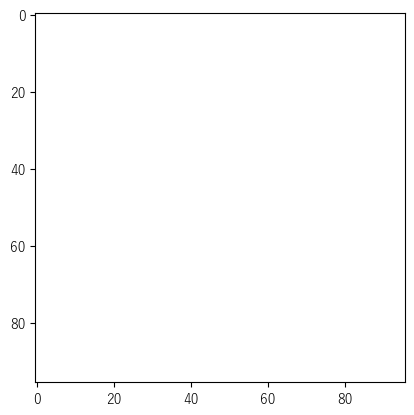

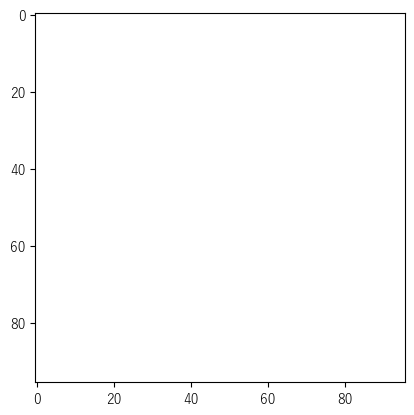

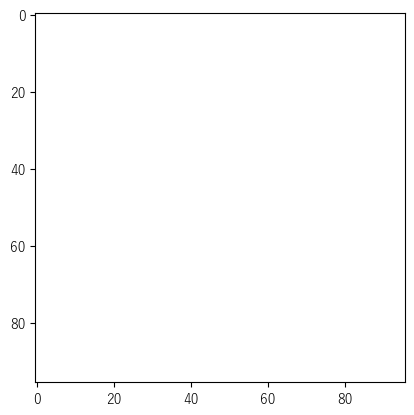

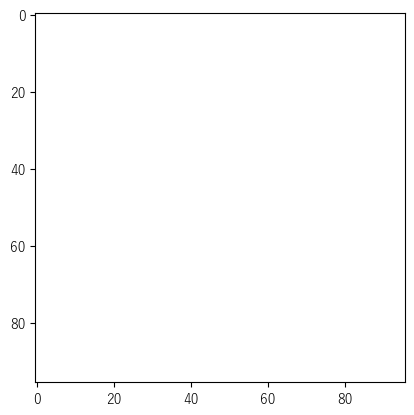

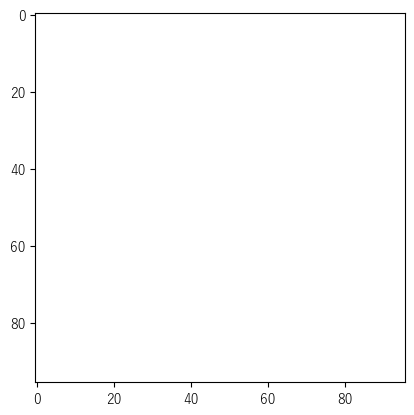

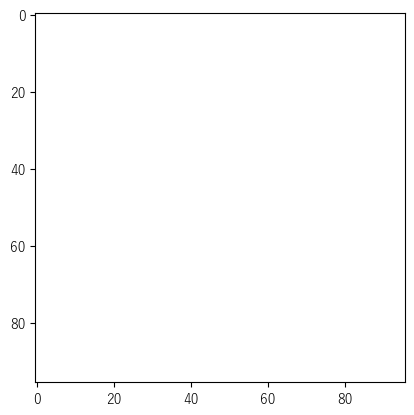

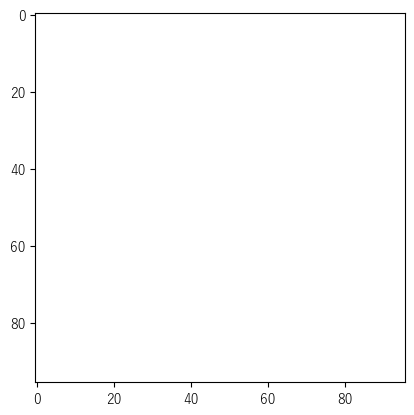

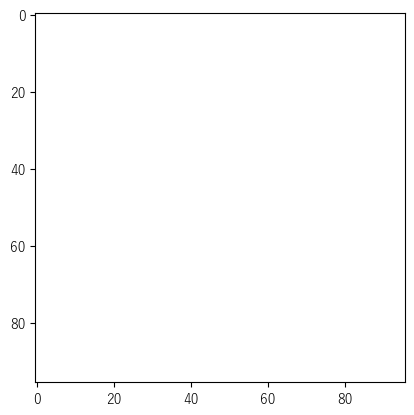

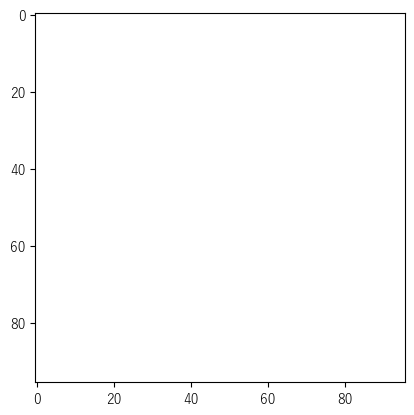

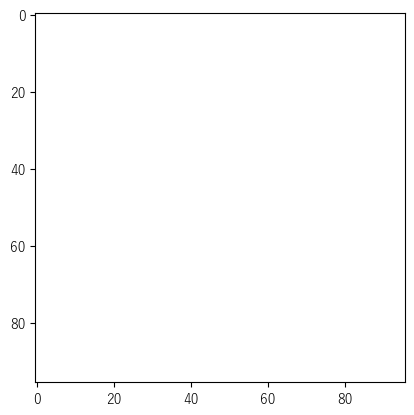

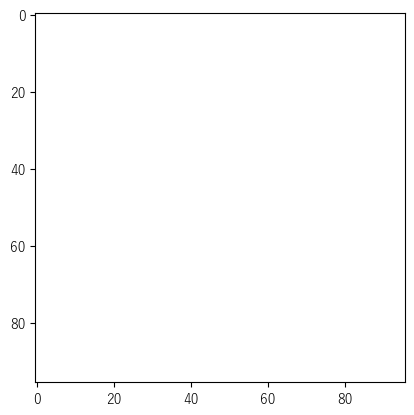

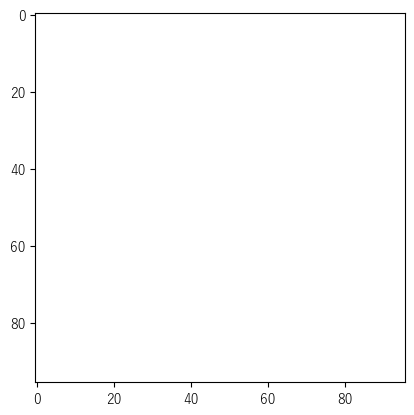

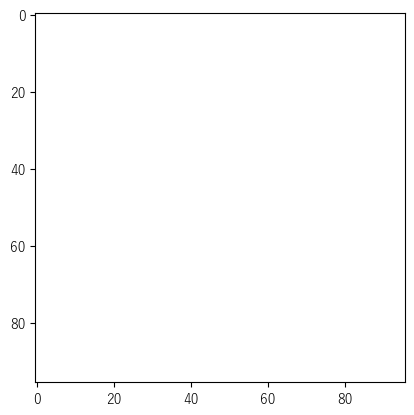

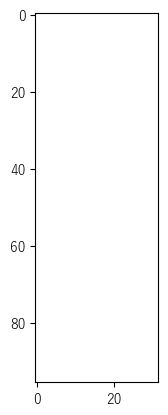

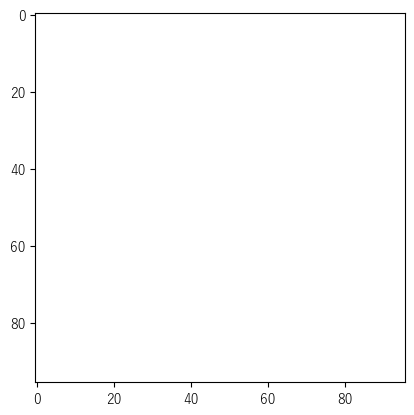

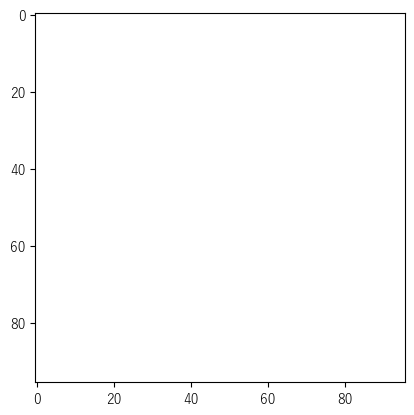

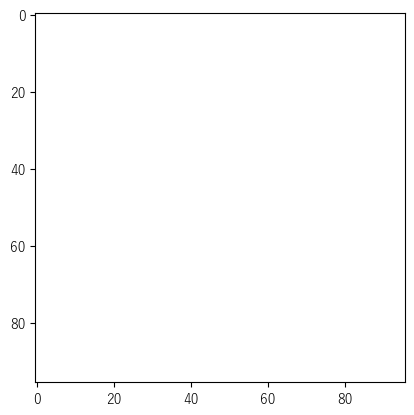

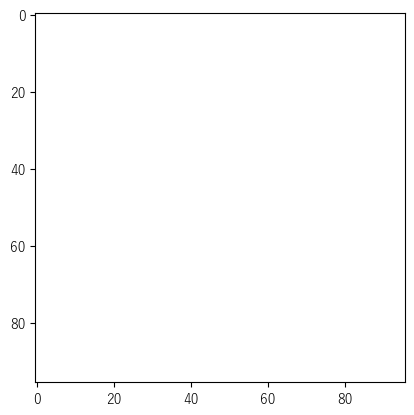

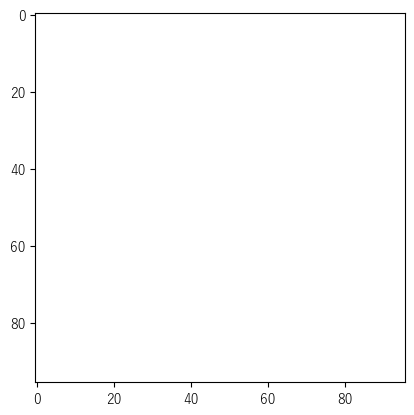

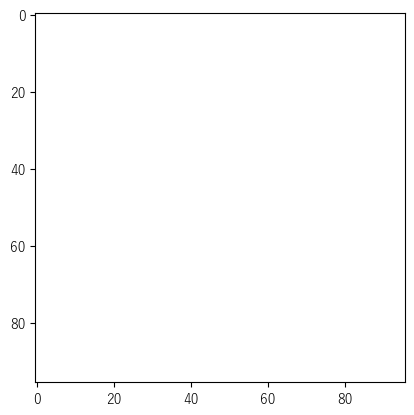

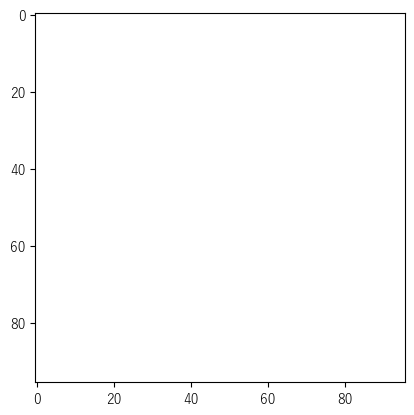

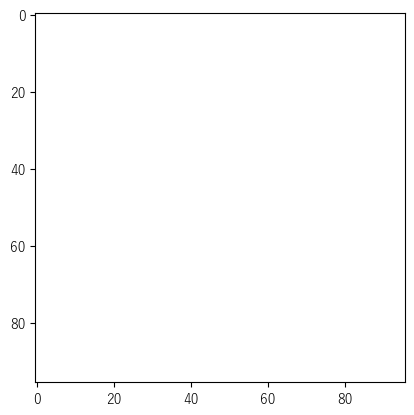

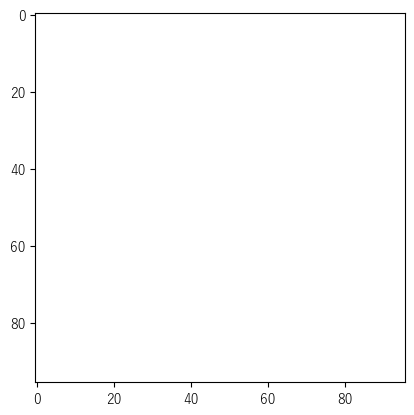

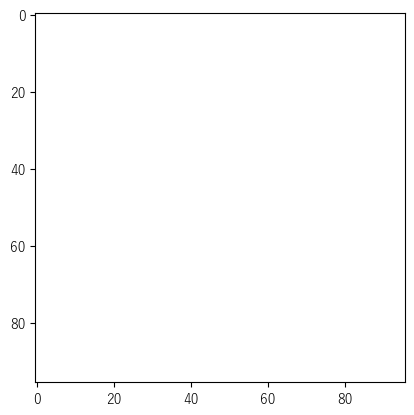

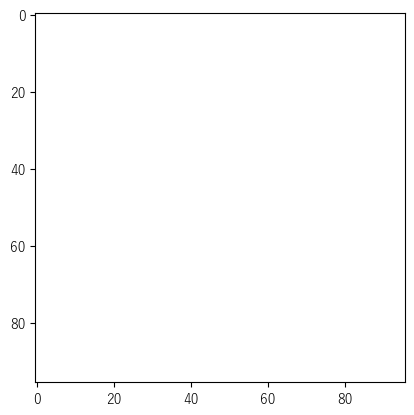

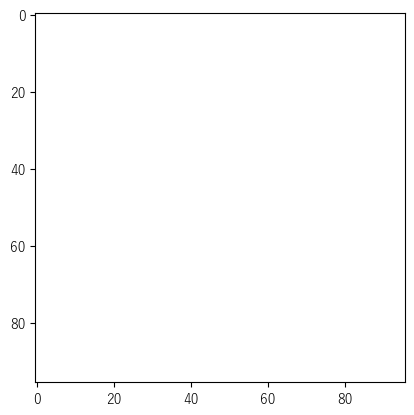

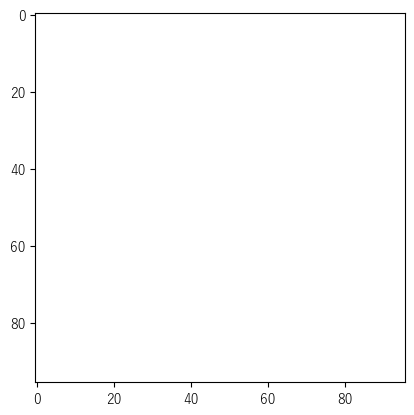

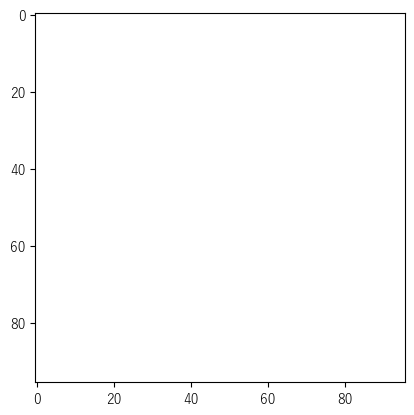

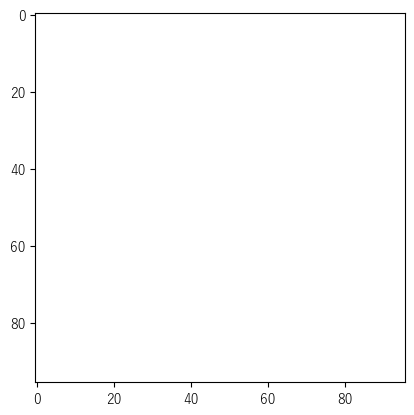

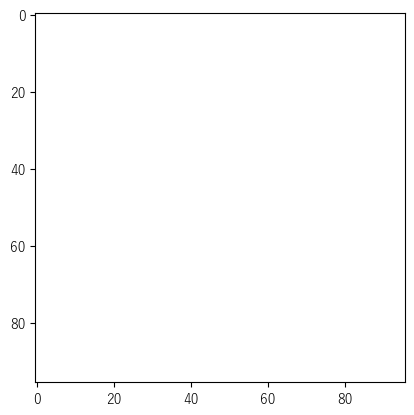

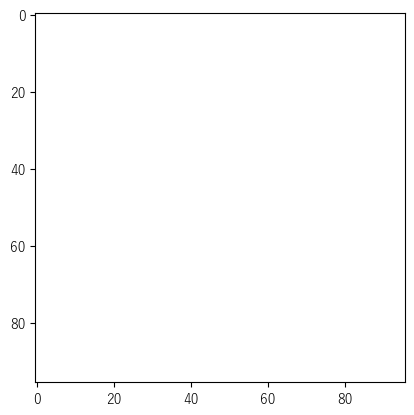

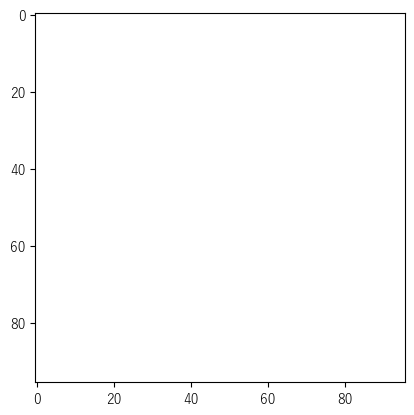

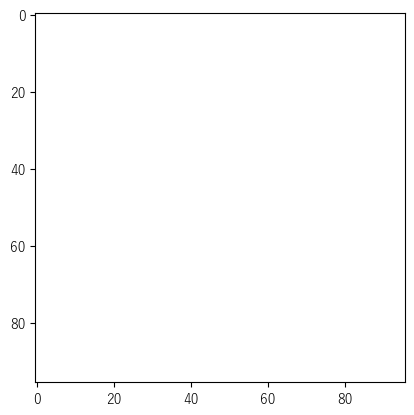

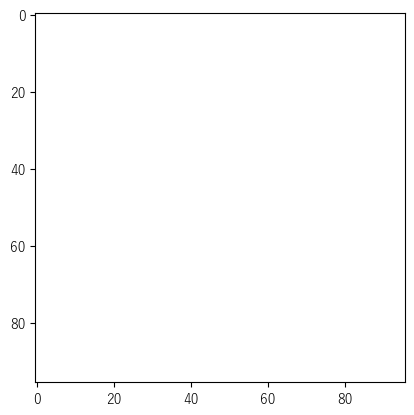

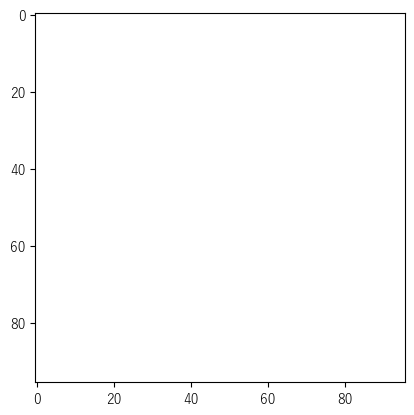

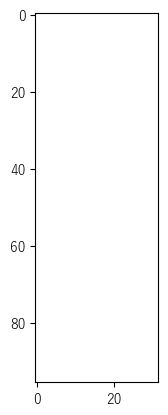

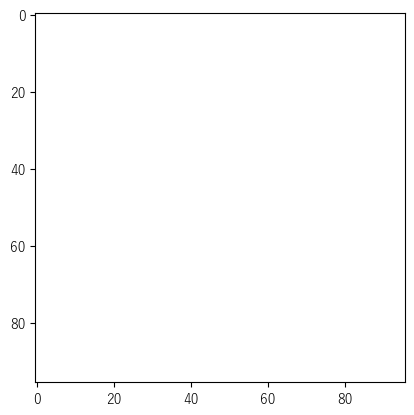

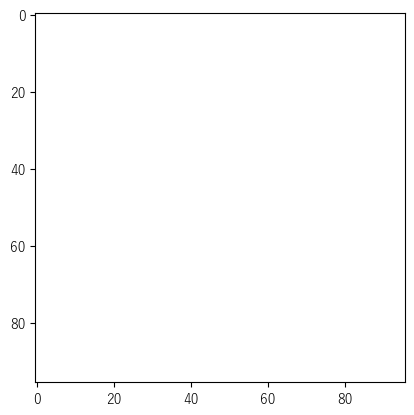

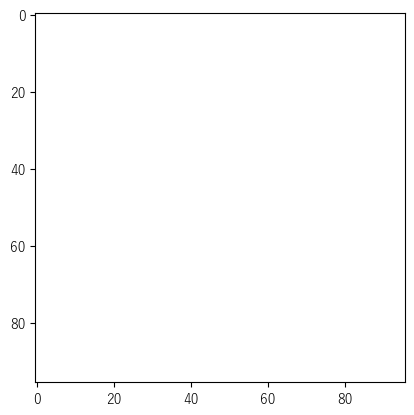

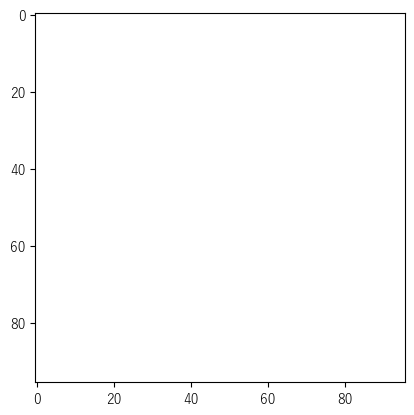

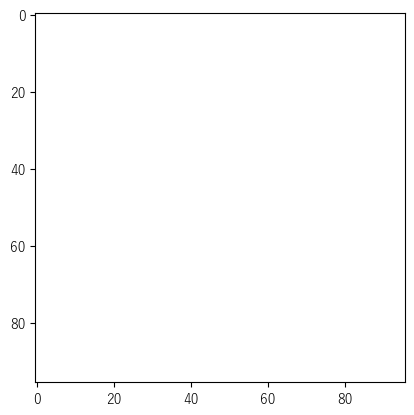

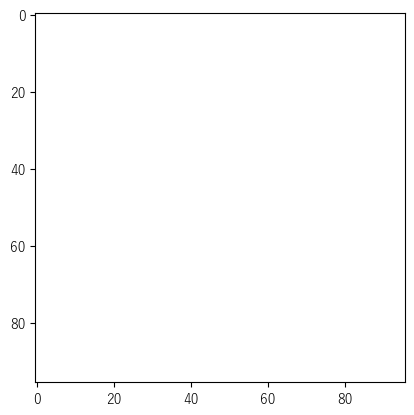

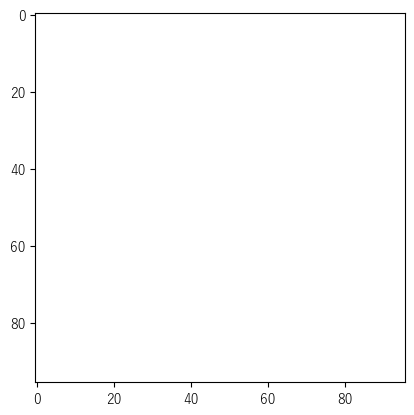

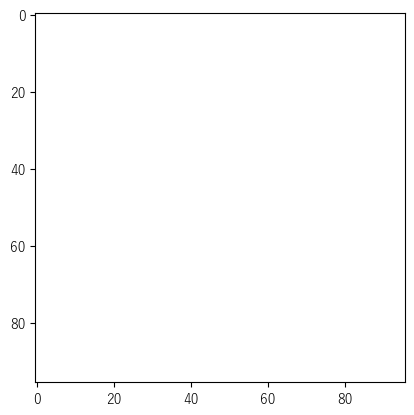

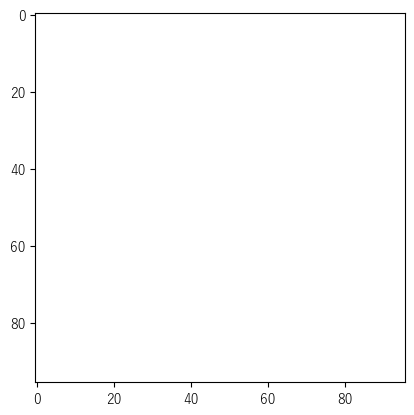

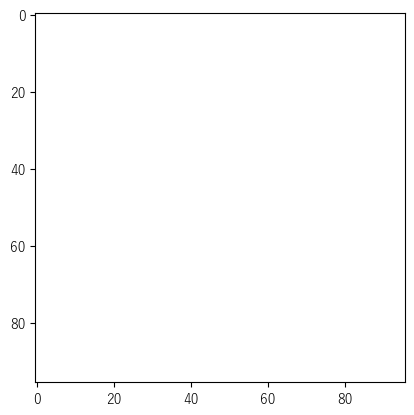

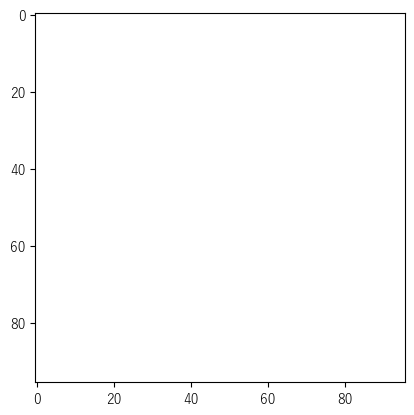

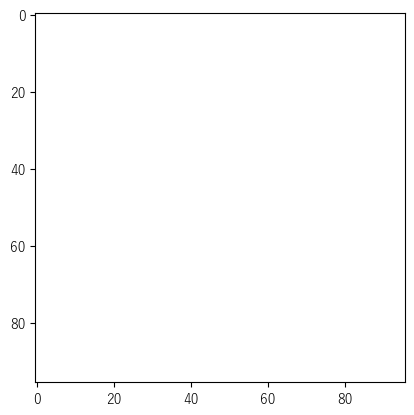

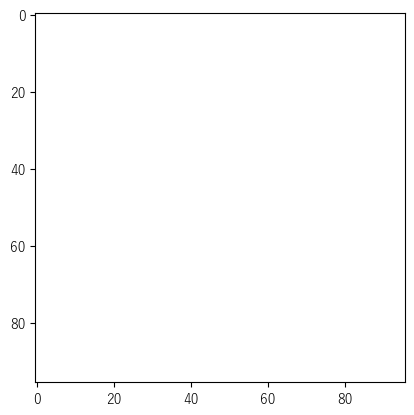

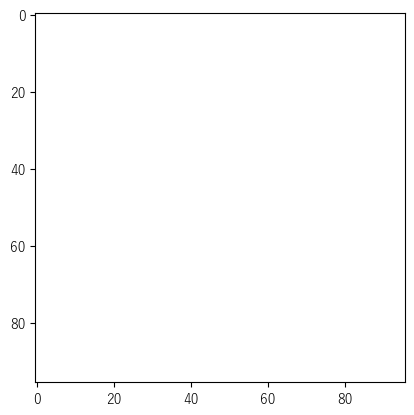

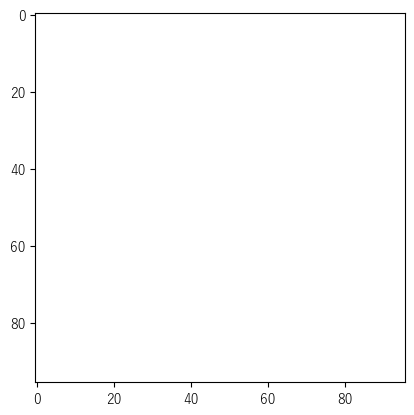

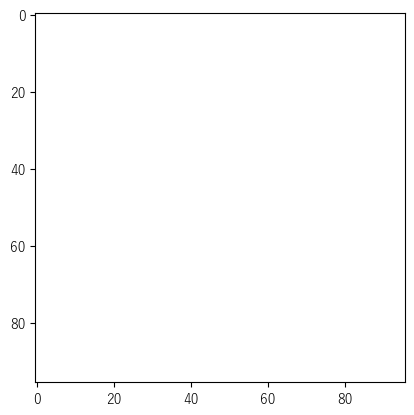

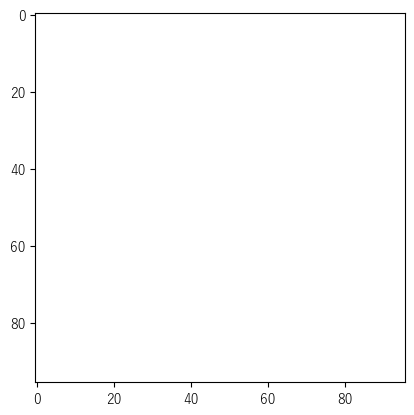

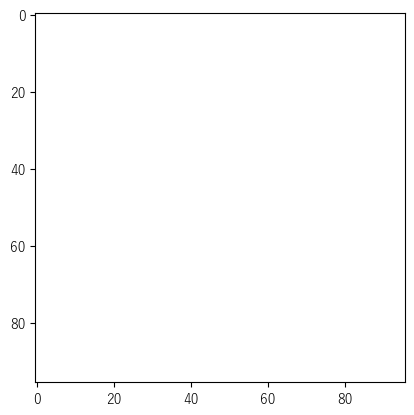

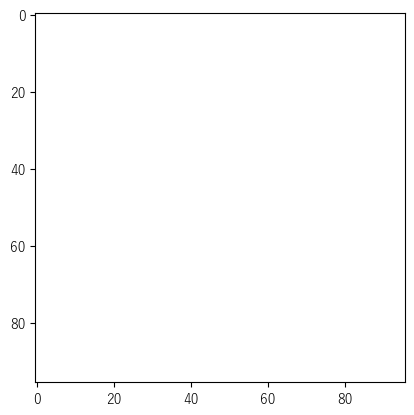

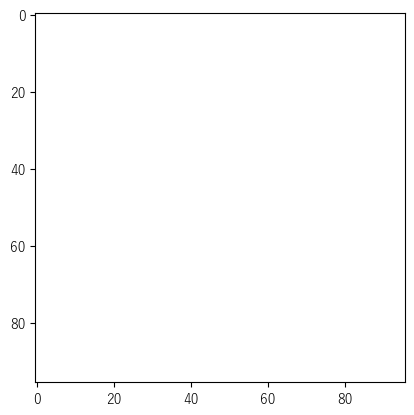

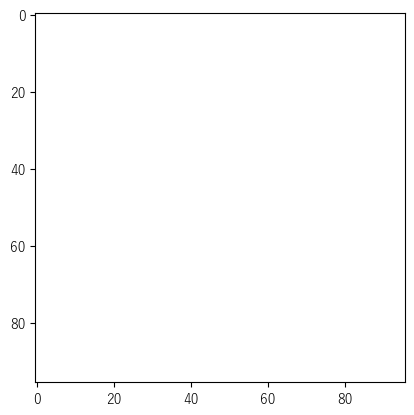

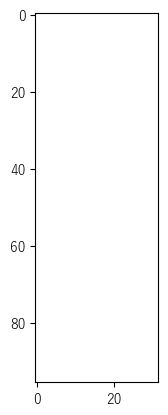

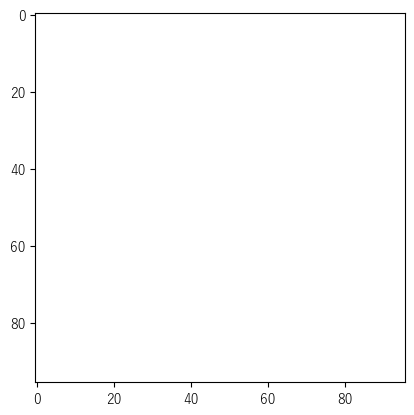

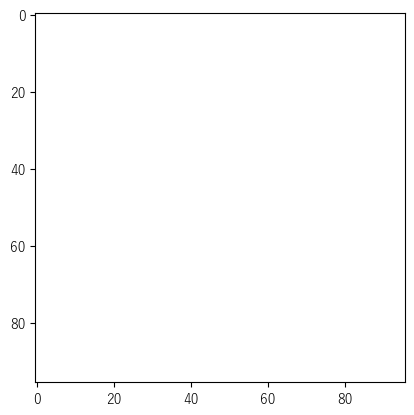

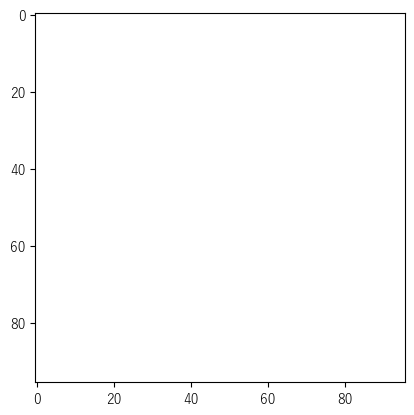

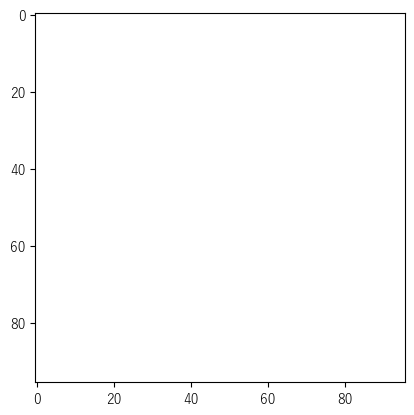

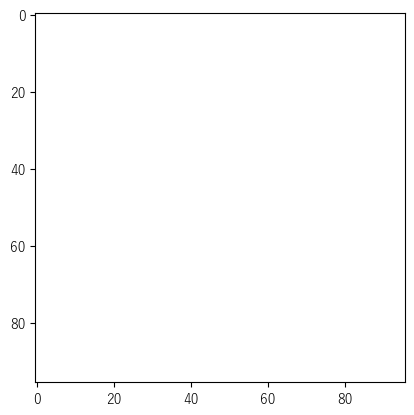

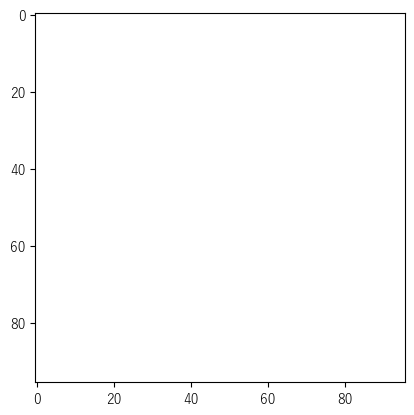

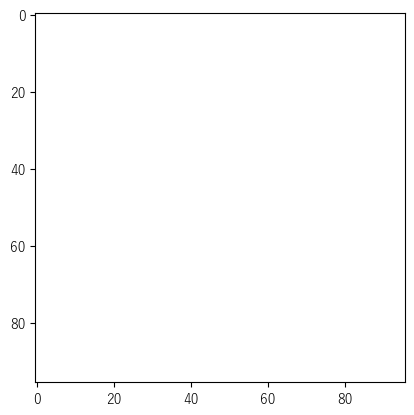

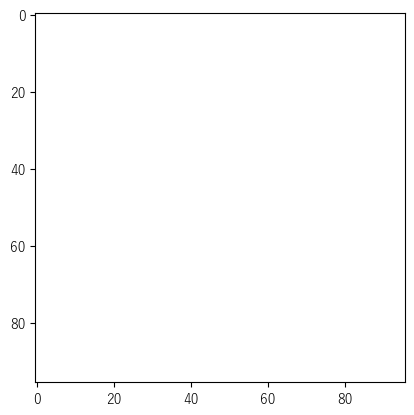

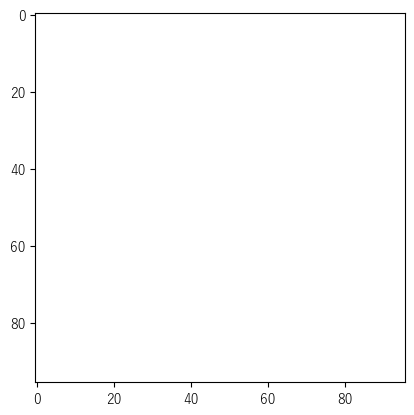

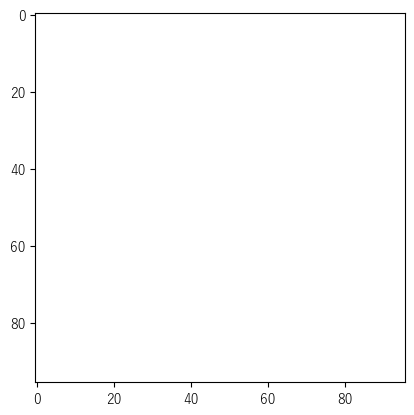

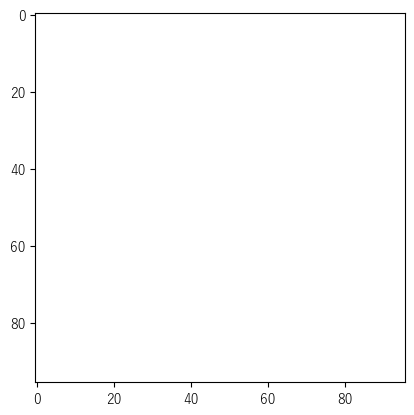

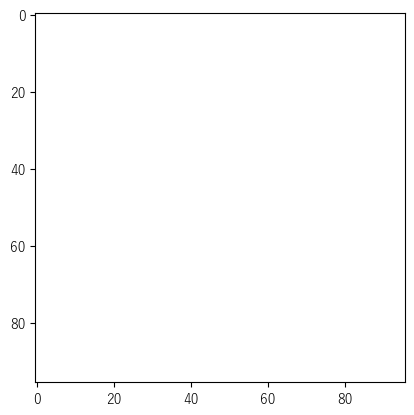

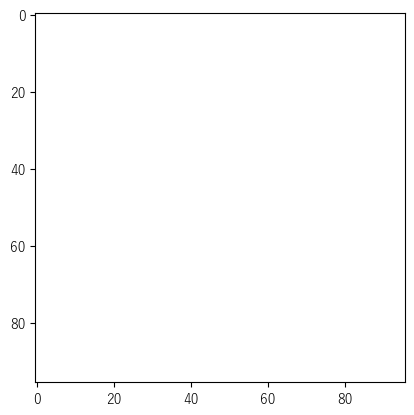

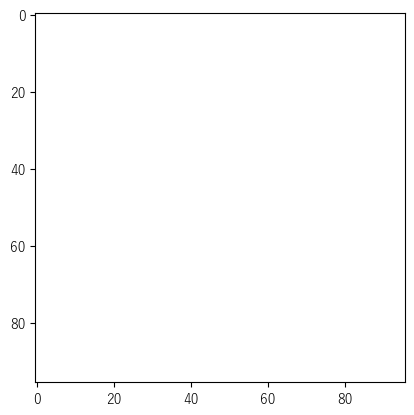

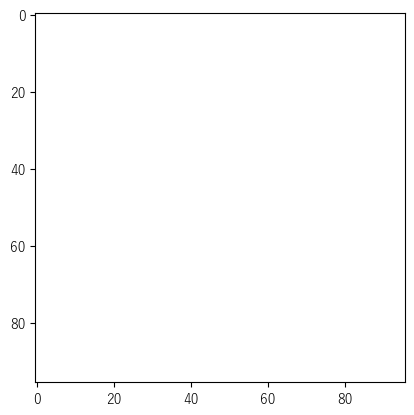

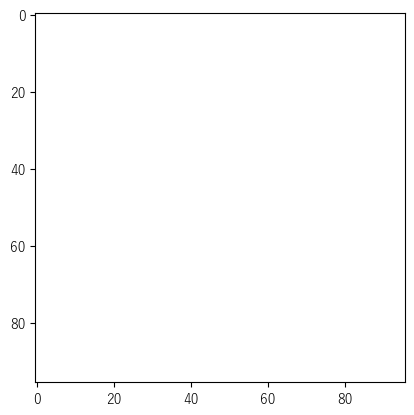

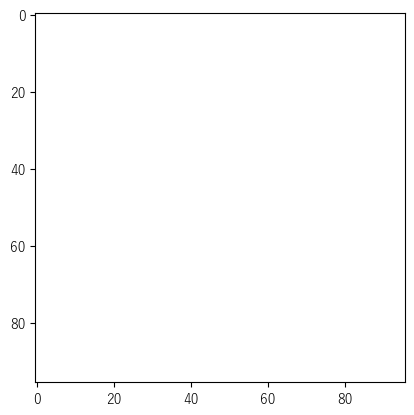

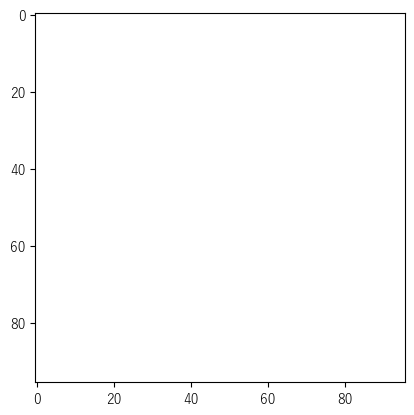

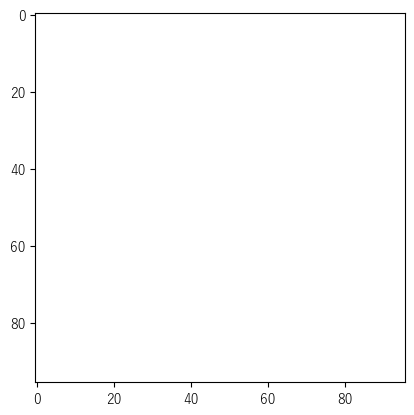

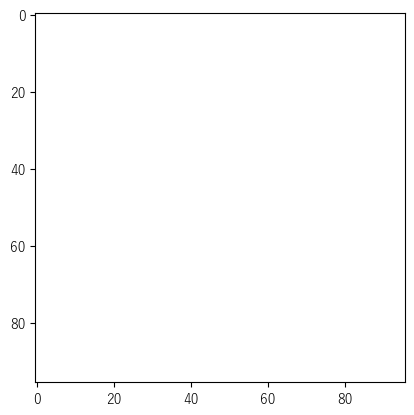

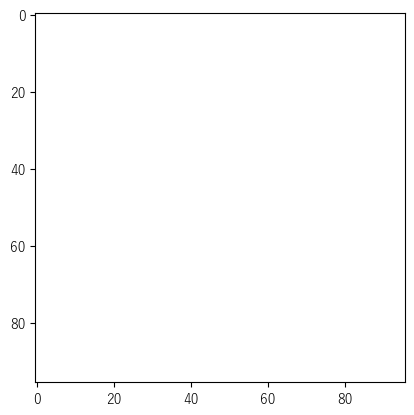

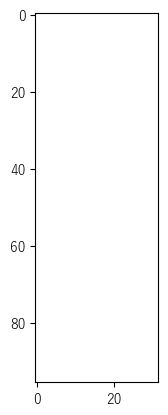

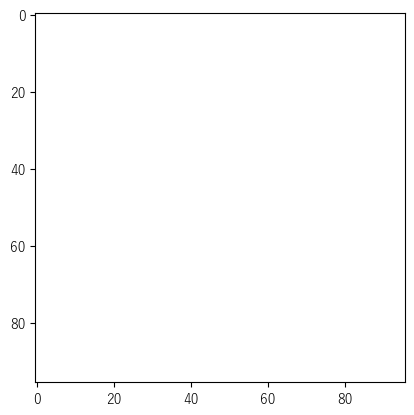

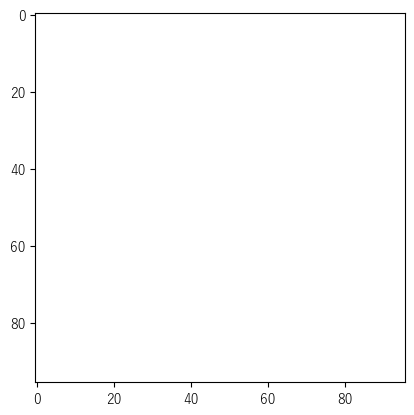

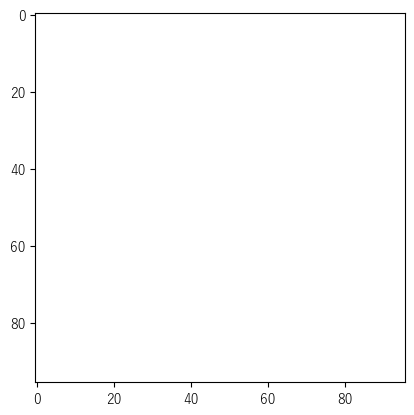

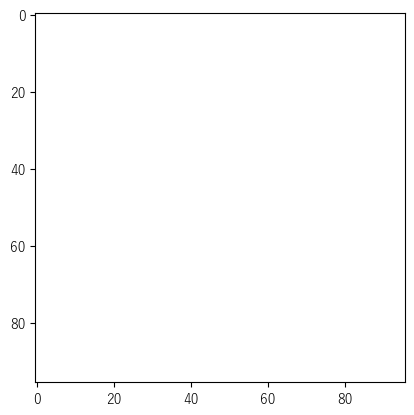

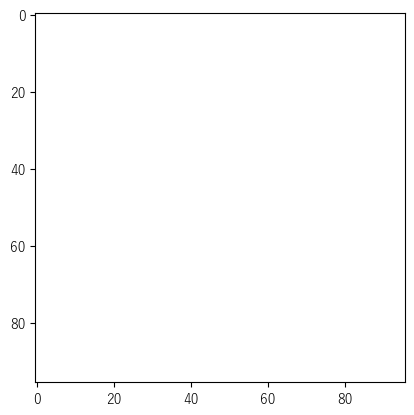

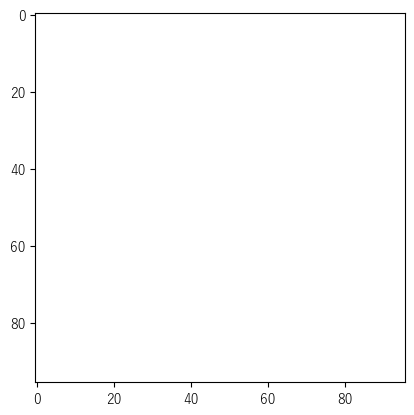

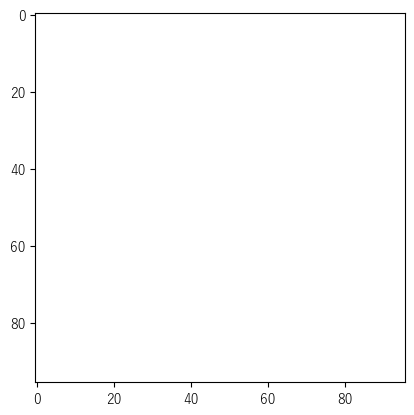

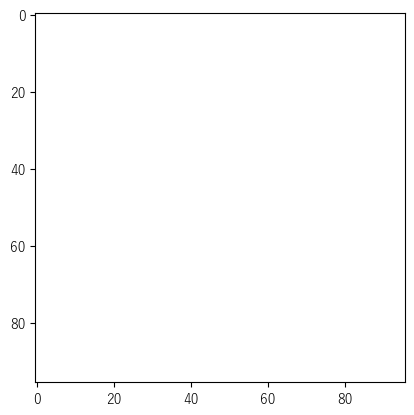

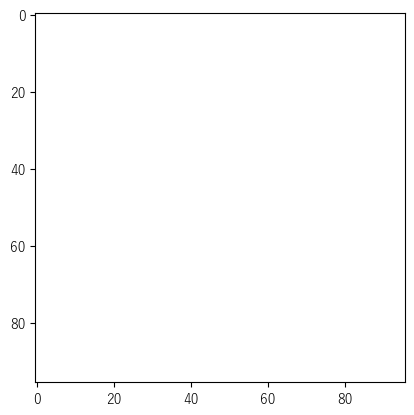

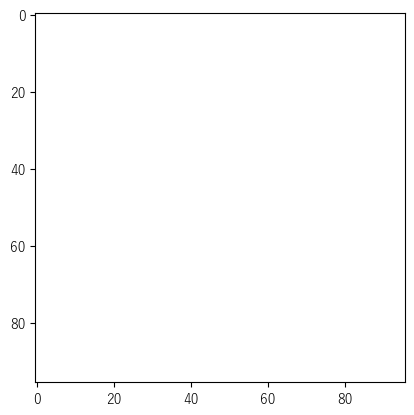

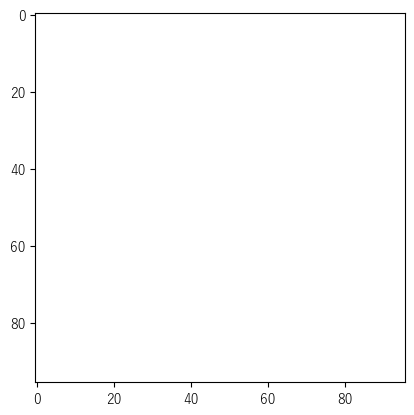

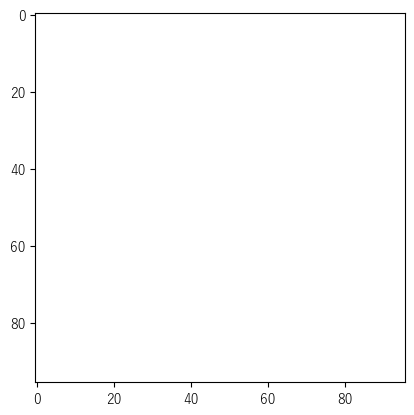

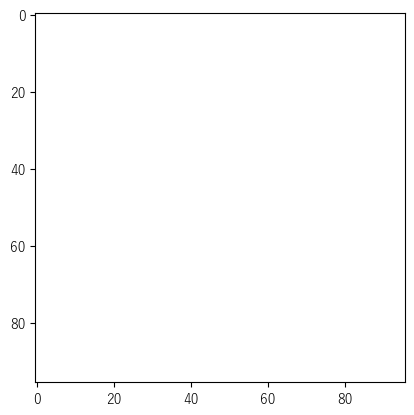

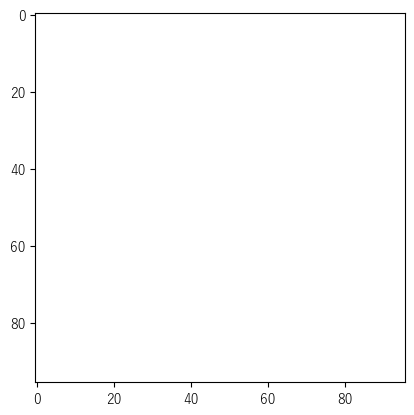

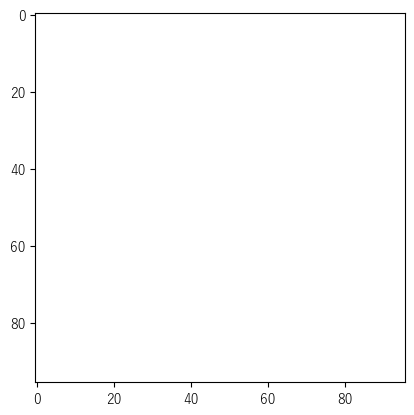

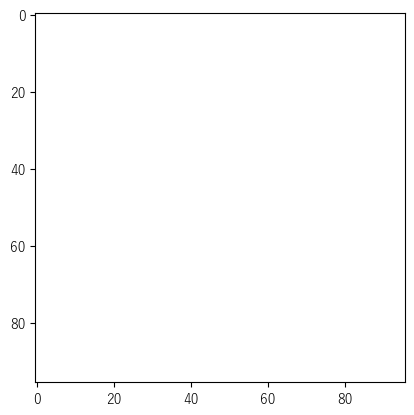

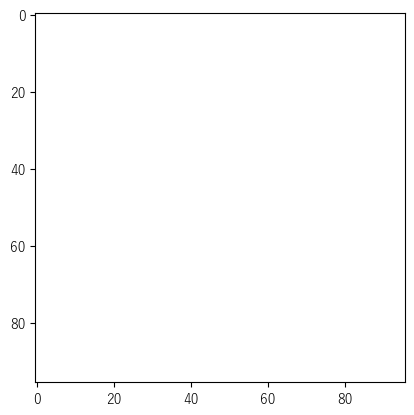

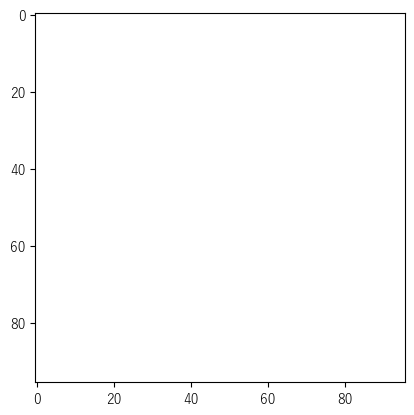

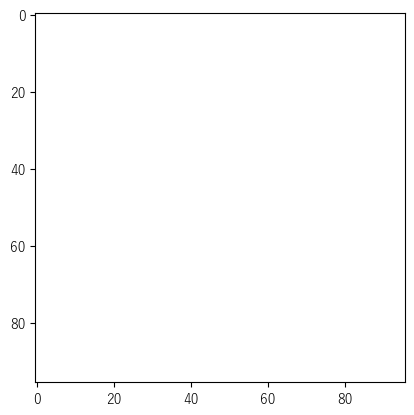

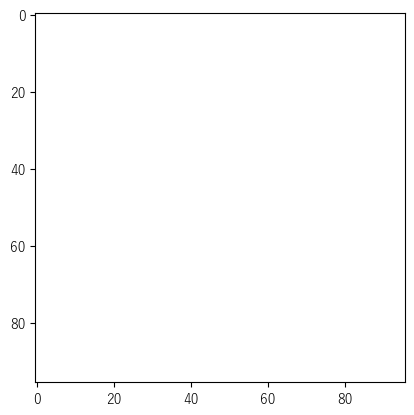

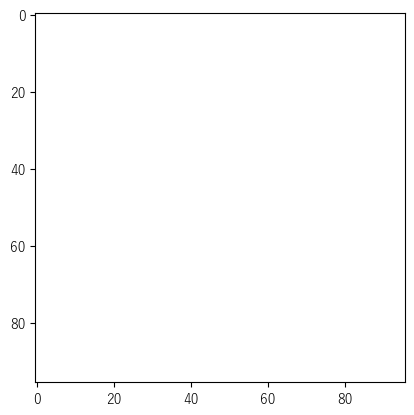

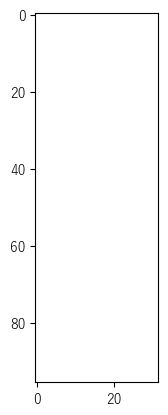

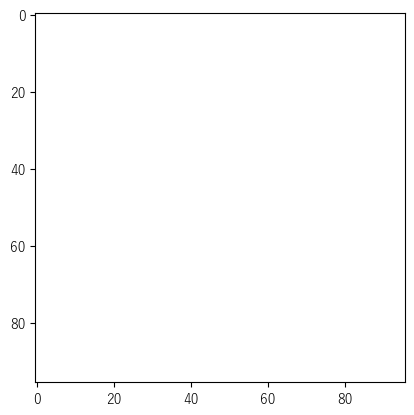

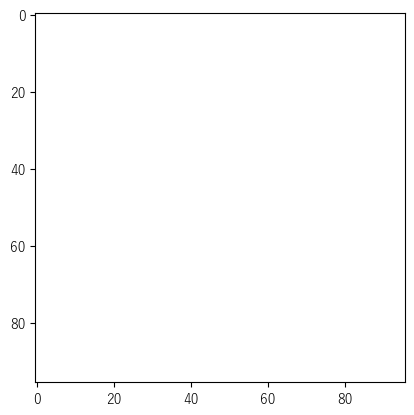

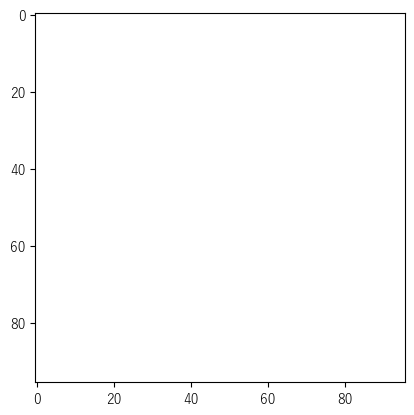

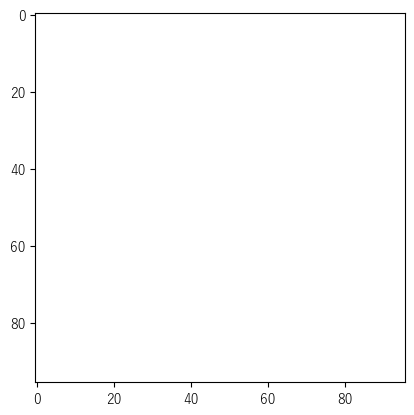

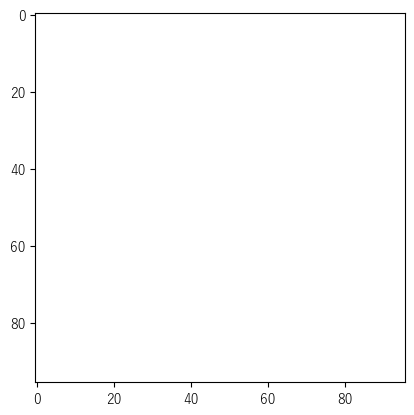

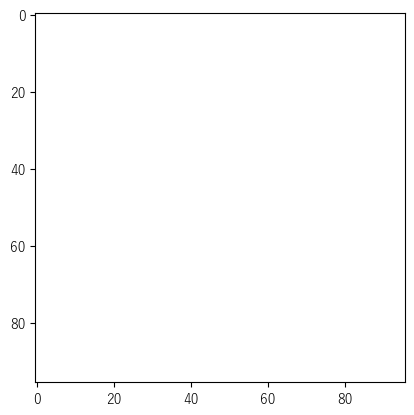

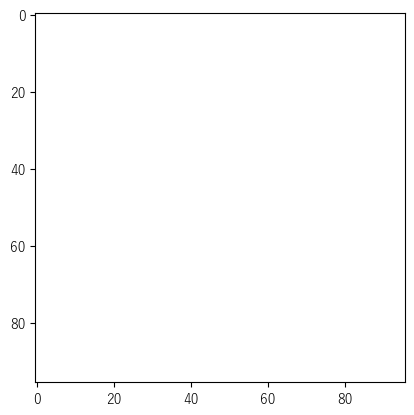

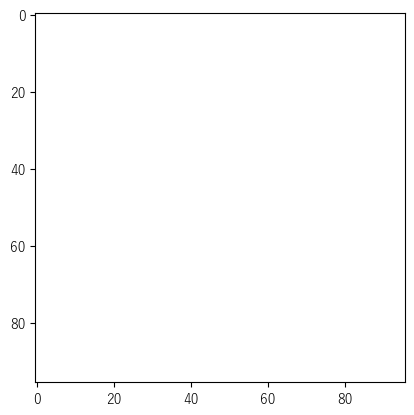

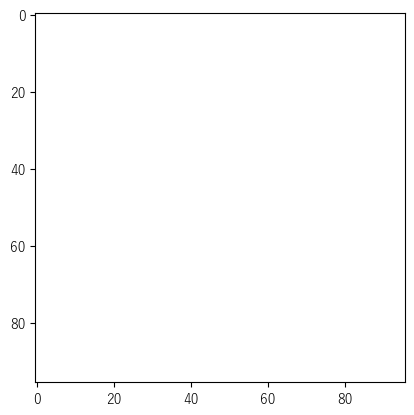

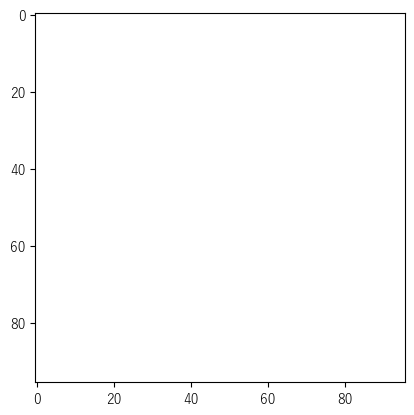

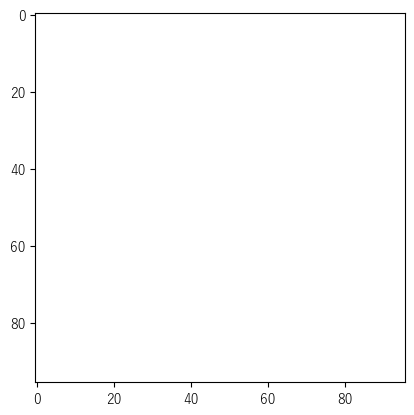

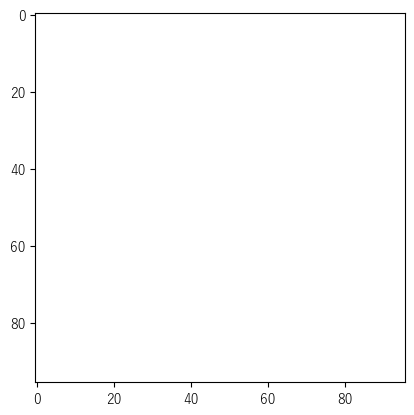

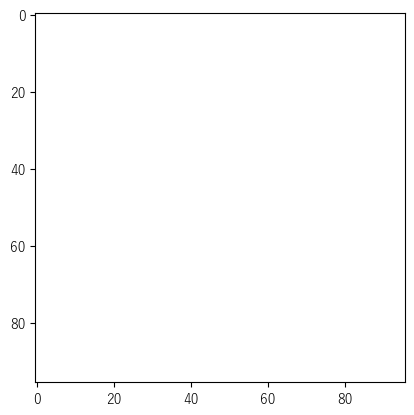

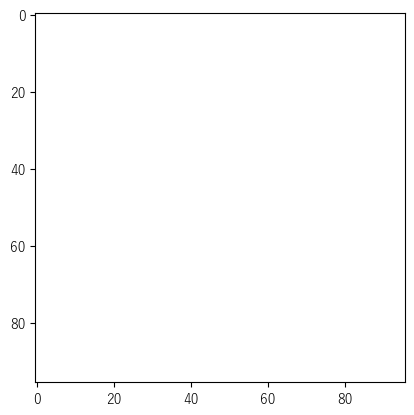

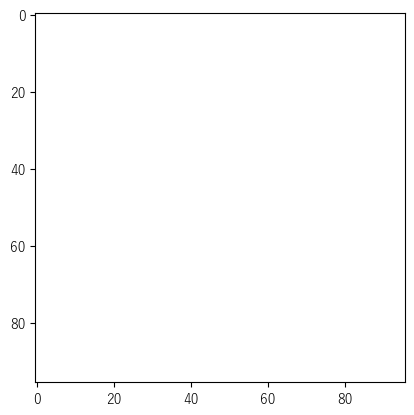

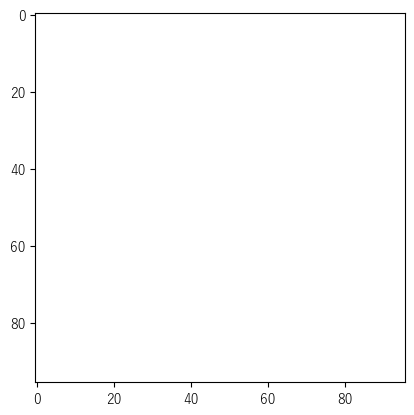

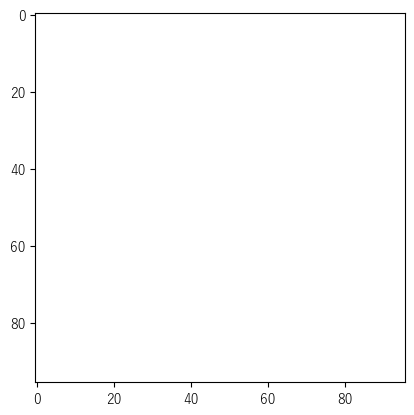

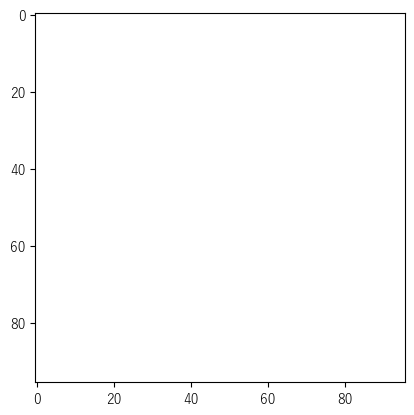

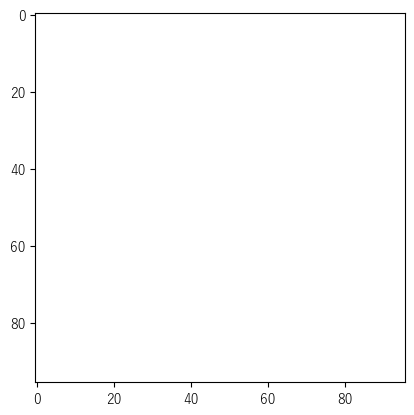

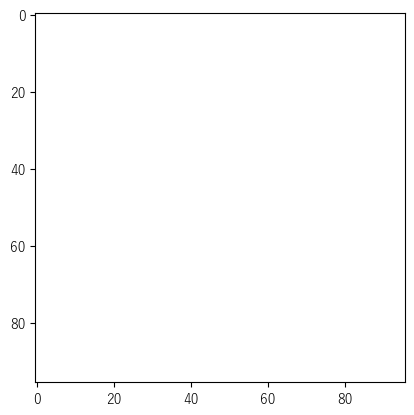

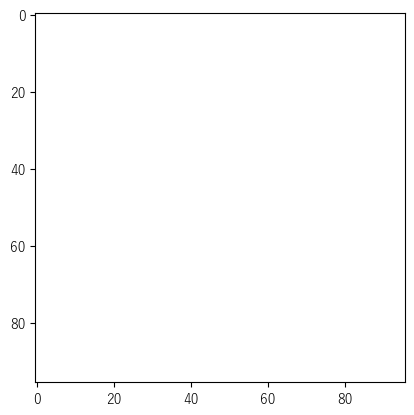

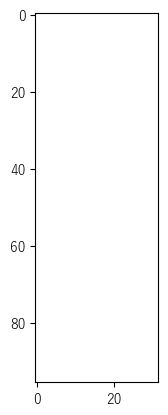

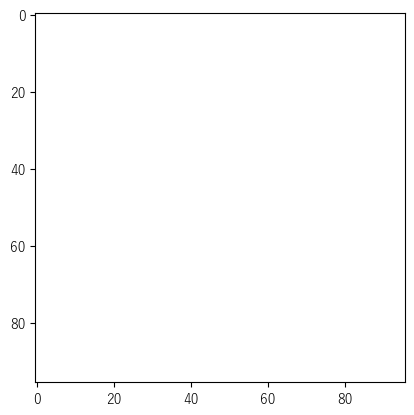

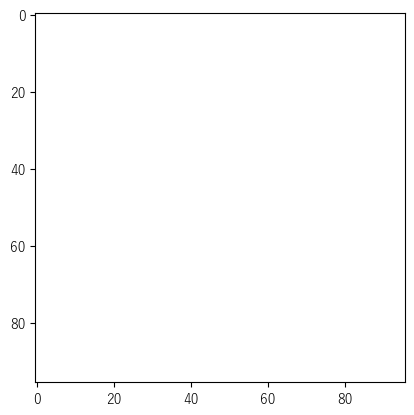

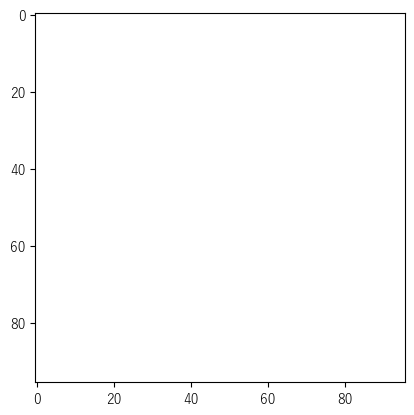

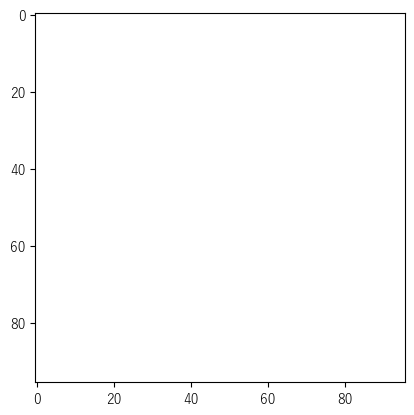

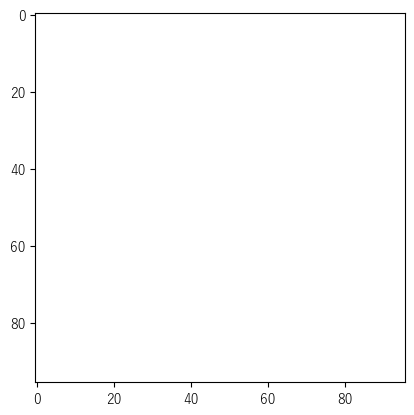

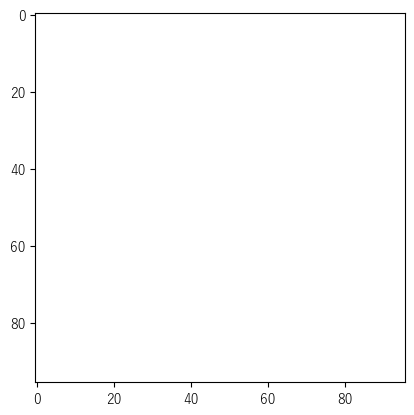

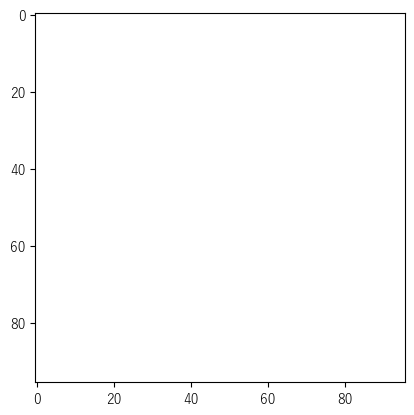

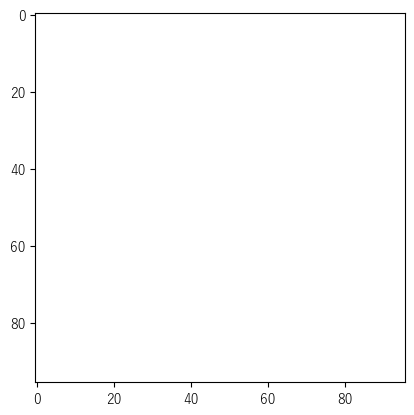

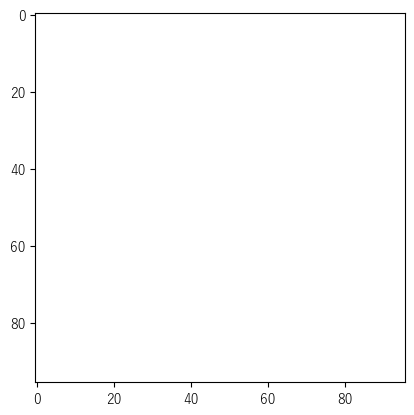

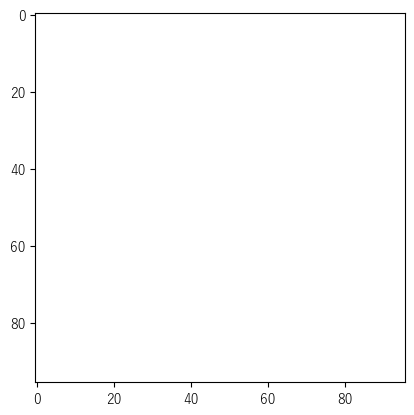

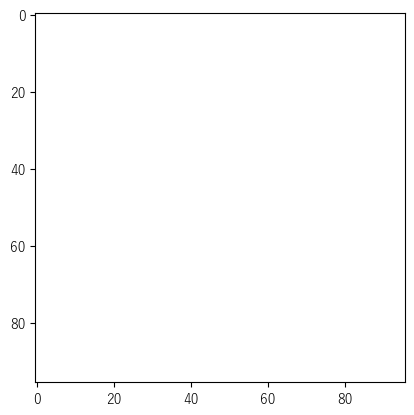

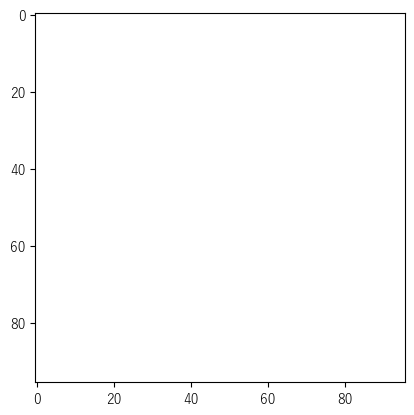

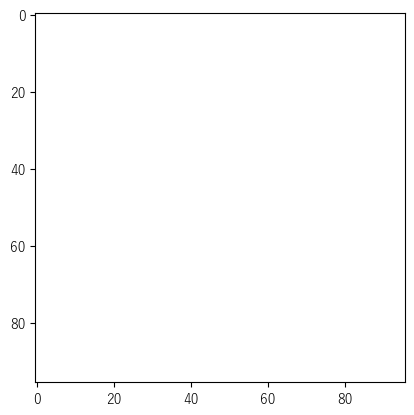

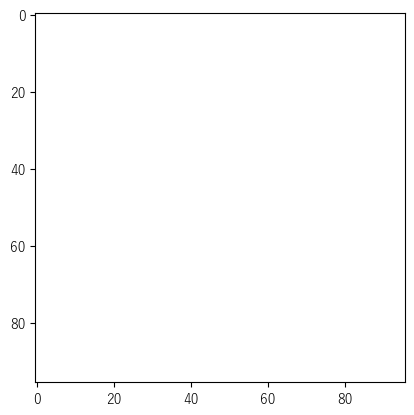

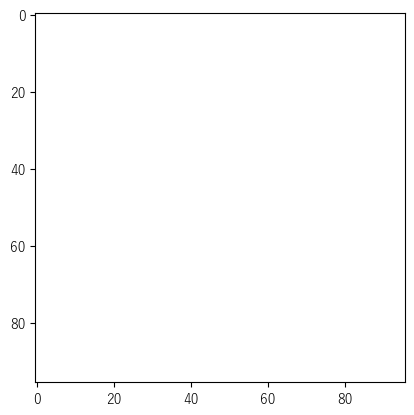

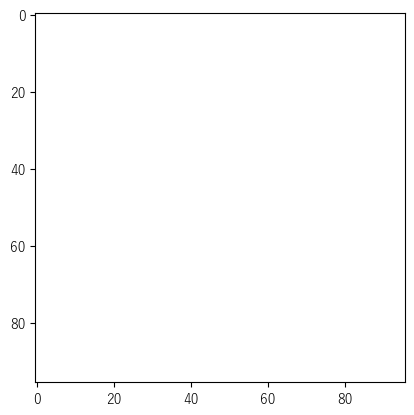

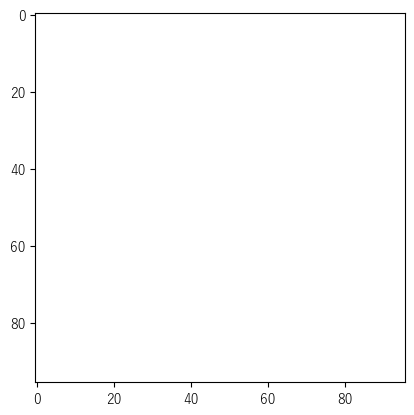

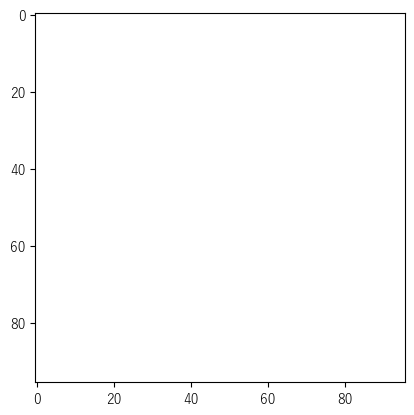

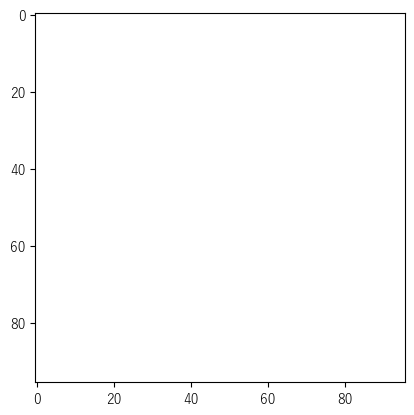

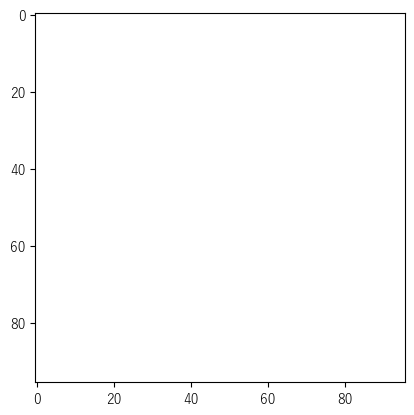

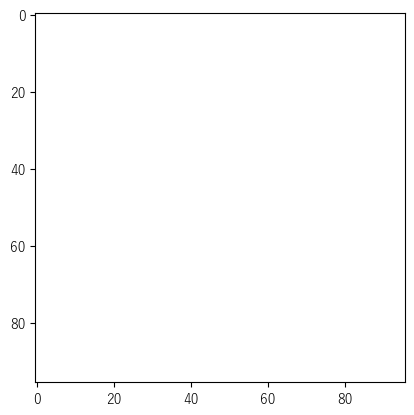

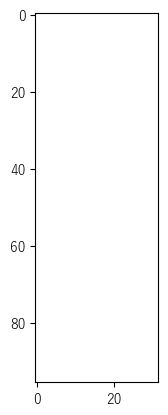

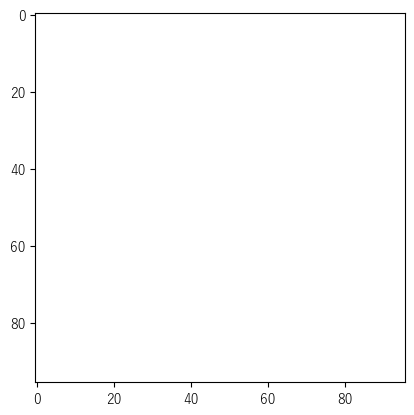

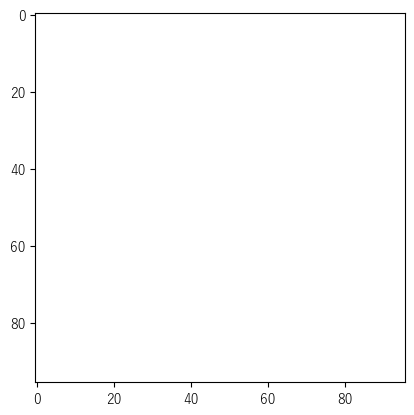

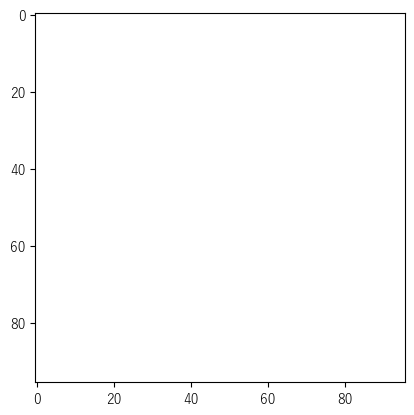

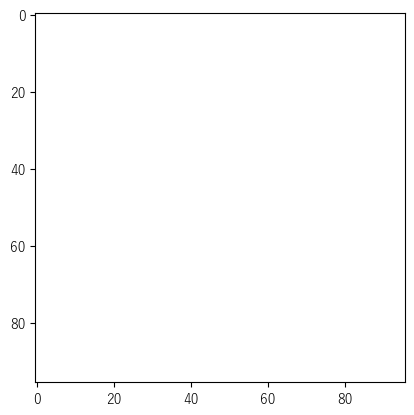

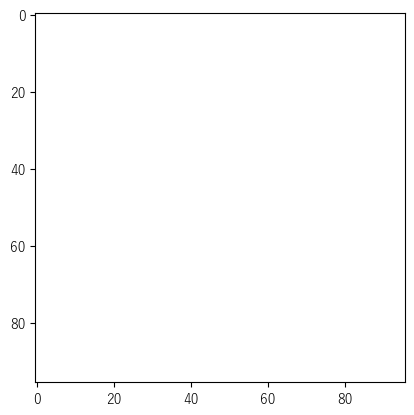

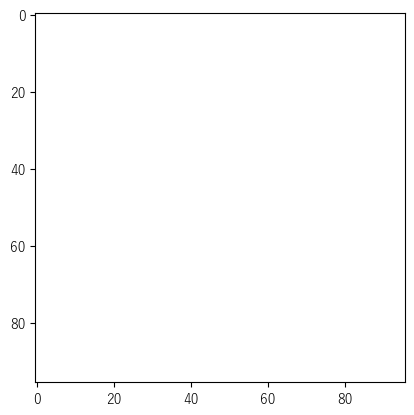

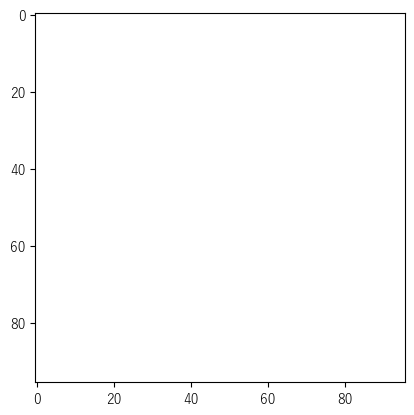

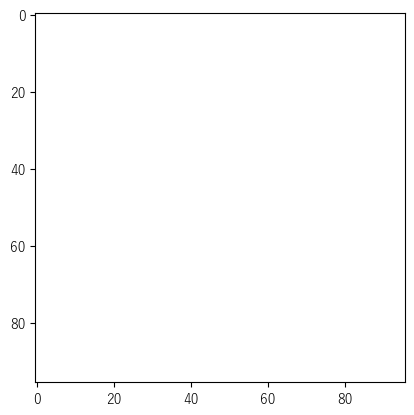

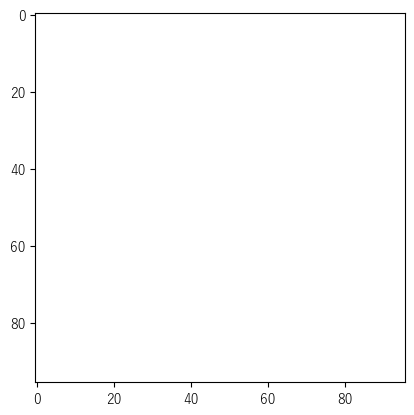

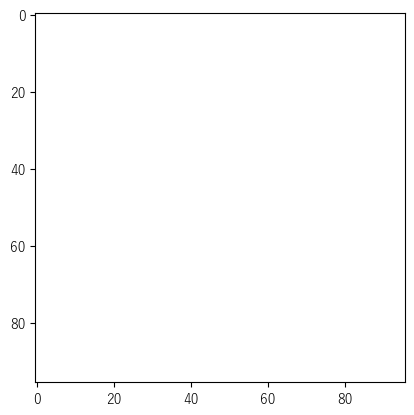

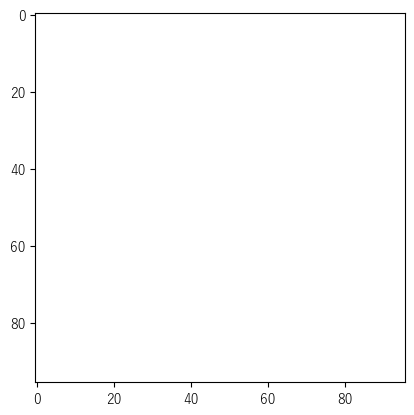

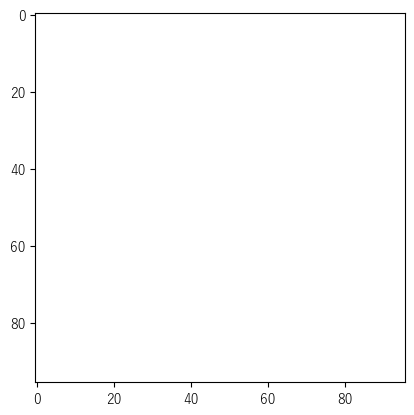

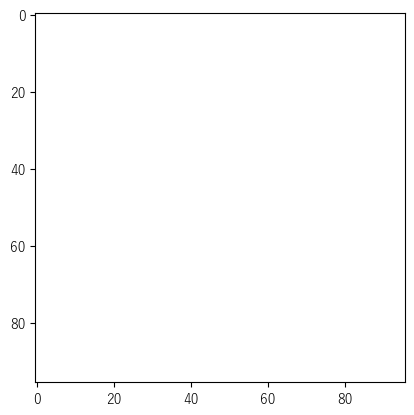

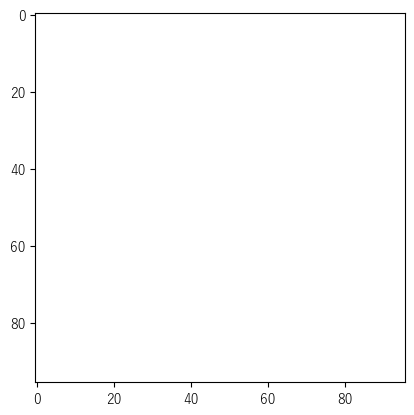

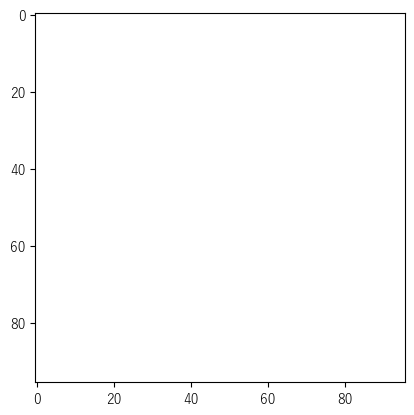

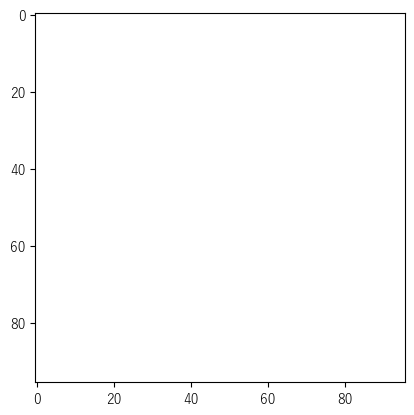

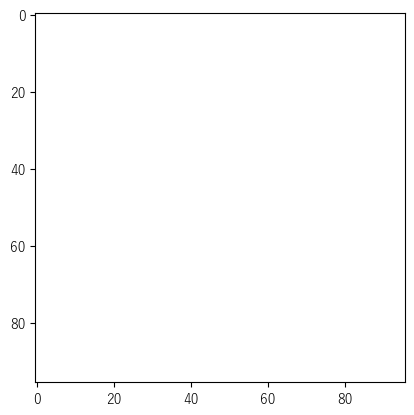

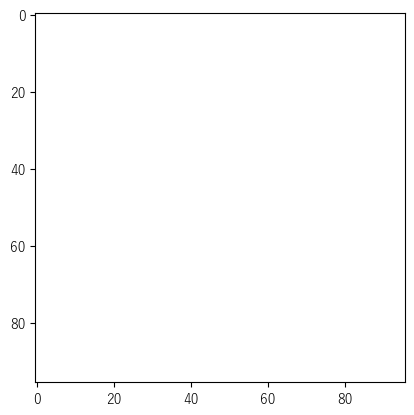

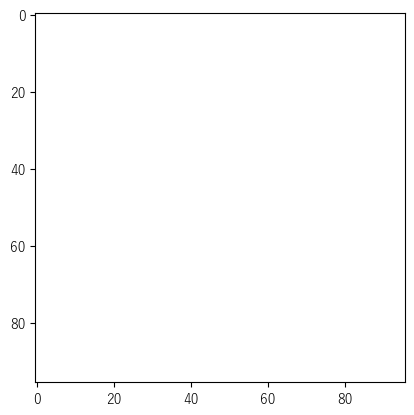

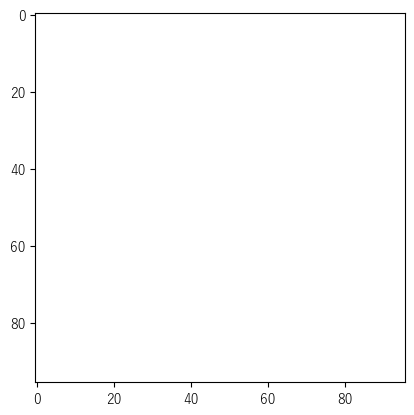

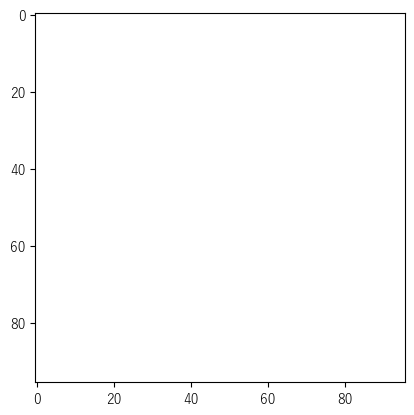

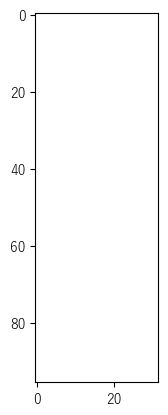

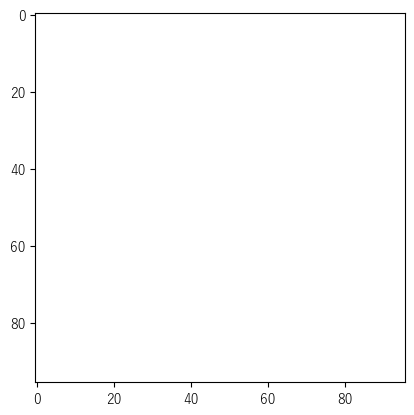

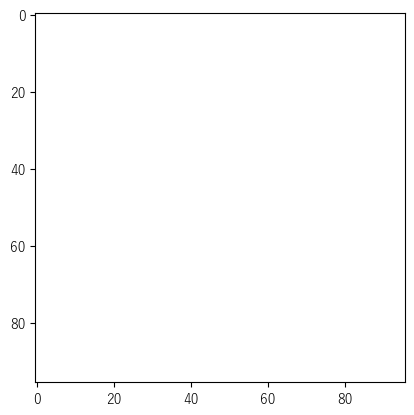

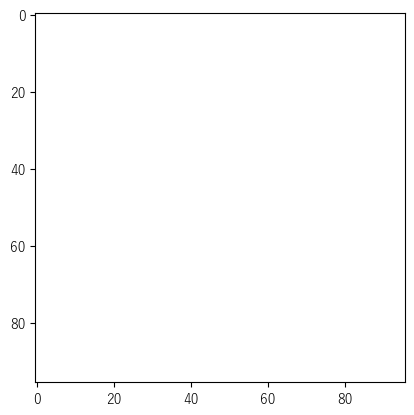

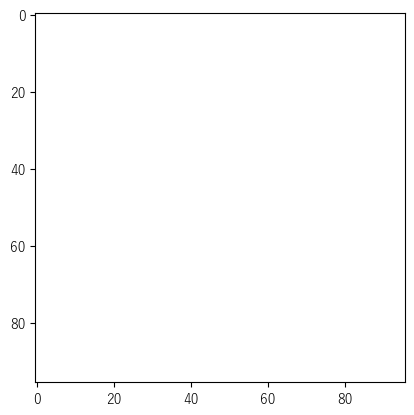

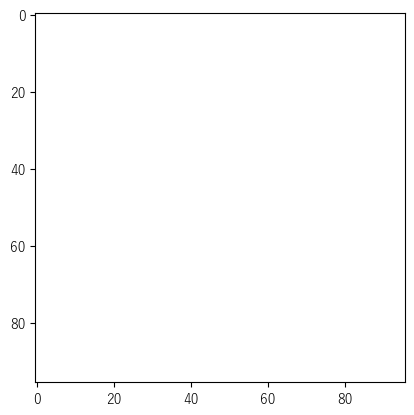

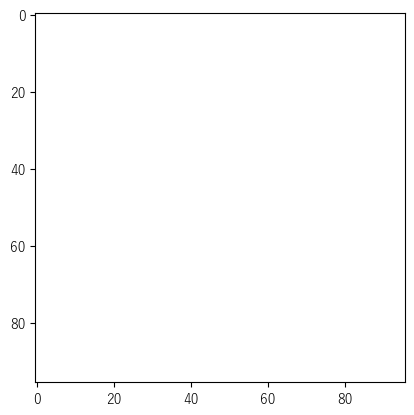

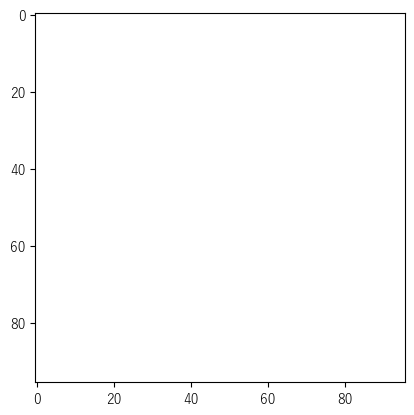

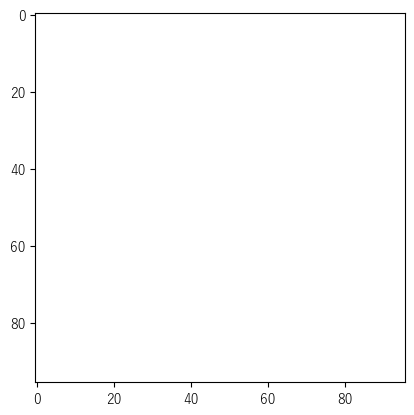

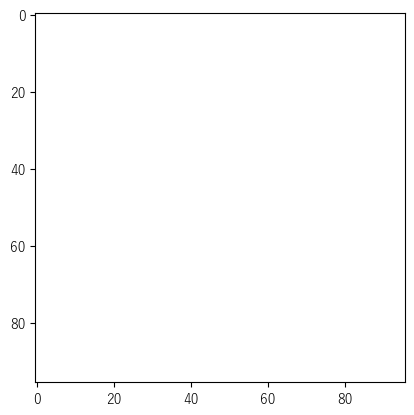

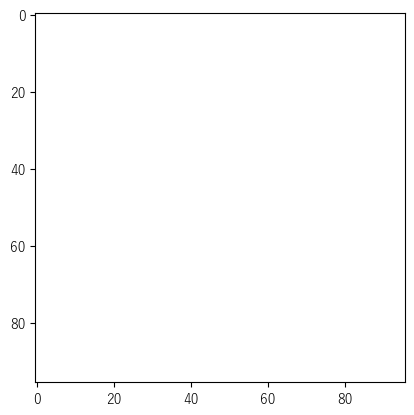

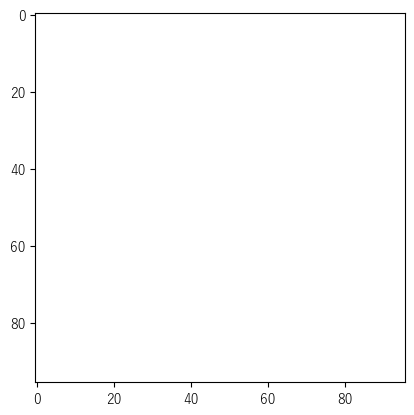

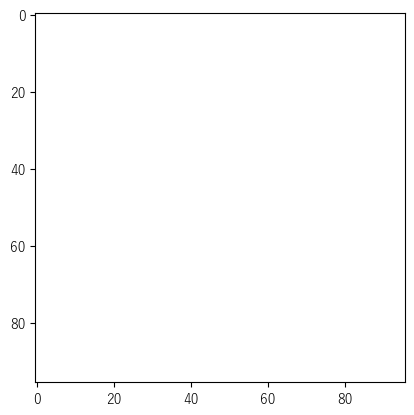

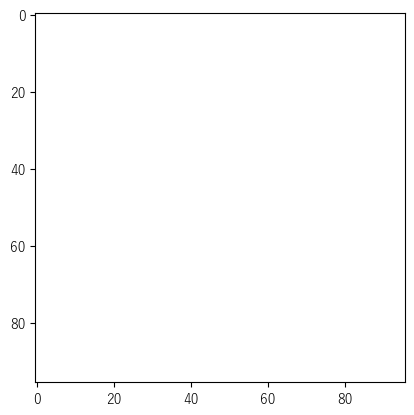

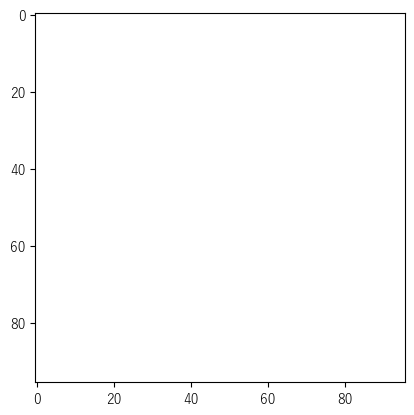

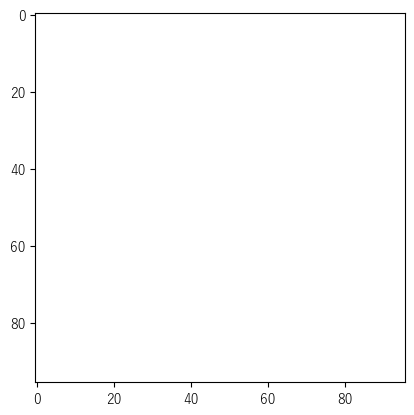

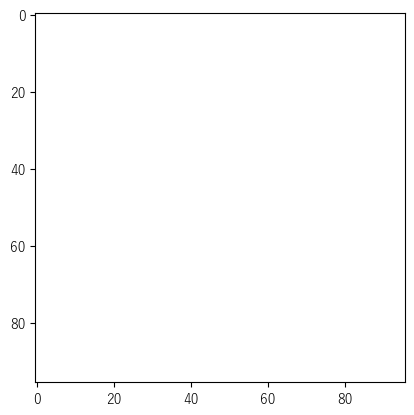

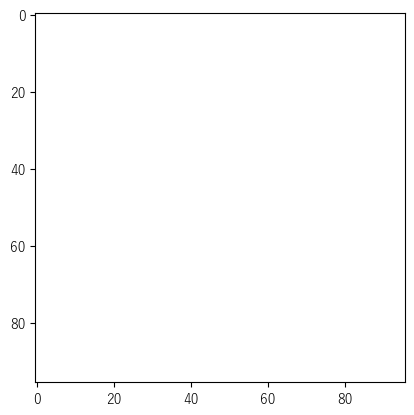

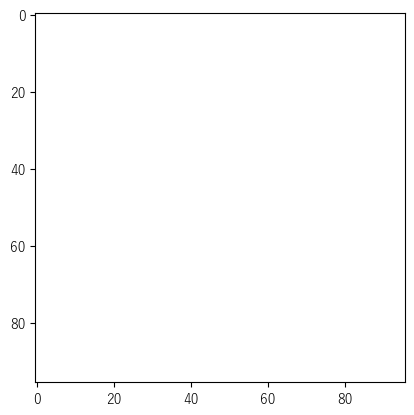

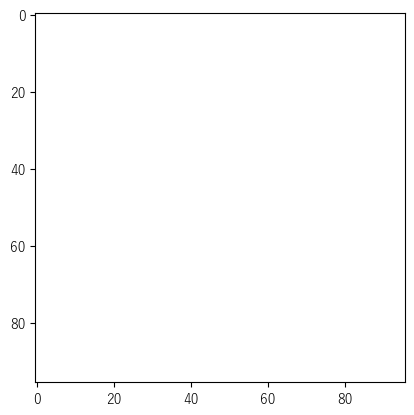

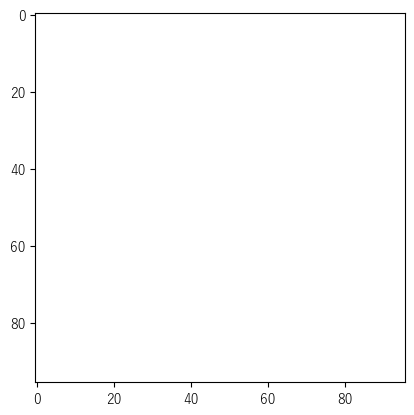

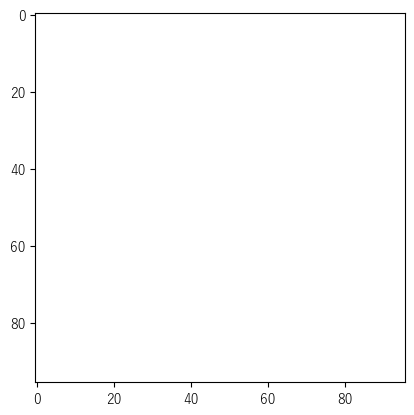

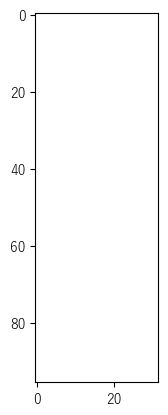

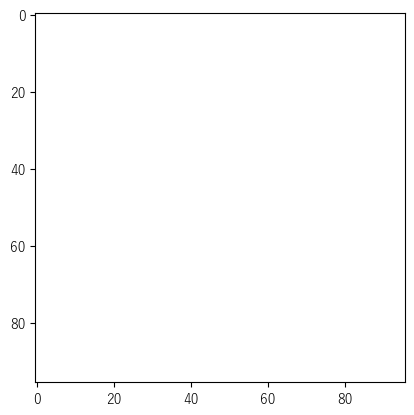

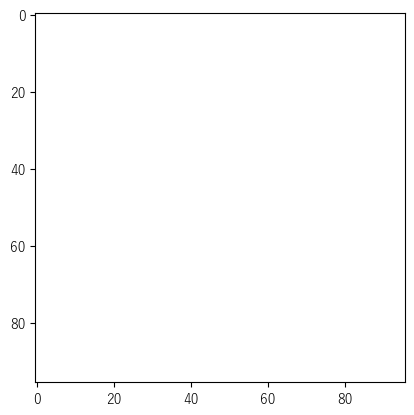

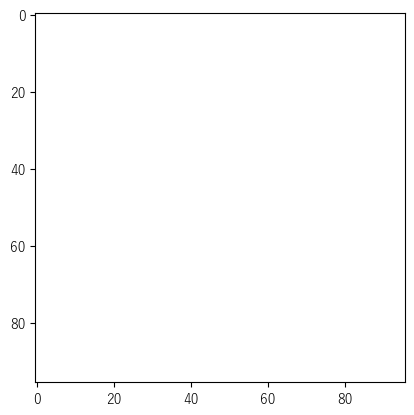

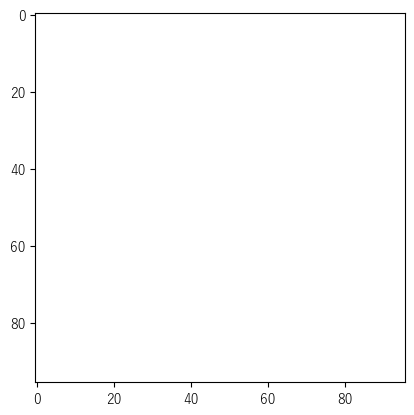

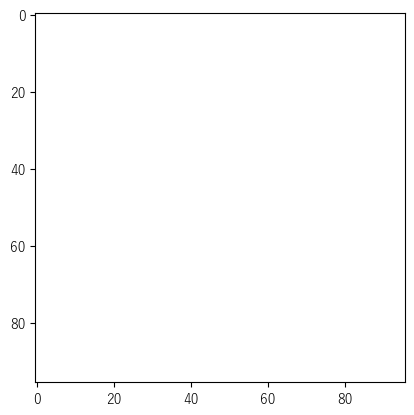

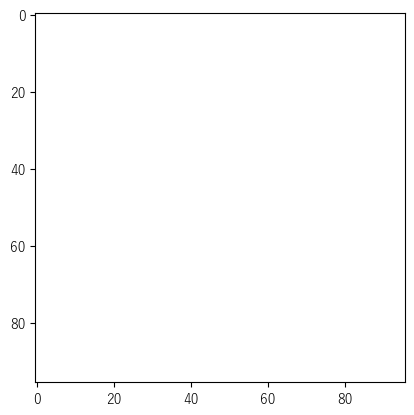

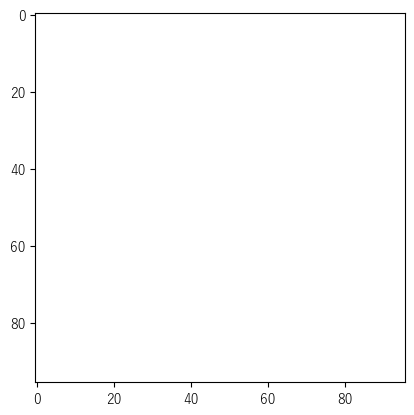

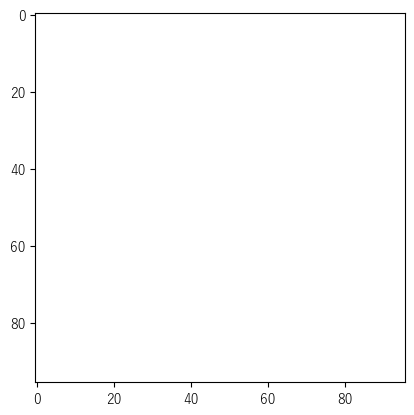

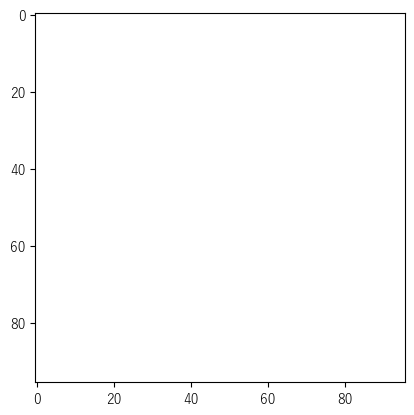

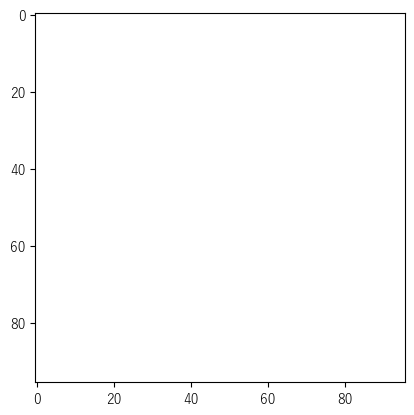

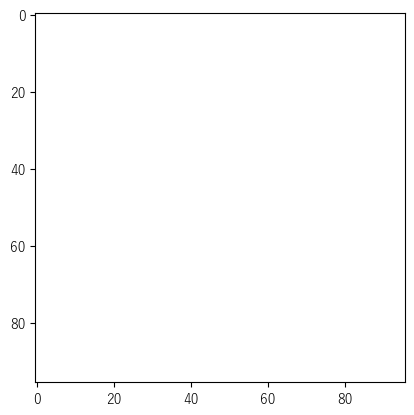

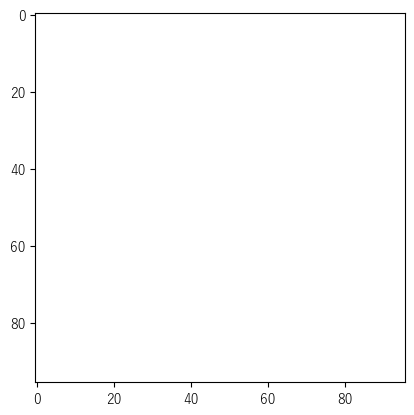

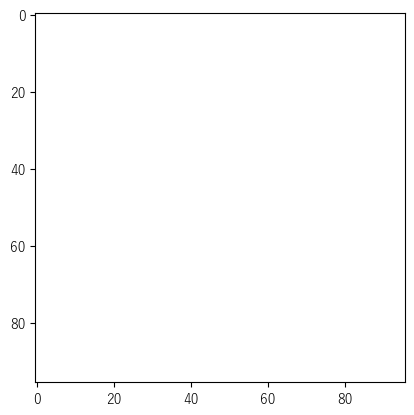

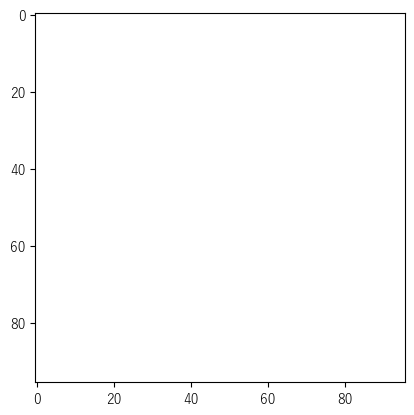

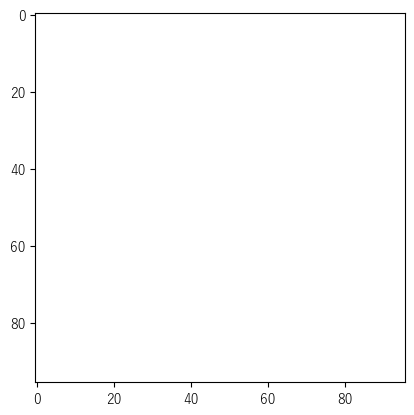

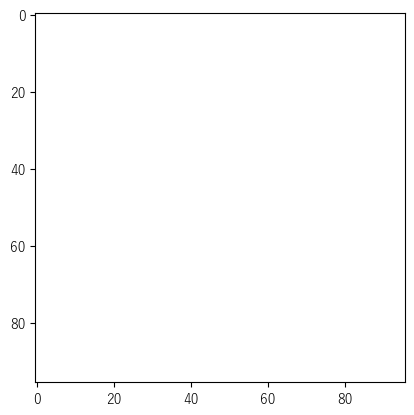

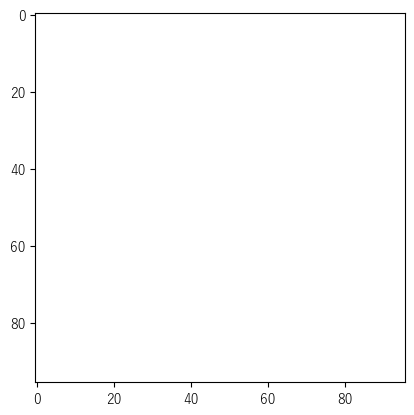

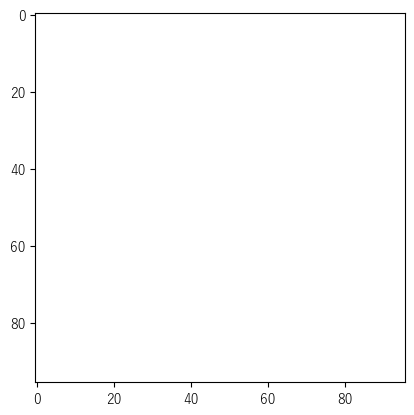

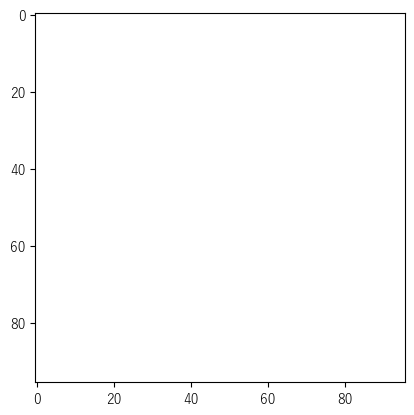

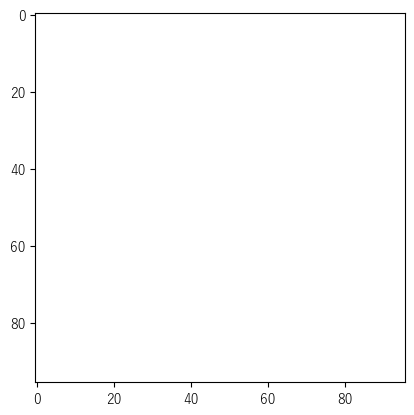

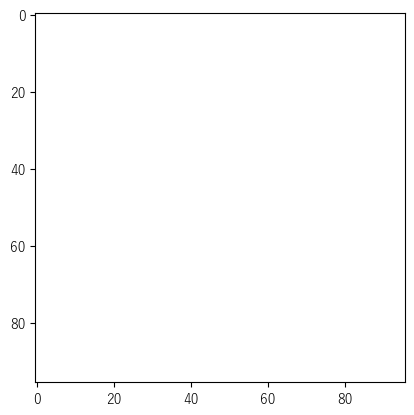

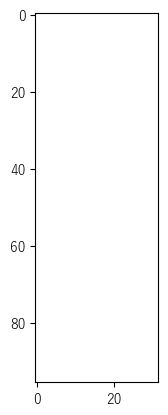

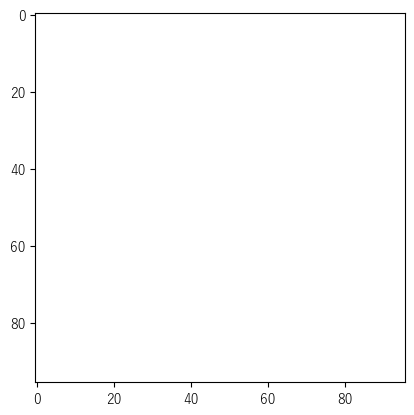

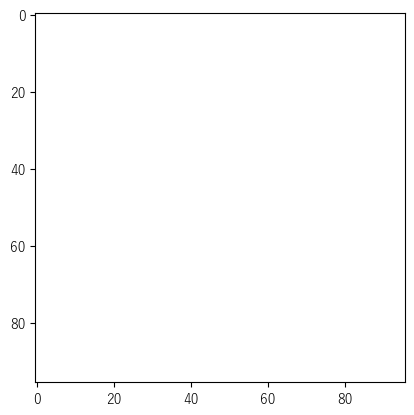

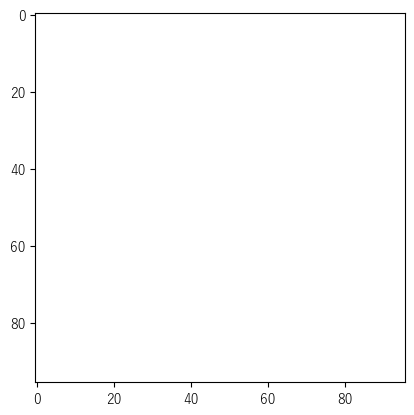

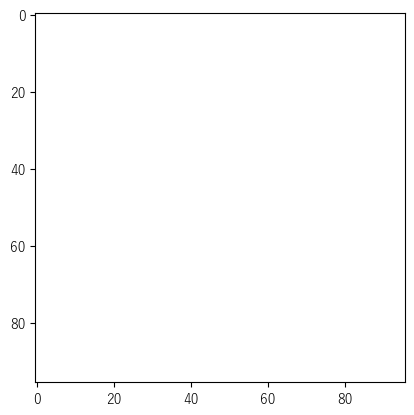

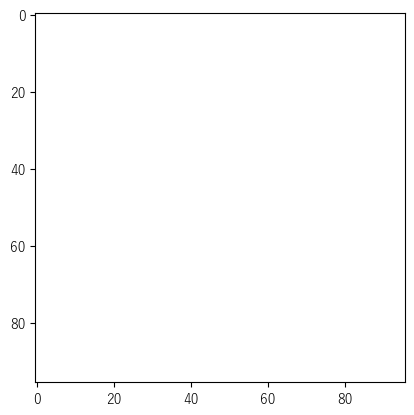

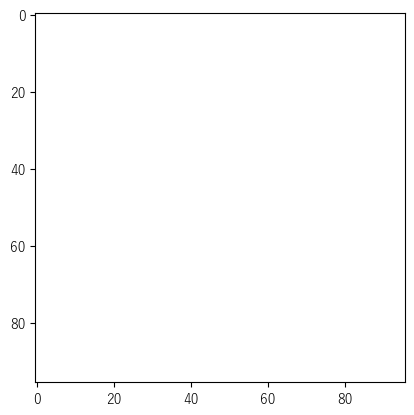

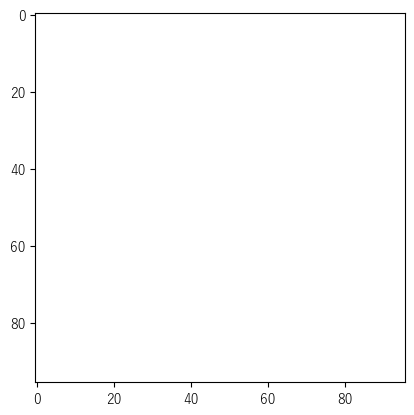

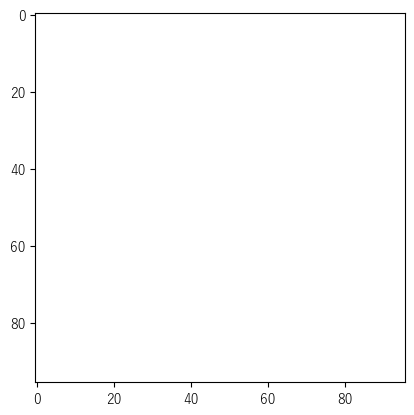

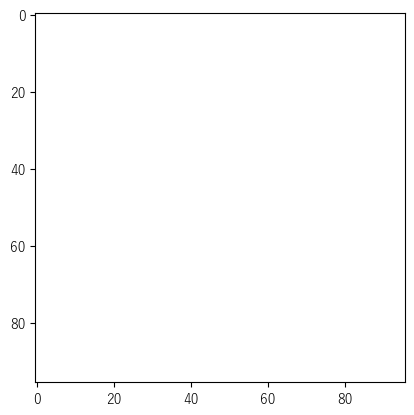

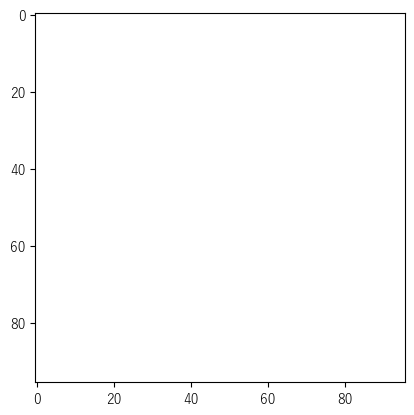

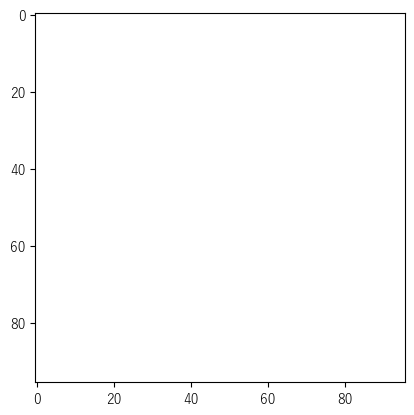

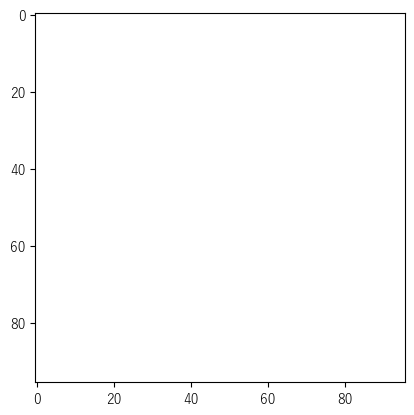

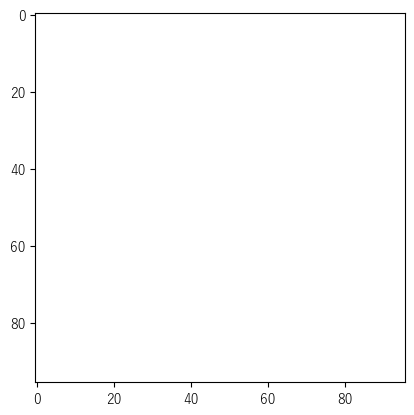

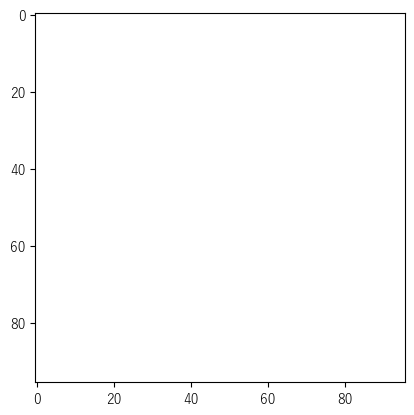

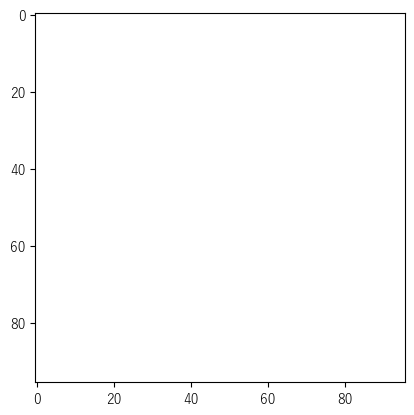

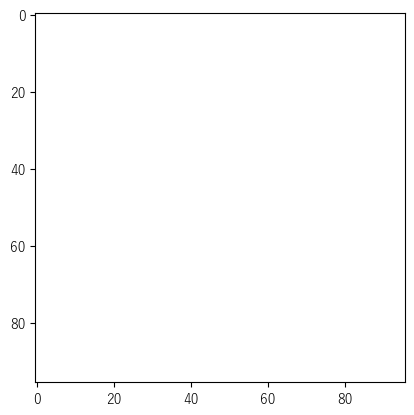

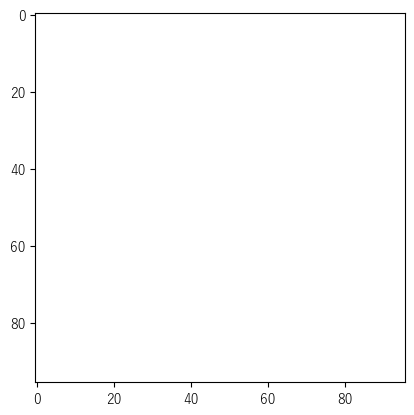

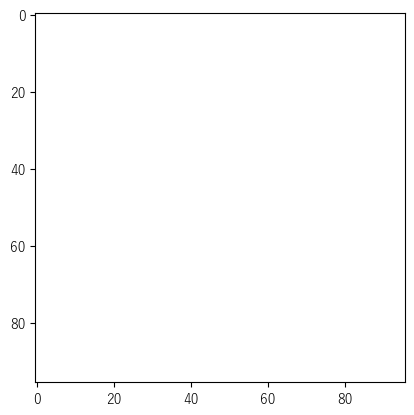

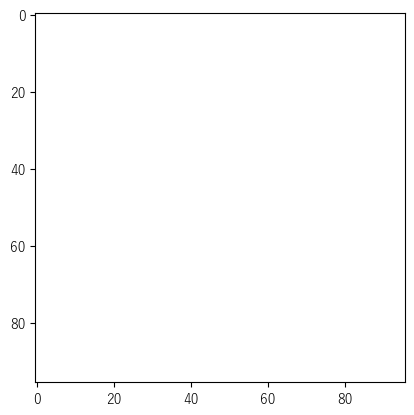

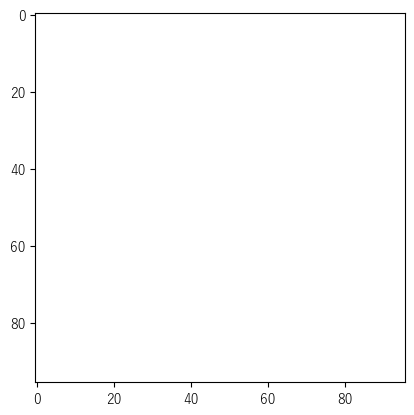

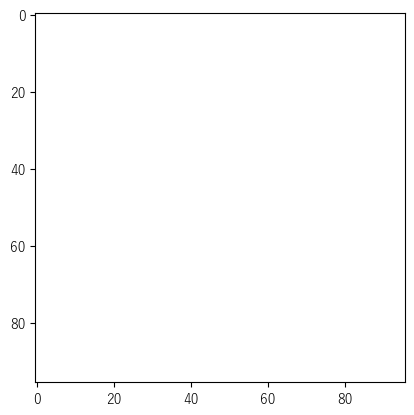

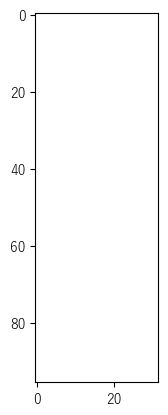

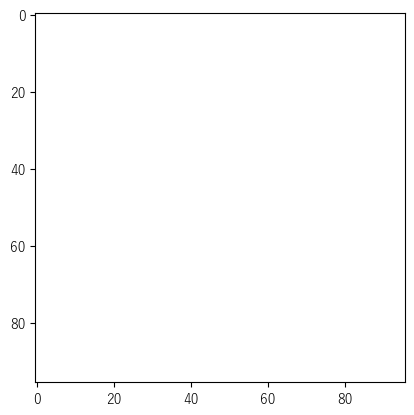

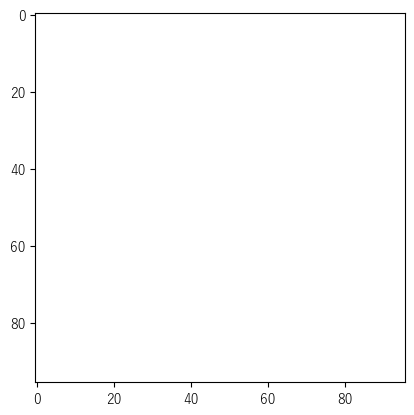

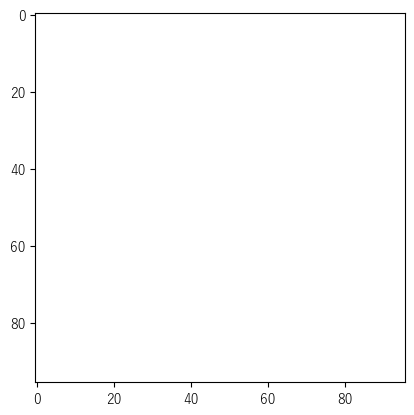

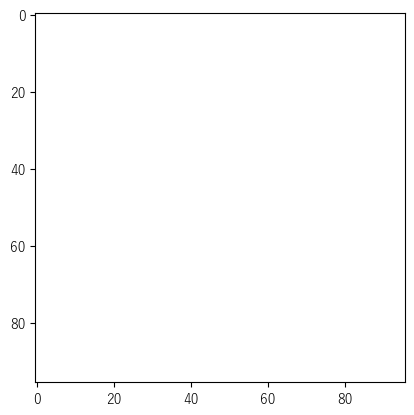

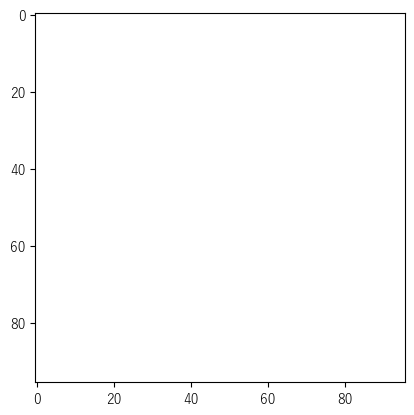

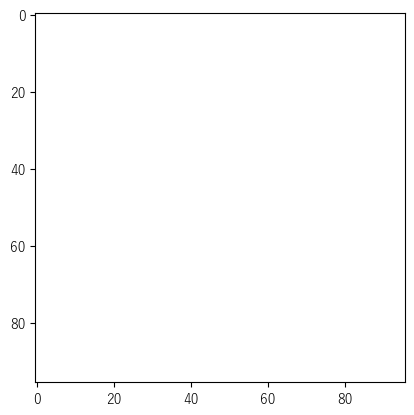

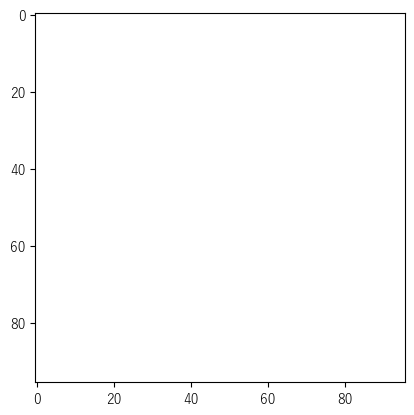

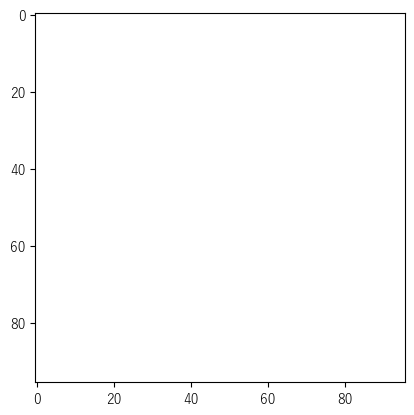

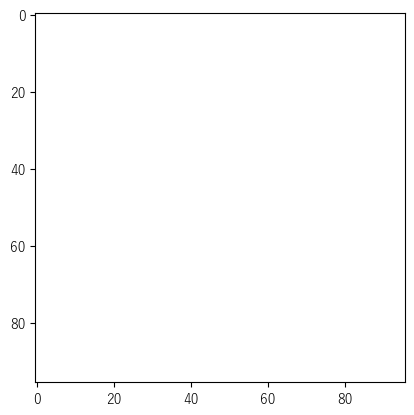

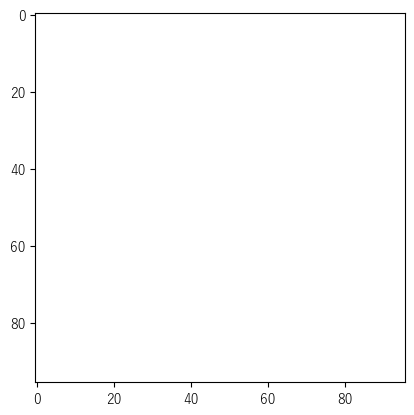

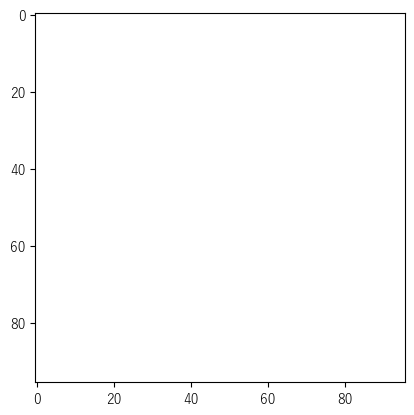

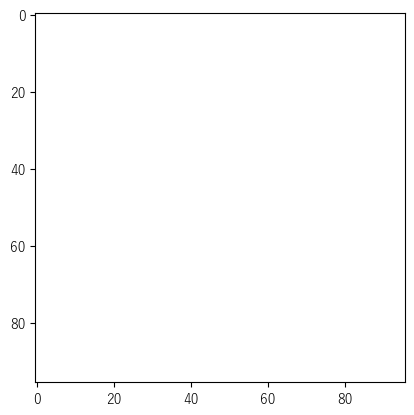

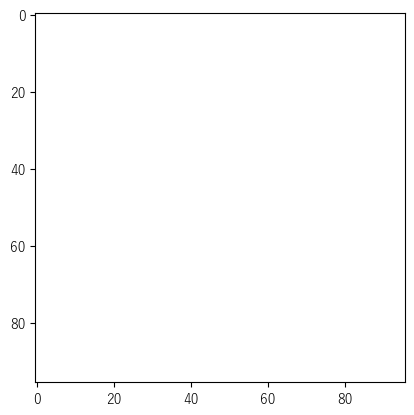

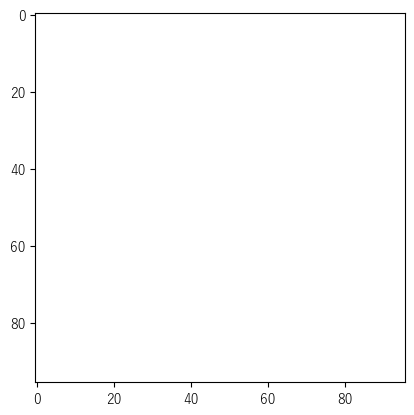

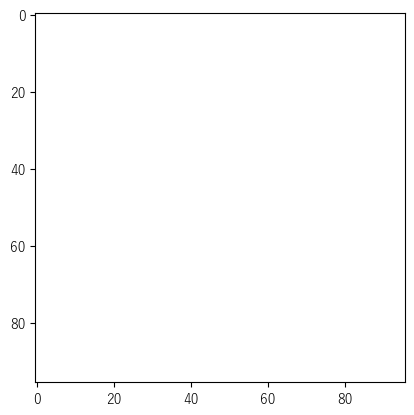

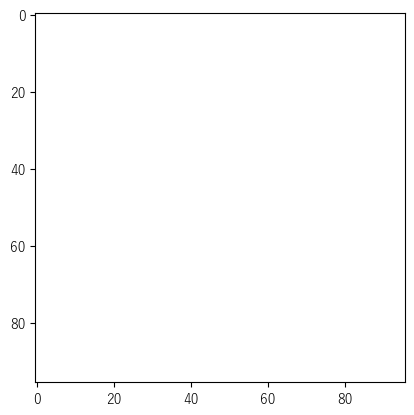

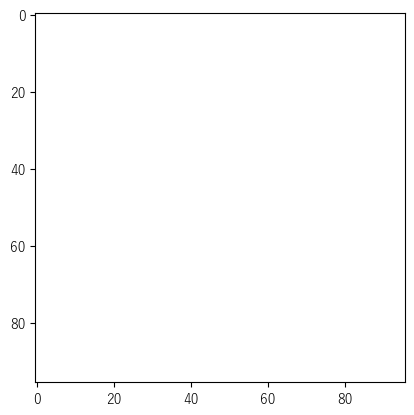

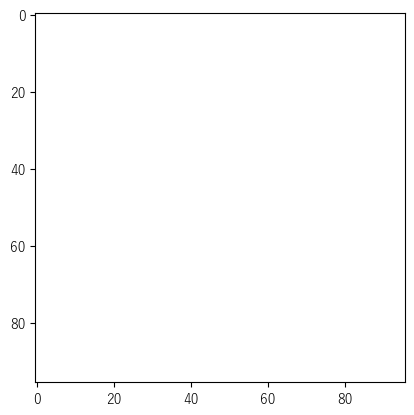

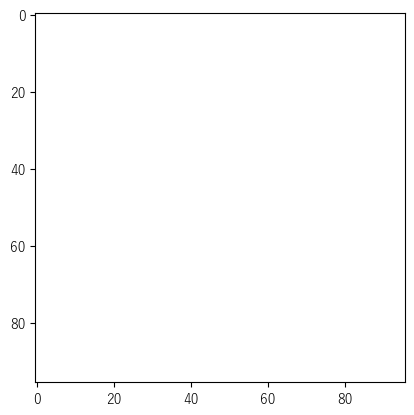

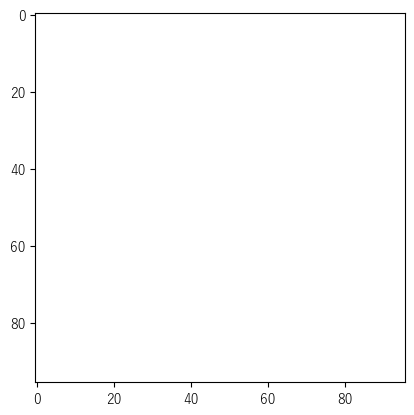

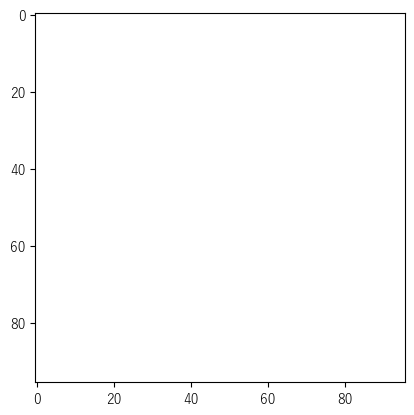

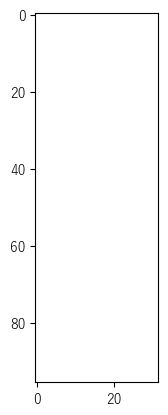

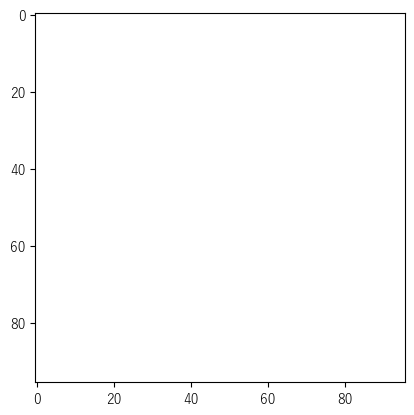

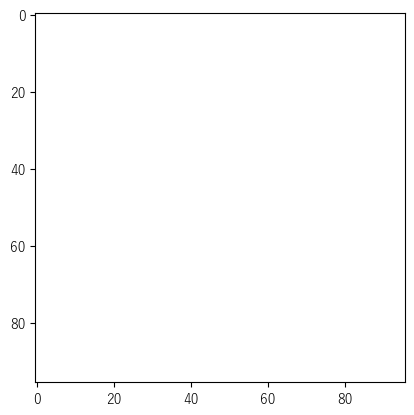

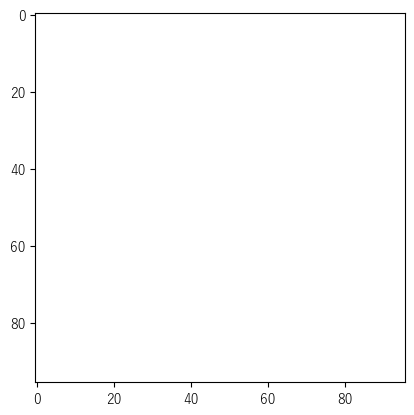

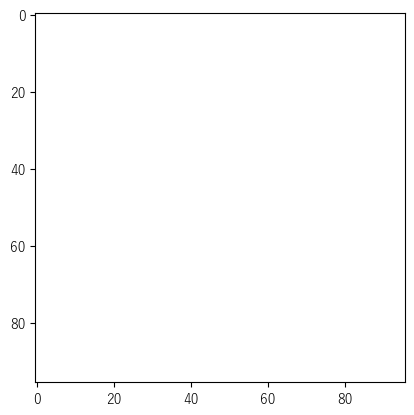

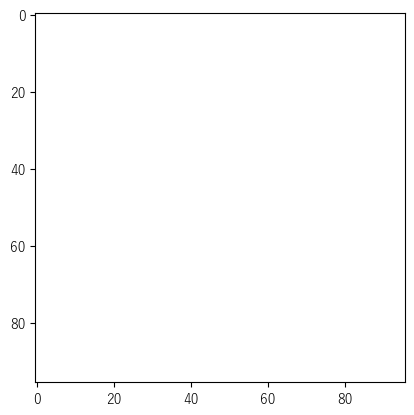

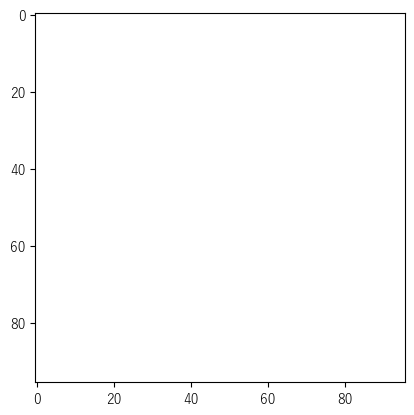

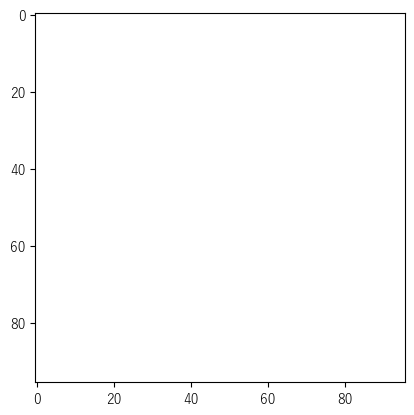

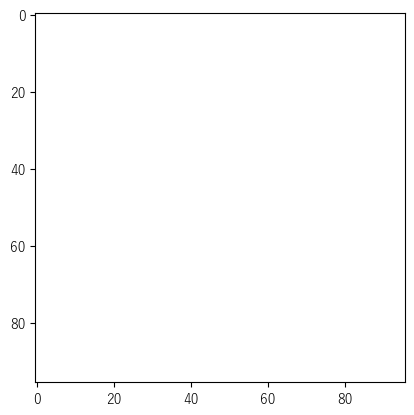

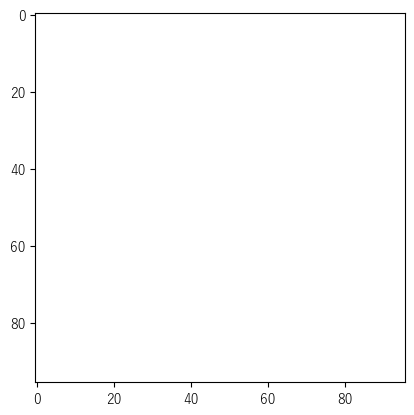

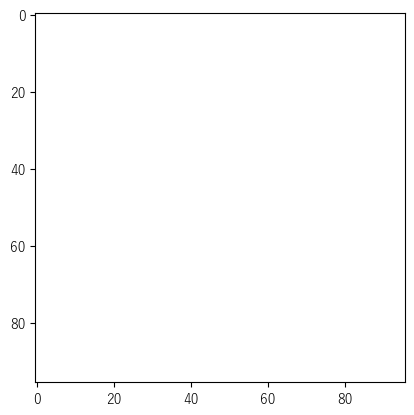

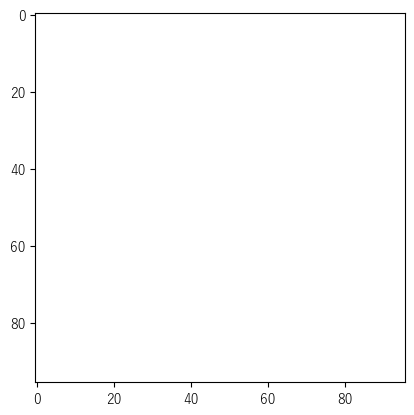

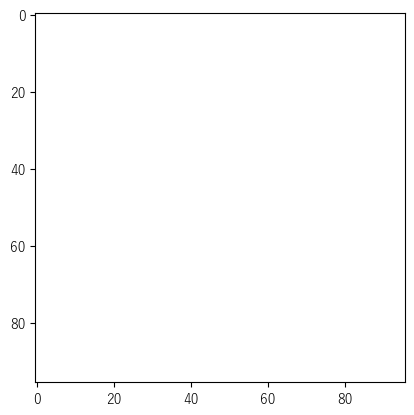

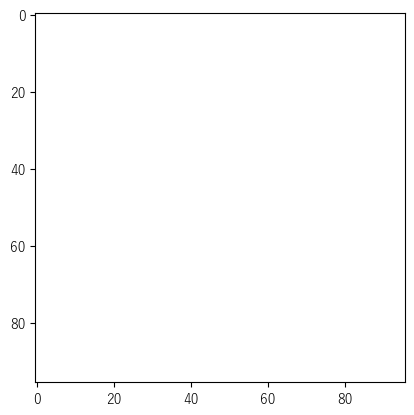

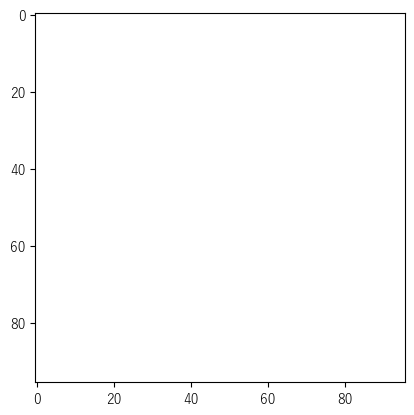

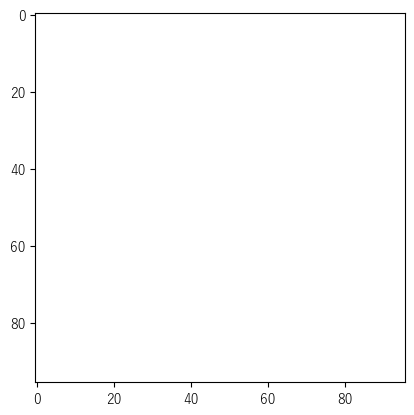

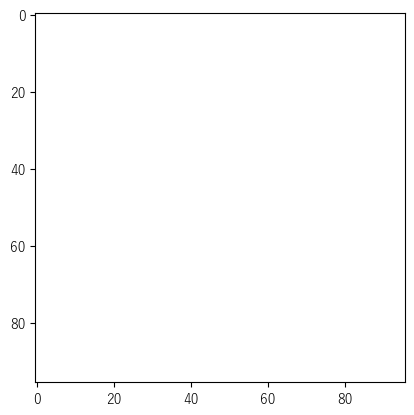

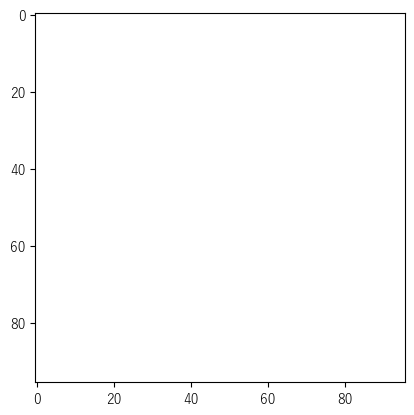

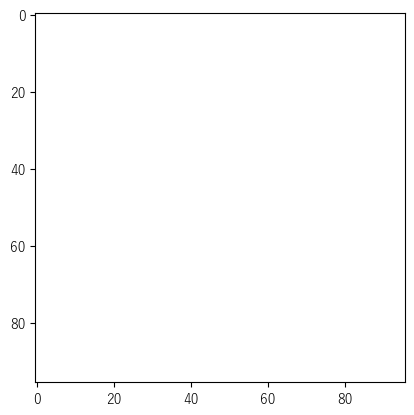

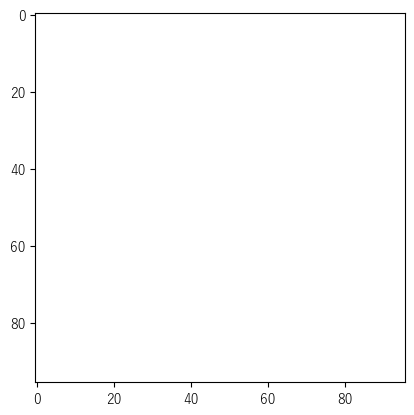

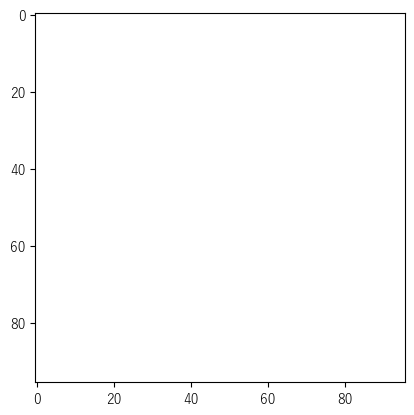

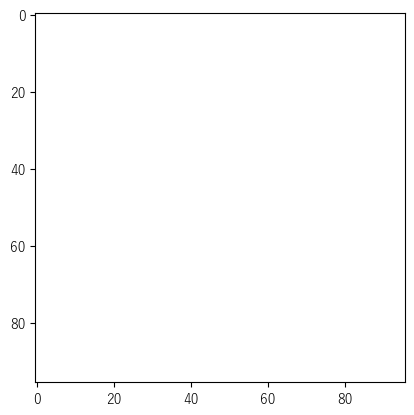

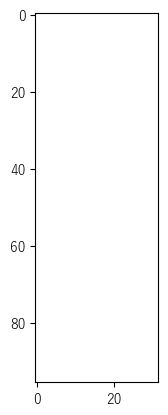

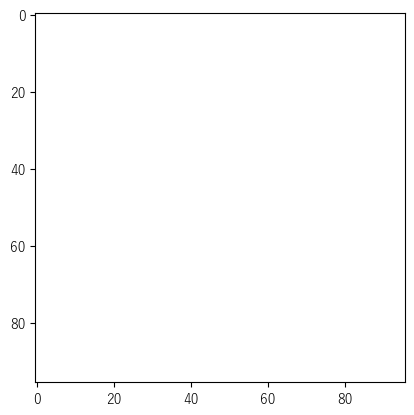

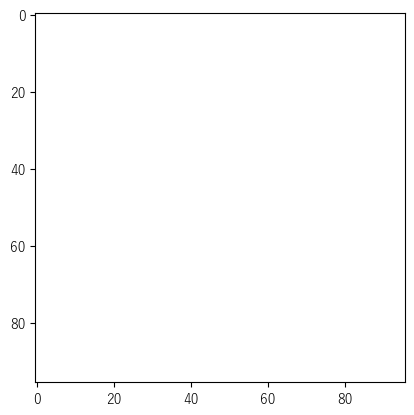

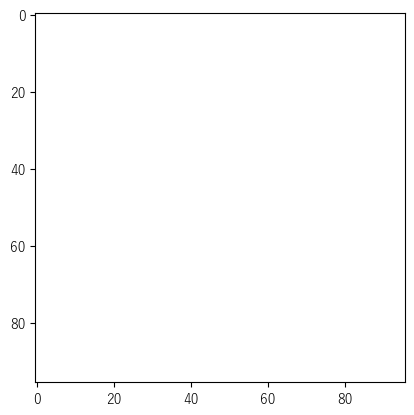

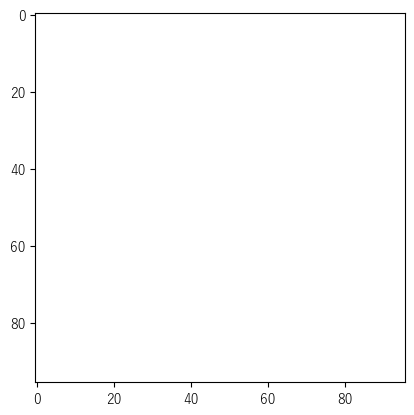

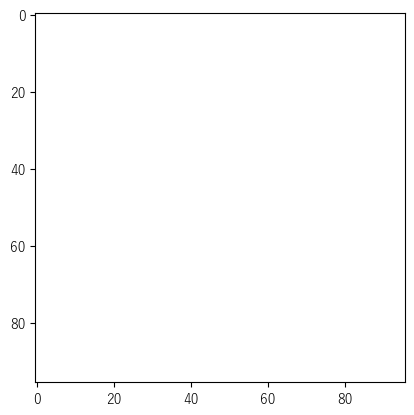

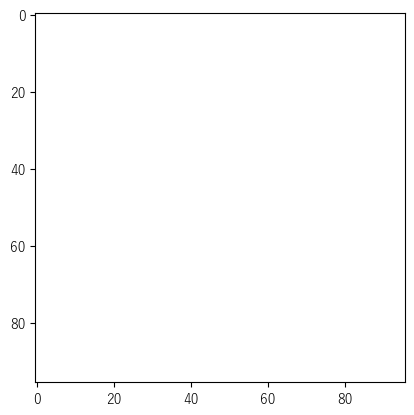

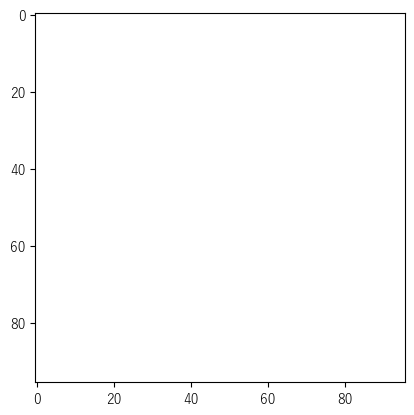

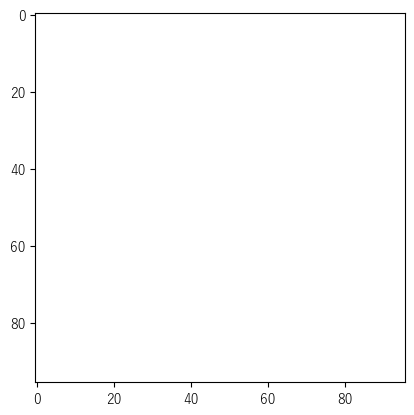

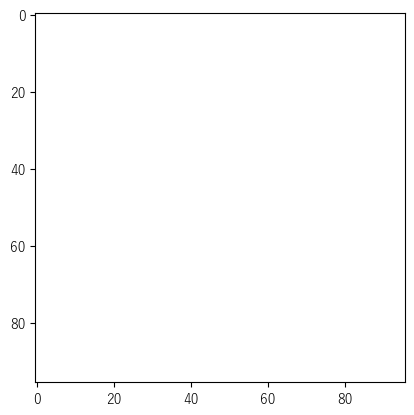

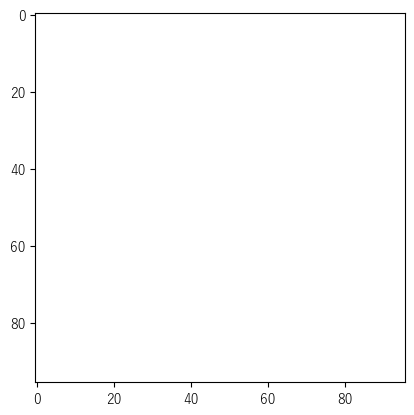

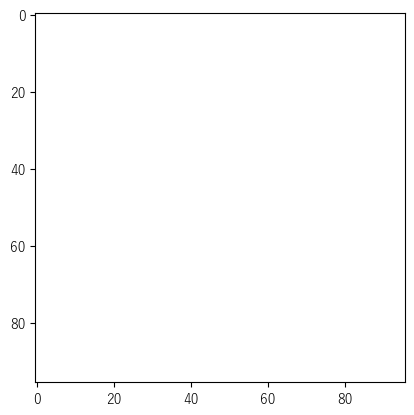

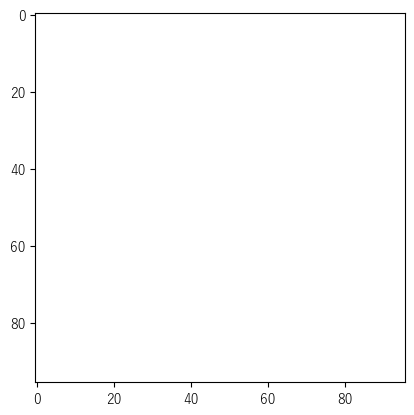

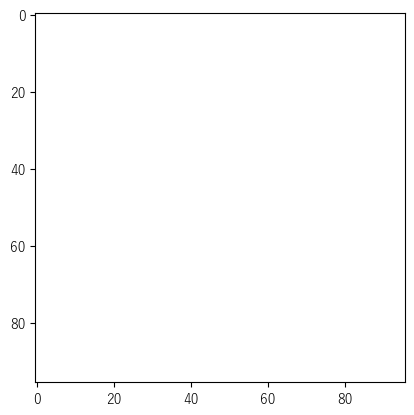

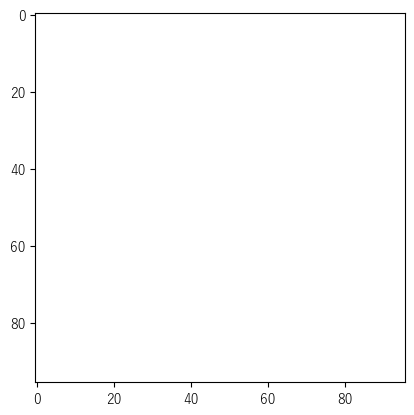

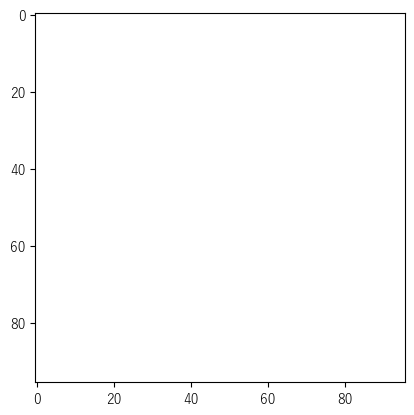

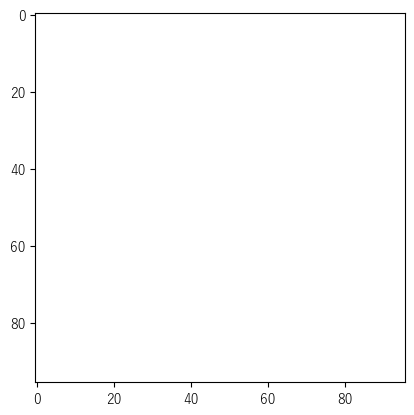

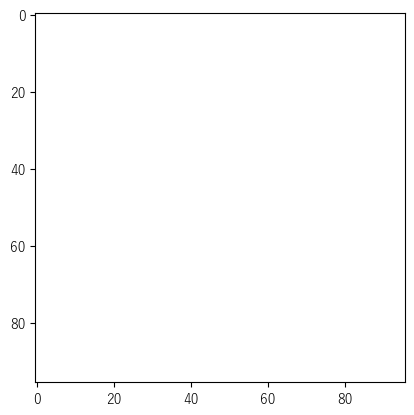

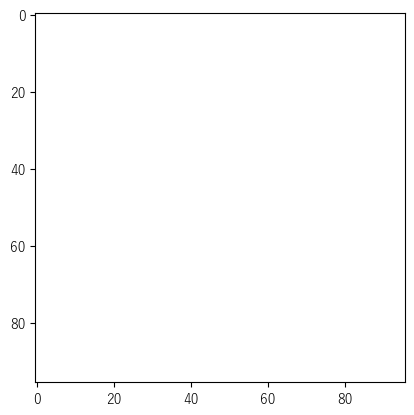

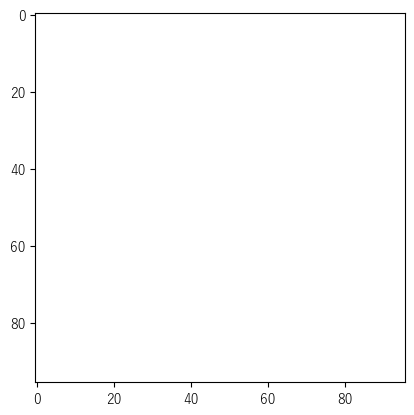

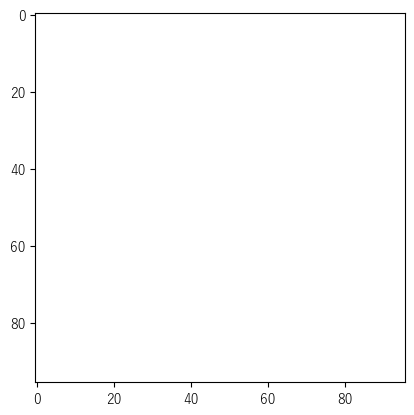

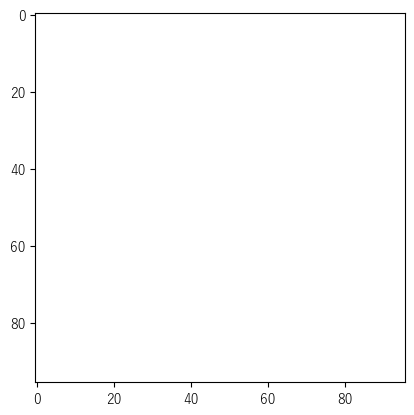

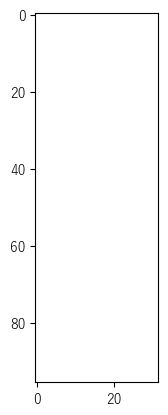

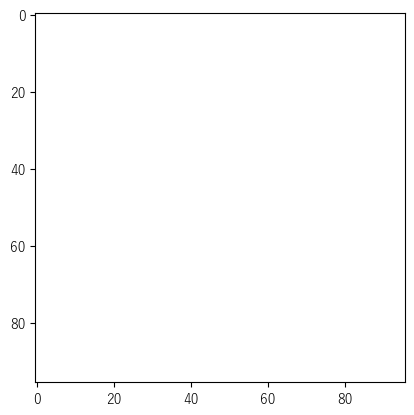

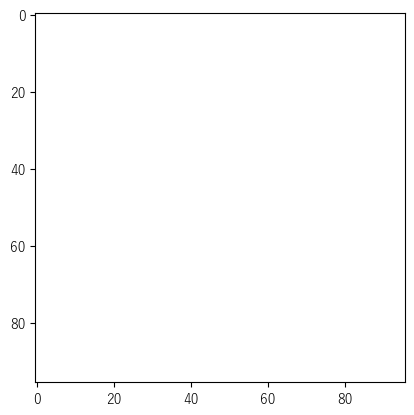

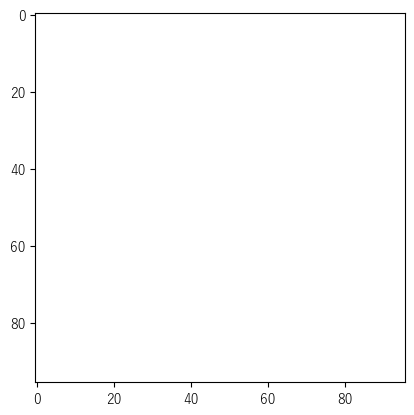

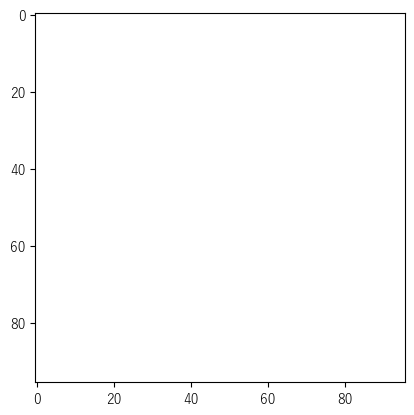

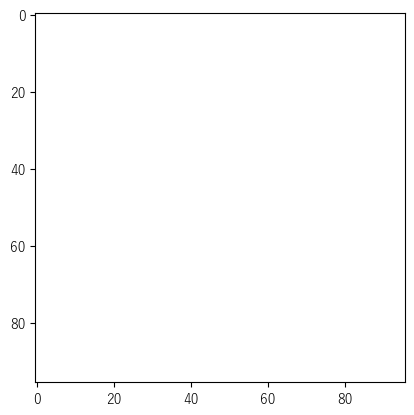

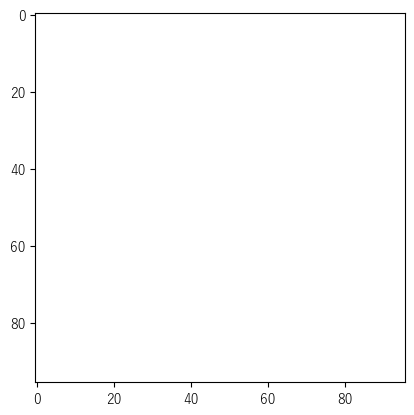

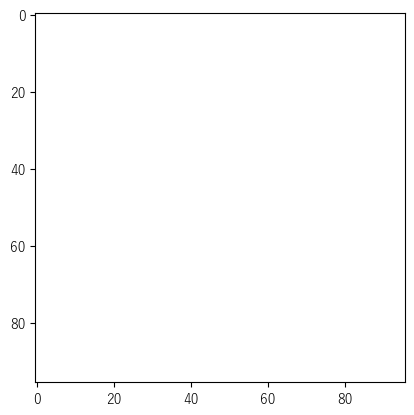

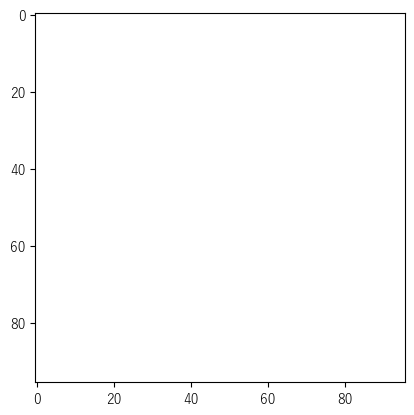

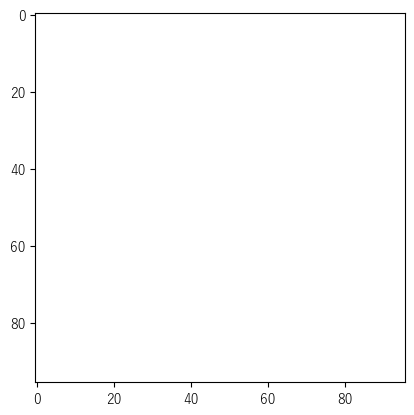

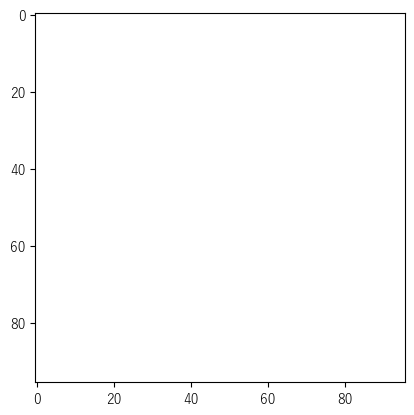

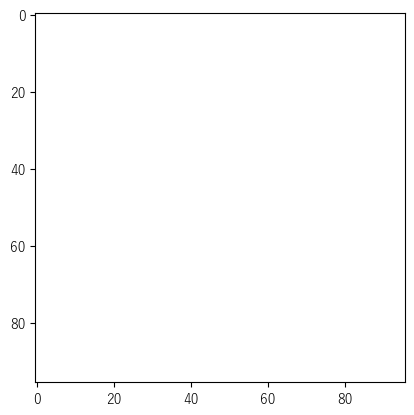

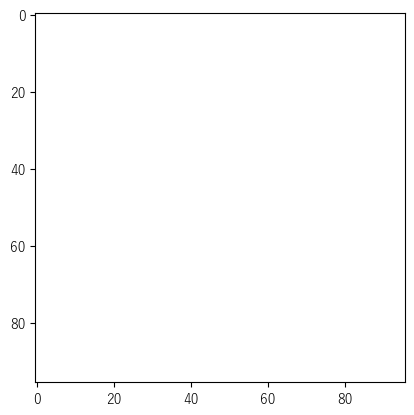

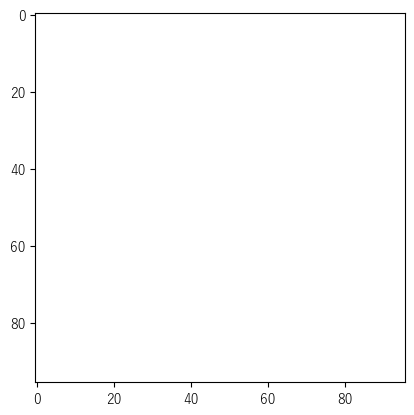

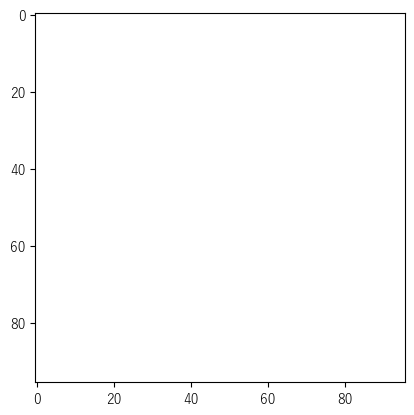

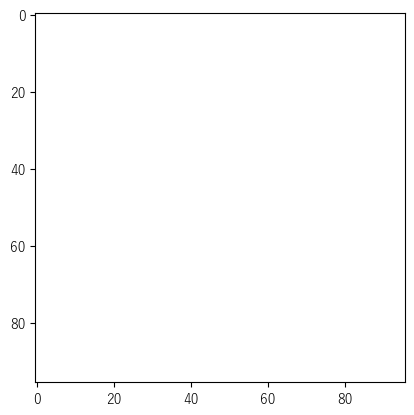

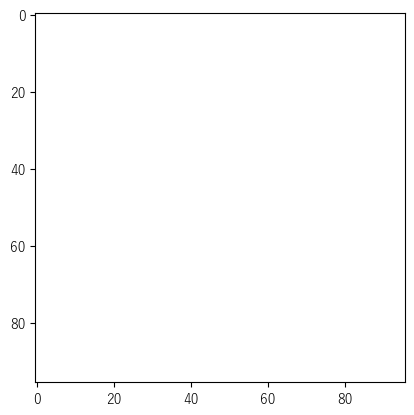

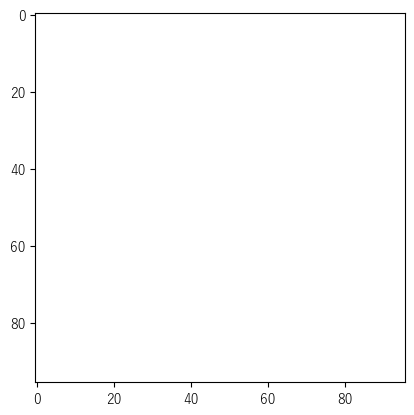

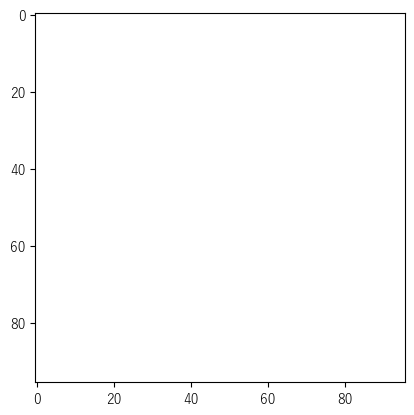

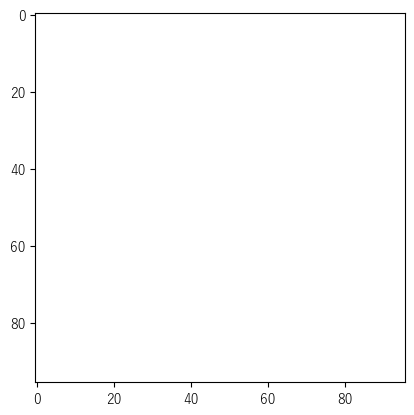

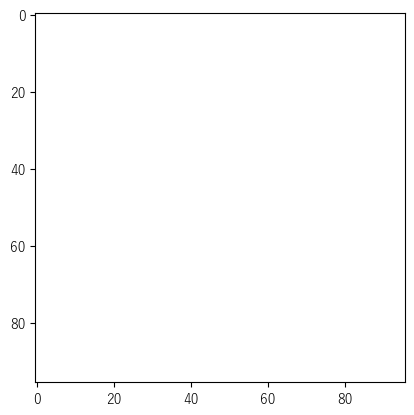

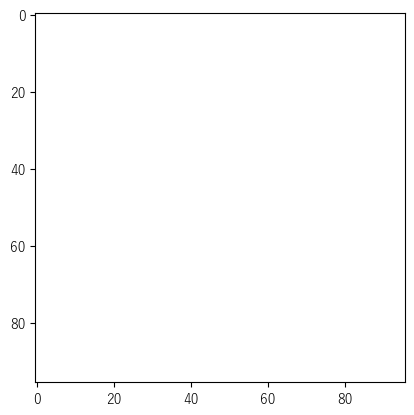

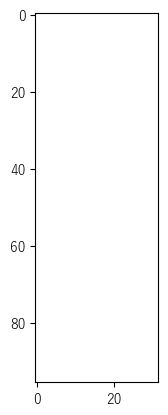

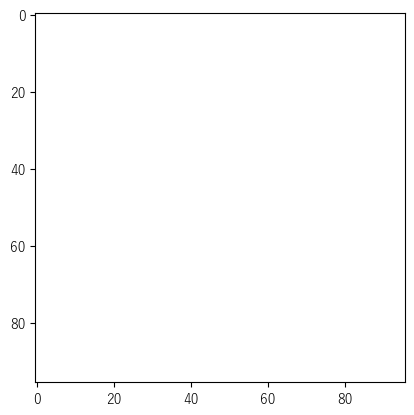

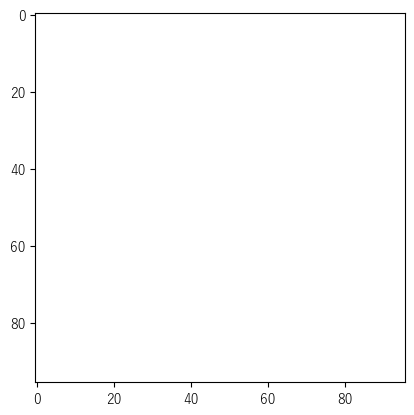

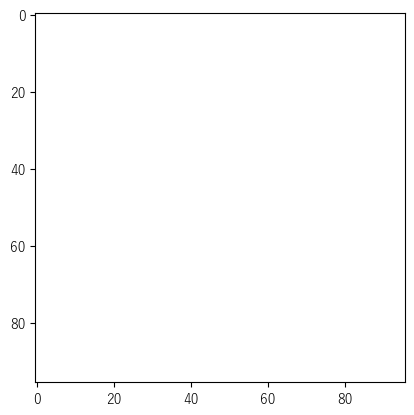

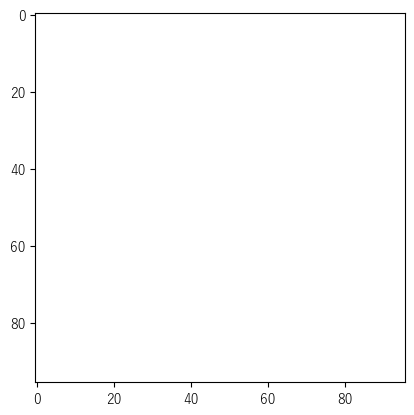

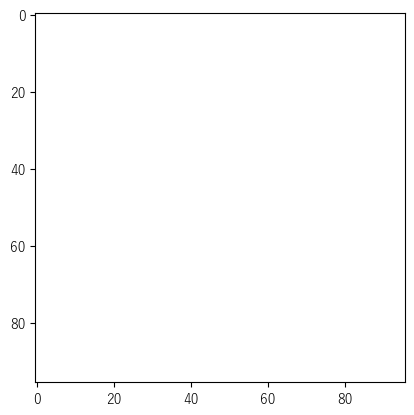

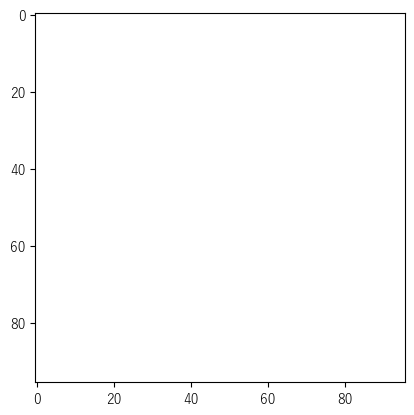

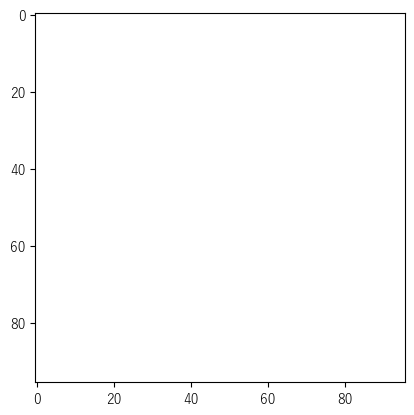

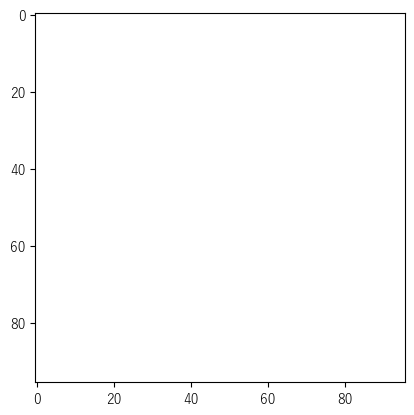

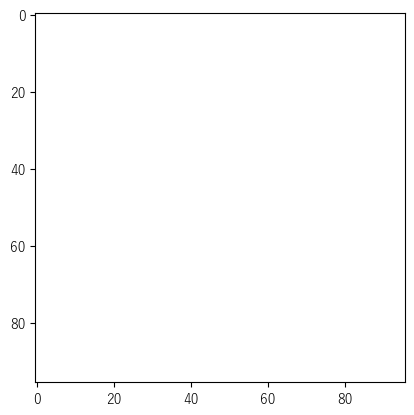

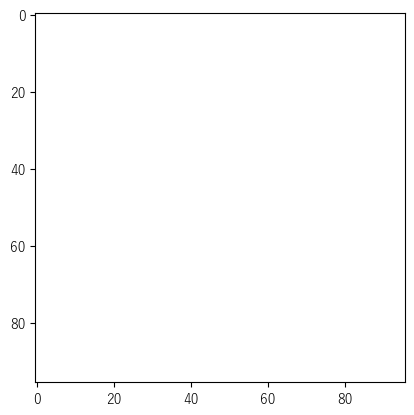

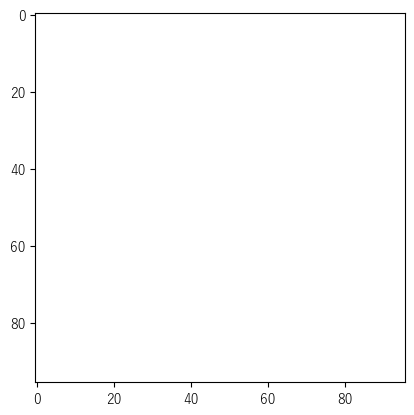

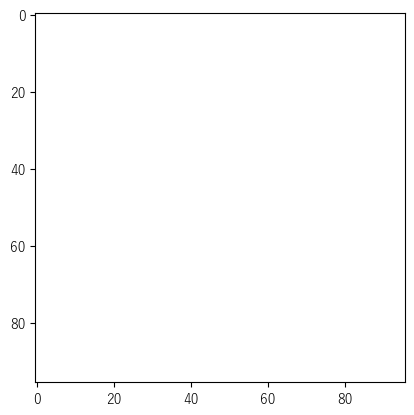

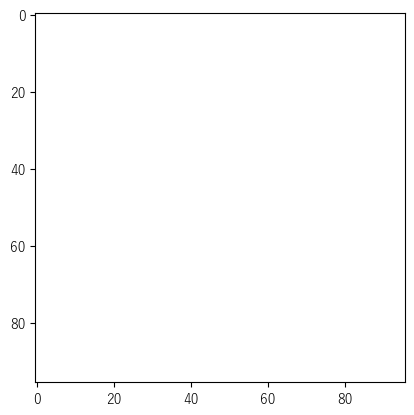

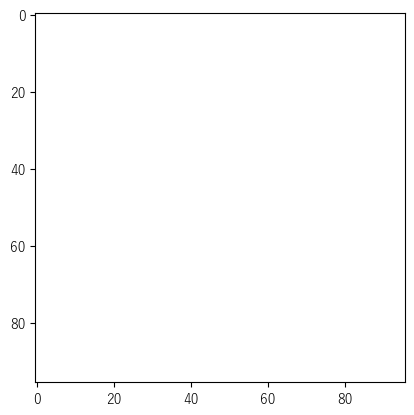

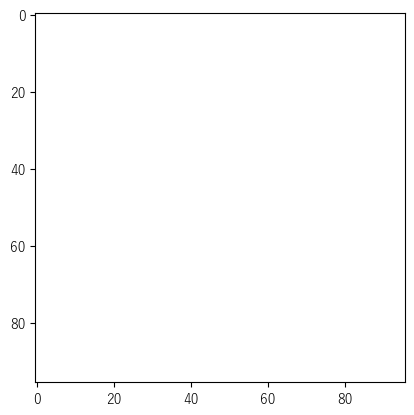

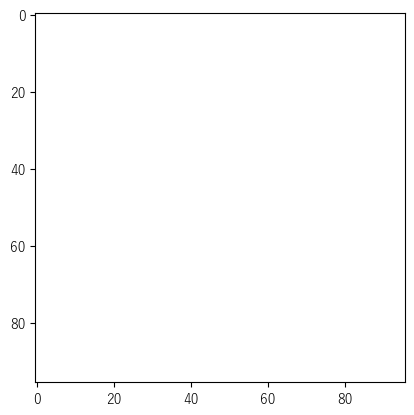

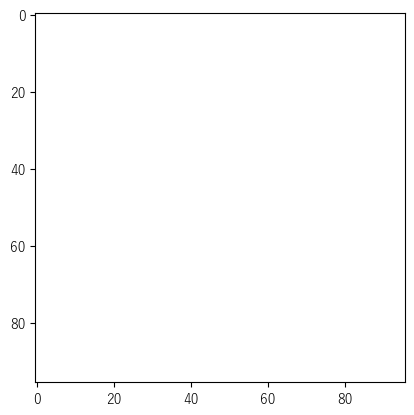

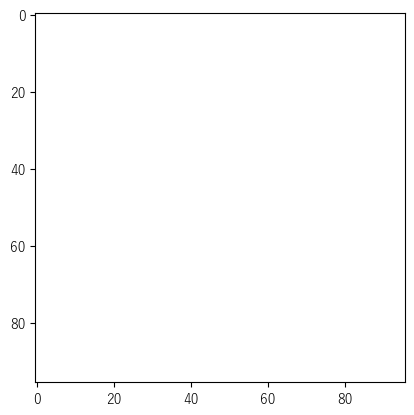

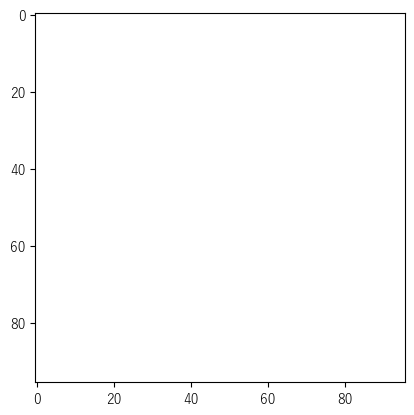

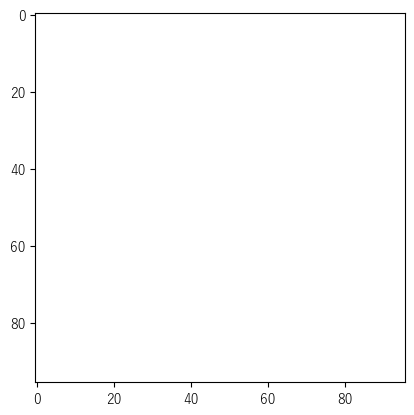

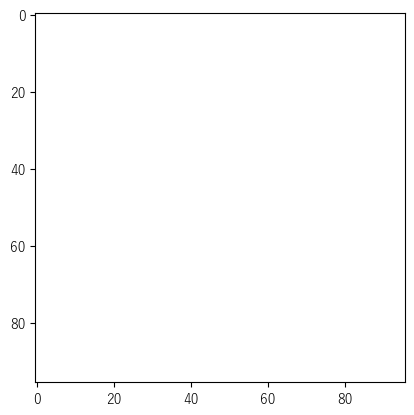

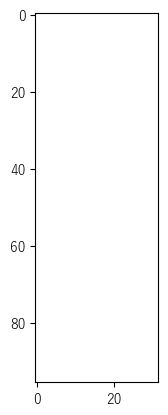

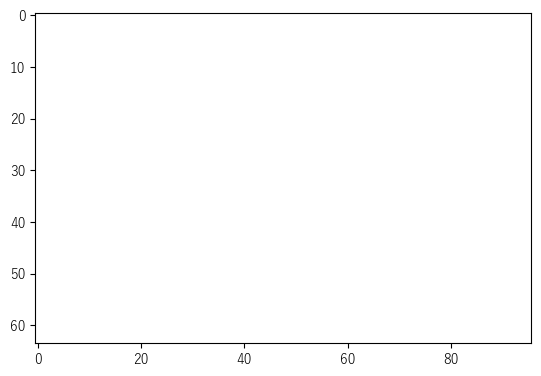

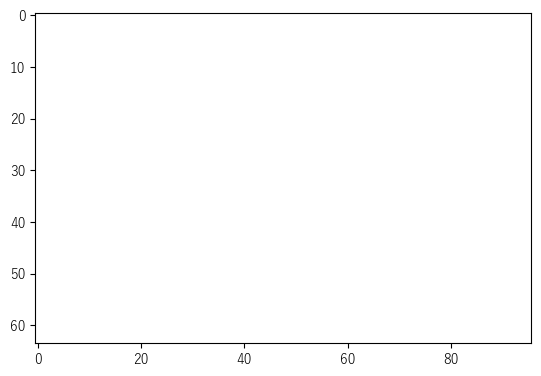

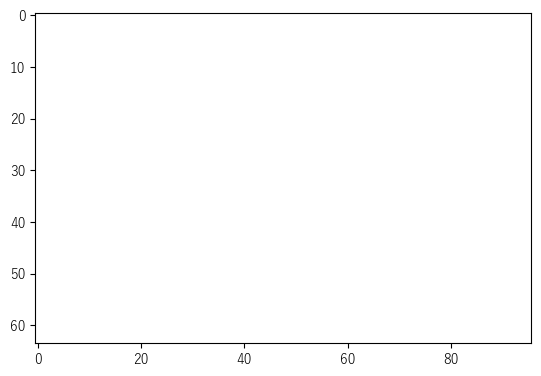

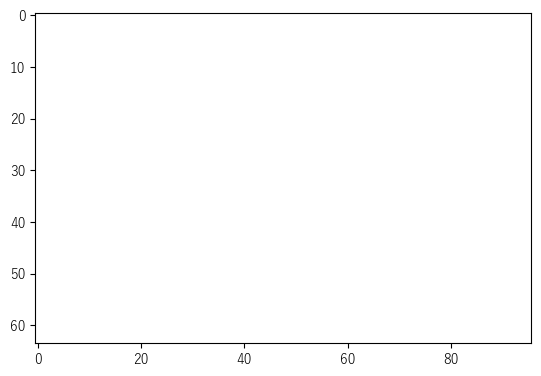

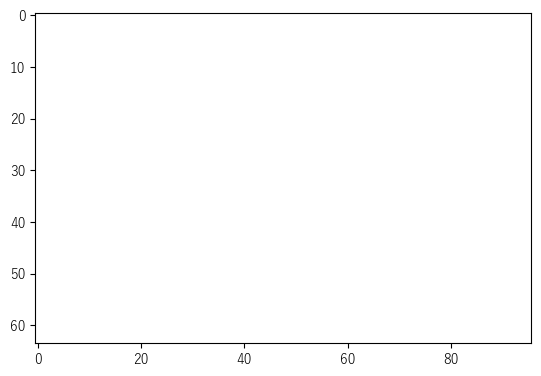

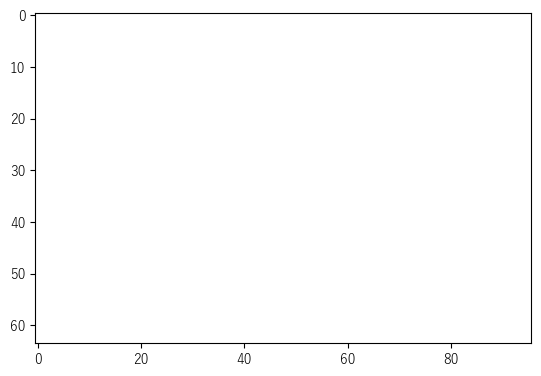

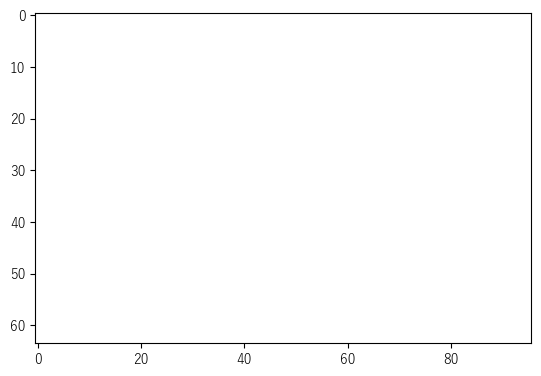

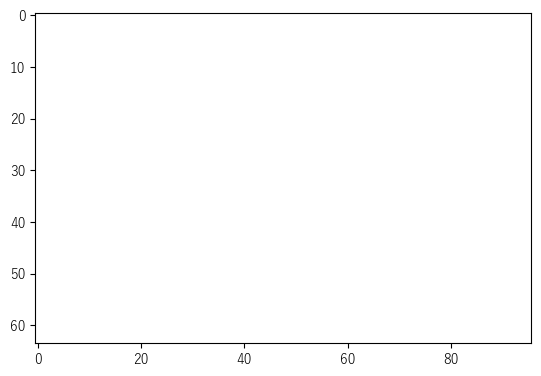

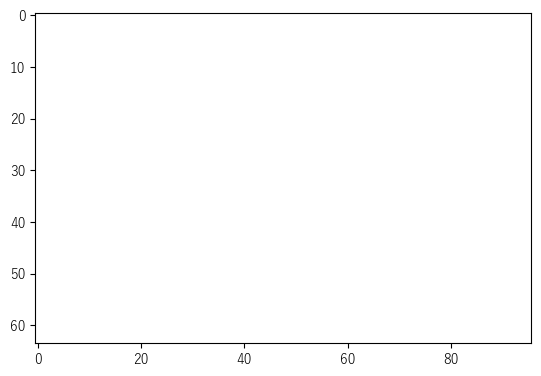

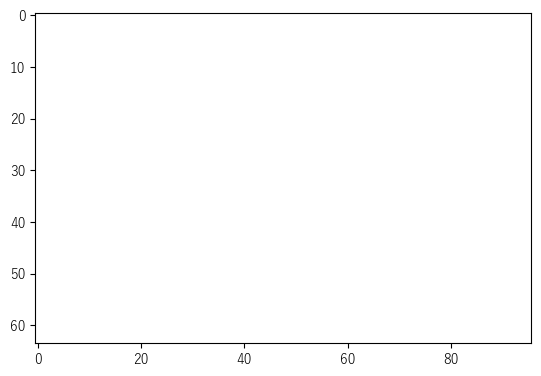

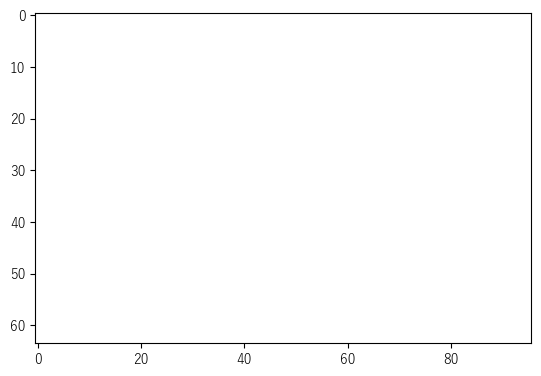

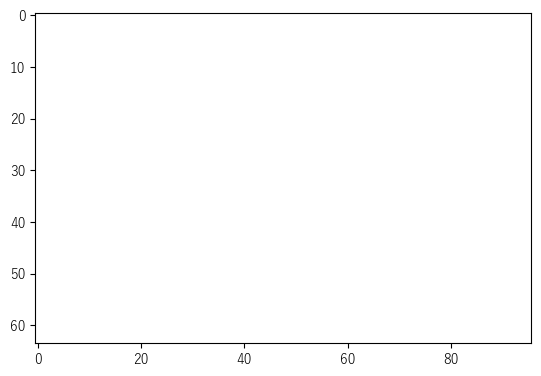

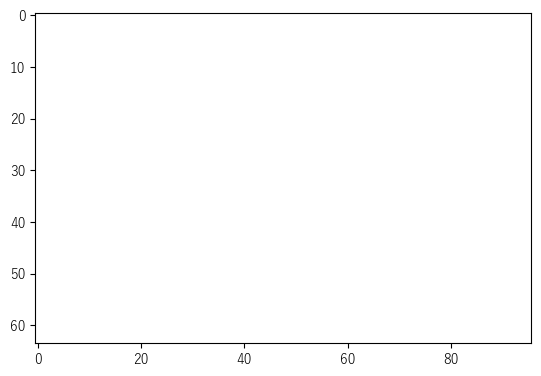

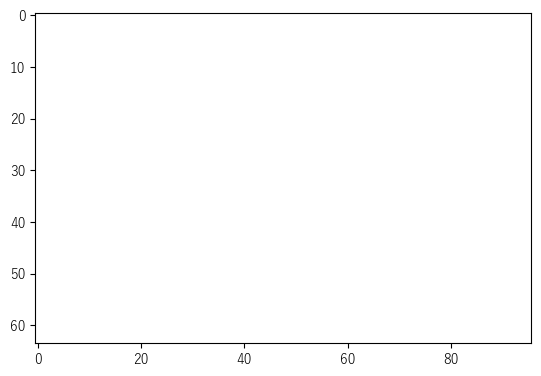

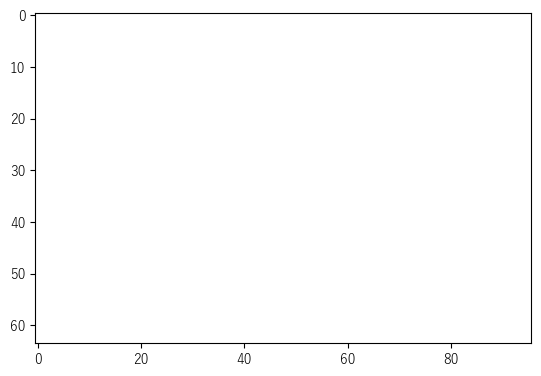

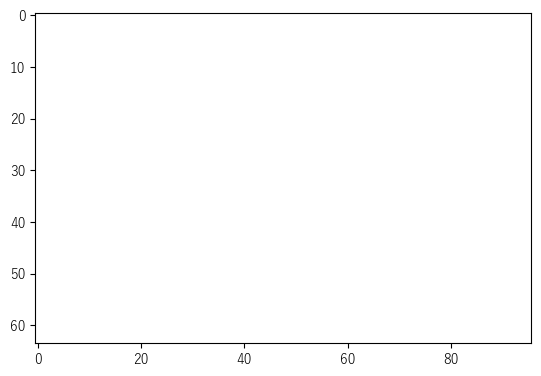

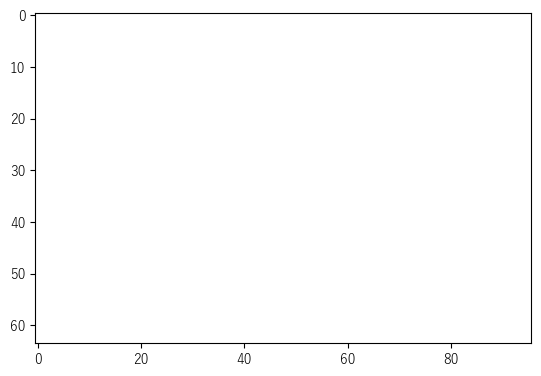

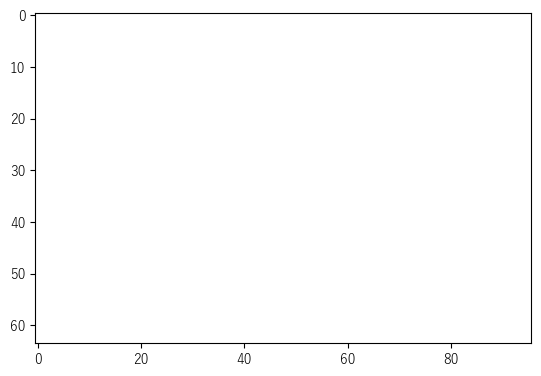

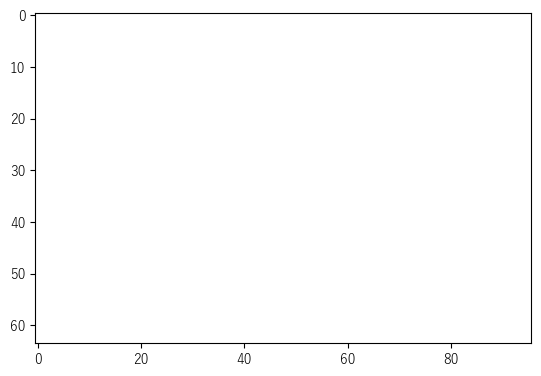

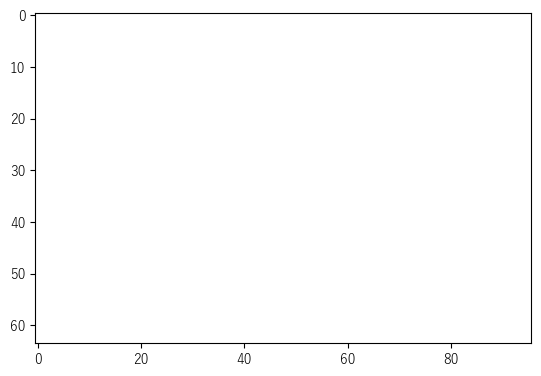

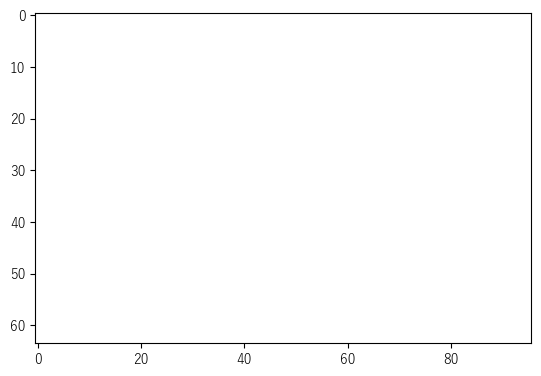

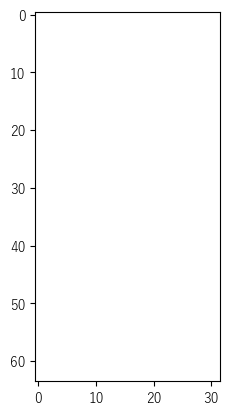

<Figure size 640x480 with 0 Axes>

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

# どれか1つ通るものを使ってください（環境により入っているフォントが違います）
mpl.rcParams["font.family"] = "Yu Gothic"   # 例: Windows標準のことが多い
# mpl.rcParams["font.family"] = "Meiryo"
# mpl.rcParams["font.family"] = "MS Gothic"

# ついでによくある「マイナス記号が□」問題を回避
mpl.rcParams["axes.unicode_minus"] = False

def _build_class_name_fn(mapper):
    # class_id -> 表示文字
    inv_kana = {v: k for k, v in mapper._kana_to_id.items()}  # class_id -> codepoint

    def name(cid: int) -> str:
        if cid < 0:
            return ""
        if cid == 0:
            return "漢"  # 漢字(others)
        cp = inv_kana.get(cid, None)
        if cp is None:
            return f"c{cid}"
        return chr(cp)  # かなは実文字
    return name

def visualize_majority_label_grid(
    sample: dict,
    tile: int = 128,
    min_labeled_ratio: float = 0.02,
    draw_grid: bool = True,
):
    """
    sample: ClusteringDataset の 1サンプル dict
      sample["image"]    : (3,H,W)
      sample["label_map"]: (H,W,C)
      sample["meta"]     : mapperは sample ではなく dataset.mapper から取る想定でもOK
    tile: タイルの一辺(px)
    min_labeled_ratio: タイル内の「ラベル付き画素」割合がこれ未満なら表示しない
    """
    img_t = sample["image"]
    label_map_t = sample["label_map"]
    mapper = sample.get("mapper", None)  # 任意
    if mapper is None:
        # Notebookでは train_ds.mapper を使う想定
        raise ValueError('sample["mapper"] が無いので、sampleに mapper を入れるか train_ds.mapper を渡す形にしてください')

    img = img_t.permute(1, 2, 0).detach().cpu().numpy()  # (H,W,3)
    label_map = label_map_t.detach().cpu()               # (H,W,C)
    H, W, C = label_map.shape

    class_name = _build_class_name_fn(mapper)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    ax.set_title(f"majority label per {tile}x{tile} tile")
    ax.axis("off")

    # タイルごとに集計
    for y0 in range(0, H, tile):
        y1 = min(y0 + tile, H)
        for x0 in range(0, W, tile):
            x1 = min(x0 + tile, W)

            block = label_map[y0:y1, x0:x1, :]  # (h,w,C)
            # 背景(全0画素)を除外(
            labeled = (block.sum(dim=-1) > 0)    # (h,w)
            plt.imshow(labeled.cpu().numpy(), alpha=0)  # ダミー表示で範囲合わせ
            plt.show()
            labeled_count = int(labeled.sum().item())
            area = (y1 - y0) * (x1 - x0)

            if labeled_count == 0 or labeled_count / area < min_labeled_ratio:
                continue

            # クラス別の「ラベル付き画素での合計」を出す
            # (h,w,C) -> (C,)
            counts = block[labeled].sum(dim=0)  # float合計（one-hotなので画素数に等しい）
            cid = int(torch.argmax(counts).item())

            text = class_name(cid)
            if not text:
                continue

            cx = (x0 + x1) / 2
            cy = (y0 + y1) / 2

            ax.text(
                cx, cy, text,
                ha="center", va="center",
                fontsize=10,
                color="white",
                bbox=dict(facecolor="black", alpha=0.45, pad=1, edgecolor="none"),
            )

            if draw_grid:
                ax.add_patch(
                    plt.Rectangle(
                        (x0, y0), x1 - x0, y1 - y0,
                        fill=False, edgecolor="yellow", linewidth=0.3, alpha=0.6
                    )
                )

    plt.tight_layout()
    plt.show()

# --- 使い方例 ---
# sample に mapper を入れてから呼ぶ（簡単）
sample = train_ds[6]
sample["mapper"] = train_ds.mapper
visualize_majority_label_grid(sample, tile=96, min_labeled_ratio=0.02, draw_grid=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchTransformerSep(nn.Module):
    def __init__(self, img_channels=3, big_patch_size=256, vit_patch_size=16,
                 d_model=256, nhead=8, num_layers=4, num_classes=2):
        super().__init__()
        self.big_patch_size = big_patch_size     # 256
        self.vit_patch_size = vit_patch_size     # 16
        self.img_channels = img_channels

        inner_patch_dim = img_channels * vit_patch_size * vit_patch_size
        self.patch_embed = nn.Linear(inner_patch_dim, d_model)

        max_tokens = (big_patch_size // vit_patch_size) ** 2  # 256
        self.pos_embed = nn.Parameter(torch.zeros(1, max_tokens, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # ★ここが「出力層の形」: Cクラスぶん出す
        self.head = nn.Conv2d(d_model, num_classes, kernel_size=1)

    def forward(self, img):
        """
        img: (B, 3, H, W), H,W は 256 の倍数を想定
        return: logits: (B, C, H, W)
        """
        B, C, H, W = img.shape
        P = self.big_patch_size      # 256
        p = self.vit_patch_size      # 16

        assert H % P == 0 and W % P == 0, "H,W は big_patch_size(256) の倍数を想定"
        nH_big = H // P
        nW_big = W // P
        n_big = nH_big * nW_big

        # 1) 256×256 タイル化
        x = img.unfold(2, P, P).unfold(3, P, P)                 # (B,C,nH,nW,P,P)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()            # (B,nH,nW,C,P,P)
        x = x.view(B * n_big, C, P, P)                          # (B*n_big,C,256,256)

        # 2) タイル内を 16×16 パッチ(=token)化
        n_h_inner = P // p                                       # 16
        n_w_inner = P // p                                       # 16
        N_inner = n_h_inner * n_w_inner                          # 256

        x = x.unfold(2, p, p).unfold(3, p, p)                    # (B*n_big,C,16,16,p,p)
        x = x.contiguous().view(B * n_big, C, N_inner, p * p)    # (B*n_big,C,256,256)
        x = x.permute(0, 2, 1, 3).contiguous().view(B * n_big, N_inner, -1)

        # 3) Transformer
        x = self.patch_embed(x)                                  # (B*n_big,256,d_model)
        x = x + self.pos_embed[:, :N_inner, :]
        x = self.encoder(x)

        # 4) 16×16 に戻して -> Cクラスlogits -> 256×256へ拡大
        x = x.view(B * n_big, n_h_inner, n_w_inner, -1).permute(0, 3, 1, 2).contiguous()
        logits_small = self.head(x)                               # (B*n_big,C,16,16)
        logits_tile = F.interpolate(logits_small, size=(P, P), mode="bilinear", align_corners=False)

        # 5) タイルを敷き詰めて (B,C,H,W)
        logits_tile = logits_tile.view(B, nH_big, nW_big, -1, P, P)
        logits = logits_tile.permute(0, 3, 1, 4, 2, 5).contiguous().view(B, -1, H, W)
        return logits


def masked_bce_onehot_loss(logits_bchw: torch.Tensor, target_bchw: torch.Tensor) -> torch.Tensor:
    """
    target は one-hot (B,C,H,W)。未ラベル画素は全0。
    未ラベル画素（target.sum(C)==0）は損失から除外する。
    """
    # (B,1,H,W)
    labeled = (target_bchw.sum(dim=1, keepdim=True) > 0).float()

    loss_map = F.binary_cross_entropy_with_logits(
        logits_bchw, target_bchw, reduction="none"
    )  # (B,C,H,W)

    loss_map = loss_map * labeled  # broadcast
    denom = (labeled.sum() * logits_bchw.size(1)).clamp_min(1.0)
    return loss_map.sum() / denom

In [ ]:
# ...existing code...

from torch.utils.data import DataLoader
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C = train_ds.mapper.num_classes  # ★ClusteringDatasetのクラス次元
model = PatchTransformerSep(
    img_channels=3,
    big_patch_size=256,
    vit_patch_size=16,
    d_model=256,
    nhead=8,
    num_layers=4,
    num_classes=C,               # ★出力をCチャネルに
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

# --- checkpoint 設定 ---
ckpt_dir = "checkpoints_PatchTransformerSep_Clustering"
os.makedirs(ckpt_dir, exist_ok=True)
# ...existing code...

import re
from pathlib import Path

def _move_optimizer_state_to_device(optimizer, device):
    # optimizer.state の tensor を device へ移動（map_locationだけだと残る場合がある対策）
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

def find_latest_checkpoint(ckpt_dir: str) -> str | None:
    d = Path(ckpt_dir)
    if not d.exists():
        return None

    step_ckpts = list(d.glob("step_*.pth"))
    if step_ckpts:
        def step_num(p: Path) -> int:
            m = re.search(r"step_(\d+)\.pth$", p.name)
            return int(m.group(1)) if m else -1
        return str(max(step_ckpts, key=step_num))

    epoch_ckpts = list(d.glob("epoch_*.pth"))
    if epoch_ckpts:
        def epoch_num(p: Path) -> int:
            m = re.search(r"epoch_(\d+)\.pth$", p.name)
            return int(m.group(1)) if m else -1
        return str(max(epoch_ckpts, key=epoch_num))

    best = d / "best.pth"
    if best.exists():
        return str(best)

    return None

# --- checkpoint 設定 ---
ckpt_dir = "checkpoints_PatchTransformerSep_Clustering"
os.makedirs(ckpt_dir, exist_ok=True)

num_epochs = 5
save_every_steps = 200
history = {"train_loss": []}

global_step = 0
best_loss = float("inf")
start_epoch = 0  # ここが再開時に上書きされる

# --- 追加: チェックポイントから再開 ---
resume_path = find_latest_checkpoint(ckpt_dir)
if resume_path is not None:
    print("resume from:", resume_path)
    ckpt = torch.load(resume_path, map_location=device)

    # 念のためクラス数一致チェック
    if "num_classes" in ckpt and int(ckpt["num_classes"]) != int(C):
        raise ValueError(f"num_classes mismatch: ckpt={ckpt['num_classes']} current(C)={C}")

    model.load_state_dict(ckpt["model_state_dict"], strict=True)

    # optimizer は同じ定義で作った後に load
    if "optimizer_state_dict" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        _move_optimizer_state_to_device(optimizer, device)

    # 学習状態
    history = ckpt.get("history", history)
    global_step = int(ckpt.get("global_step", 0))
    best_loss = float(ckpt.get("best_loss", best_loss))

    # epoch は「最後に保存したepoch」を入れておき、次は start_epoch+1 から回す
    start_epoch = int(ckpt.get("epoch", 0))

    # step_*.pth の場合、同一epoch内の再開に寄せたいなら step_in_epoch も使える
    # step_in_epoch = int(ckpt.get("step_in_epoch", 0))

else:
    print("no checkpoint found. start from scratch.")

# ...existing code...
# model.train()
# for epoch in range(1, num_epochs + 1):
#     ...

model.train()
for epoch in range(start_epoch + 1, num_epochs + 1):
    running = 0.0
    n = 0

    for step, batch in enumerate(loader, start=1):
        img = batch["image"].to(device)              # (B,3,H,W)
        label_map = batch["label_map"].to(device)    # (B,H,W,C)

        target = label_map.permute(0, 3, 1, 2).float().contiguous()  # (B,C,H,W)

        logits = model(img)                          # (B,C,H,W)
        loss = masked_bce_onehot_loss(logits, target)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running += float(loss.item())
        n += 1
        global_step += 1

        if global_step % 20 == 0:
            print(f"epoch {epoch} step {step} global_step {global_step} loss {loss.item():.6f}")

        if global_step % save_every_steps == 0:
            ckpt_path = os.path.join(ckpt_dir, f"step_{global_step}.pth")
            torch.save(
                {
                    "epoch": epoch,
                    "step_in_epoch": step,
                    "global_step": global_step,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "history": history,
                    "num_classes": C,
                    "best_loss": best_loss,
                },
                ckpt_path,
            )
            print("saved:", ckpt_path)

    epoch_loss = running / max(n, 1)
    history["train_loss"].append(epoch_loss)
    print(f"[epoch {epoch}] train_loss={epoch_loss:.6f}")

    ckpt_path = os.path.join(ckpt_dir, f"epoch_{epoch}.pth")
    torch.save(
        {
            "epoch": epoch,
            "global_step": global_step,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
            "num_classes": C,
            "best_loss": best_loss,
        },
        ckpt_path,
    )
    print("saved:", ckpt_path)

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_path = os.path.join(ckpt_dir, "best.pth")
        torch.save(
            {
                "epoch": epoch,
                "global_step": global_step,
                "best_loss": best_loss,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "history": history,
                "num_classes": C,
            },
            best_path,
        )
        print("saved best:", best_path)

no checkpoint found. start from scratch.


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4334813184 bytes.